In [1]:
# Import non-UniVI modules
from __future__ import annotations

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import re

import torch
from torch.utils.data import DataLoader, Subset

import scipy.sparse as sp

import io
import gc
import tarfile
import gzip
import warnings

from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, List, Optional, Tuple, Any

import numpy as np
import pandas as pd
import scipy.sparse as sp

from tqdm.auto import tqdm


In [2]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import matplotlib.pyplot as plt


In [3]:
# Import required UniVI modules
from univi import (
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    UniVIMultiModalVAE,
    matching,
    UniVITrainer,
    write_univi_latent,
    MultiModalDataset,
)

import univi as uv
import univi.evaluation as ue
import univi.plotting as up

# Double check UniVI module version
print("Installed version is univi v" + str(uv.__version__))


Installed version is univi v0.4.7


In [4]:
print("torch:", torch.__version__)
print("torch.cuda.is_available():", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu")
print("Using device:", device)


torch: 2.10.0
torch.cuda.is_available(): False
Using device: mps


In [5]:
# =========================================================
# 1) Paths + manual member picks (recommended)
# =========================================================
DATA_DIR = Path("./data/scNMT-seq_data")  # edit if needed
DATA_DIR.mkdir(parents=True, exist_ok=True)

RAW_TAR_PATH = DATA_DIR / "scnmt_gastrulation.tar.gz"  # parsed EBI bundle
assert RAW_TAR_PATH.exists(), f"Missing file: {RAW_TAR_PATH}"

# Recommended first-pass members from parsed gastrulation tar
RNA_MEMBER = "rna/counts.txt.gz"
CPG_MEMBER = "met/feature_level/genebody.tsv.gz"
GPC_MEMBER = "acc/feature_level/genebody.tsv.gz"
METADATA_MEMBER = "sample_metadata.txt"

print("Using:")
print(" ", RNA_MEMBER)
print(" ", CPG_MEMBER)
print(" ", GPC_MEMBER)
print(" ", METADATA_MEMBER)


Using:
  rna/counts.txt.gz
  met/feature_level/genebody.tsv.gz
  acc/feature_level/genebody.tsv.gz
  sample_metadata.txt


In [6]:
# =========================================================
# 2) Tar helpers + preview utilities
# =========================================================
def _open_tar_member_stream(tar: tarfile.TarFile, member_name: str):
    """
    Return a readable file-like stream for a tar member.
    Handles .gz members transparently.
    """
    fobj = tar.extractfile(member_name)
    if fobj is None:
        raise FileNotFoundError(f"Member not found in tar: {member_name}")
    if member_name.endswith(".gz"):
        return gzip.GzipFile(fileobj=fobj)
    return fobj


def list_tar_members(tar_path: Path, n_preview: int = 80) -> pd.DataFrame:
    with tarfile.open(tar_path, "r:*") as tar:
        members = [m for m in tar.getmembers() if m.isfile()]

    names = [m.name for m in members]
    manifest = pd.DataFrame({
        "member_name": names,
        "size_bytes": [m.size for m in members],
    })

    print(f"Manifest files: {len(manifest)}")
    print("Preview:")
    for n in manifest["member_name"].head(n_preview):
        print(" ", n)

    return manifest


def preview_tar_member_df(tar_path: Path, member_name: str, nrows: int = 8, header="infer"):
    with tarfile.open(tar_path, "r:*") as tar:
        with _open_tar_member_stream(tar, member_name) as fh:
            df = pd.read_csv(fh, sep="\t", nrows=nrows, header=header)
    return df


def preview_tar_members(tar_path: Path, member_names: List[str], nrows: int = 8):
    previews = {}
    for name in member_names:
        try:
            header = None if ("feature_level/" in name and name.endswith(".tsv.gz")) else "infer"
            df = preview_tar_member_df(tar_path, name, nrows=nrows, header=header)
            previews[name] = {"ok": True, "df": df}
        except Exception as e:
            previews[name] = {"ok": False, "error": repr(e)}
    return previews


def display_previews(previews: Dict[str, Dict[str, Any]], max_rows: int = 8):
    for name, info in previews.items():
        print("\n" + "=" * 100)
        print(name)
        if not info["ok"]:
            print("ERROR:", info["error"])
            continue
        df = info["df"]
        print("shape:", df.shape)
        display(df.head(max_rows))
        

In [7]:
# =========================================================
# 3) Optional sanity preview (recommended - might take a sec due to large file size)
# =========================================================
to_preview = [RNA_MEMBER, CPG_MEMBER, GPC_MEMBER, METADATA_MEMBER]
previews = preview_tar_members(RAW_TAR_PATH, to_preview, nrows=8)
display_previews(previews)



rna/counts.txt.gz
shape: (8, 2977)


ens_id  \
0  ENSMUSG00000051951   
1  ENSMUSG00000025900   
2  ENSMUSG00000025902   
3  ENSMUSG00000033845   
4  ENSMUSG00000025903   
5  ENSMUSG00000104217   
6  ENSMUSG00000033813   
7  ENSMUSG00000002459   

   lane5753_AAGAGGCA_AAGGAGTA_E6_5_Plate1_cell_69_E9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                801                                      
4                                                167                                      
5                                                  0                                      
6                                                235                                      
7                                                  0                                      

   lane5753_AAGAGGCA_AAGGCTAT_E7_5_Plate1_cell_70_F9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                               1769                                      
4                                                  0                                      
5                                                  0                                      
6                                                433                                      
7                                                  0                                      

   lane5753_AAGAGGCA_ACTGCATA_E6_5_Plate1_cell_68_D9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                449                                      
4                                                171                                      
5                                                  0                                      
6                                                242                                      
7                                                  0                                      

   lane5753_AAGAGGCA_CCTAGAGT_E7_5_Plate1_cell_67_C9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                  0                                      
4                                                  0                                      
5                                                  0                                      
6                                                 17                                      
7                                                  0                                      

   lane5753_AAGAGGCA_CGTCTAAT_E6_5_Plate1_cell_71_G9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                165                                      
4                                                107  


met/feature_level/genebody.tsv.gz
shape: (8, 6)


0                   1         2   3   4    5
0  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000001  genebody  17  20   85
1  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000003  genebody   2   2  100
2  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000028  genebody  38  64   59
3  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000037  genebody  11  14   79
4  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000049  genebody  17  39   44
5  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000056  genebody  13  16   81
6  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000058  genebody   3   9   33
7  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000078  genebody   1   2   50


acc/feature_level/genebody.tsv.gz
shape: (8, 6)


0                   1         2    3    4   5
0  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000001  genebody   66  151  44
1  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000003  genebody   11   18  61
2  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000028  genebody  198  445  44
3  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000037  genebody   65  141  46
4  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000049  genebody  101  269  38
5  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000056  genebody   56  166  34
6  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000058  genebody   14   49  29
7  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000078  genebody    4    9  44


sample_metadata.txt
shape: (8, 12)


sample                                             id_rna  \
0  E4.5-5.5_new_Plate3_F09  lane5998_AAGAGGCA_AAGGCTAT_Plate3_F09_L001_R1_...   
1  E4.5-5.5_new_Plate3_C09  lane5998_AAGAGGCA_CCTAGAGT_Plate3_C09_L001_R1_...   
2  E4.5-5.5_new_Plate3_E09  lane5998_AAGAGGCA_CTATTAAG_Plate3_E09_L001_R1_...   
3  E4.5-5.5_new_Plate3_G09  lane5998_AAGAGGCA_GAGCCTTA_Plate3_G09_L001_R1_...   
4  E4.5-5.5_new_Plate3_D09  lane5998_AAGAGGCA_GCGTAAGA_Plate3_D09_L001_R1_...   
5  E4.5-5.5_new_Plate3_A09  lane5998_AAGAGGCA_TCGACTAG_Plate3_A09_L001_R1_...   
6  E4.5-5.5_new_Plate3_H09  lane5998_AAGAGGCA_TTATGCGA_Plate3_H09_L001_R1_...   
7  E4.5-5.5_new_Plate3_B09  lane5998_AAGAGGCA_TTCTAGCT_Plate3_B09_L001_R1_...   

                    id_met                   id_acc            embryo  \
0                      NaN                      NaN  E4.5-5.5_new_EM7   
1                      NaN                      NaN  E4.5-5.5_new_EM6   
2  E4.5-5.5_new_Plate3_E09  E4.5-5.5_new_Plate3_E09  E4.5-5.5_new_EM7   
3  E4.5-5.5_new_Plate3_G09  E4.5-5.5_new_Plate3_G09  E4.5-5.5_new_EM8   
4                      NaN                      NaN  E4.5-5.5_new_EM6   
5                      NaN                      NaN  E4.5-5.5_new_EM5   
6  E4.5-5.5_new_Plate3_H09  E4.5-5.5_new_Plate3_H09  E4.5-5.5_new_EM8   
7  E4.5-5.5_new_Plate3_B09  E4.5-5.5_new_Plate3_B09  E4.5-5.5_new_EM5   

                 plate  pass_rnaQC pass_metQC pass_accQC stage  \
0  E4.5-5.5_new_Plate3        True        NaN        NaN  E4.5   
1  E4.5-5.5_new_Plate3        True        NaN        NaN  E4.5   
2  E4.5-5.5_new_Plate3        True       True       True  E4.5   
3  E4.5-5.5_new_Plate3        True      False      False  E4.5   
4  E4.5-5.5_new_Plate3        True        NaN        NaN  E4.5   
5  E4.5-5.5_new_Plate3        True        NaN        NaN  E4.5   
6  E4.5-5.5_new_Plate3        True       True       True  E4.5   
7  E4.5-5.5_new_Plate3        True      False      False  E4.5   

           lineage10x        lineage10x_2  
0  Primitive_endoderm  Primitive_endoderm  
1  Primitive_endoderm  Primitive_endoderm  
2            Epiblast            Epiblast  
3            Epiblast            Epiblast  
4  Primitive_endoderm  Primitive_endoderm  
5  Primitive_endoderm  Primitive_endoderm  
6            Epiblast            Epiblast  
7            Epiblast            Epiblast

In [8]:
# =========================================================
# 4) RNA parser (wide matrix: genes x cells -> cells x genes)
# =========================================================
def read_rna_counts_from_tar(
    tar_path: Path,
    member_name: str,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Reads rna/counts.txt.gz from the scnmt_gastrulation parsed tar.
    Returns DataFrame with shape (cells x genes), index=id_rna strings, columns=ens_id.
    """
    if verbose:
        print(f"\nReading RNA matrix: {member_name}")

    with tarfile.open(tar_path, "r:*") as tar:
        with _open_tar_member_stream(tar, member_name) as fh:
            df = pd.read_csv(fh, sep="\t")

    if verbose:
        print("Raw shape:", df.shape)
        display(df.head())

    # First column is gene ID
    gene_col = df.columns[0]
    if str(gene_col).lower() not in {"ens_id", "gene", "gene_id", "feature"}:
        warnings.warn(f"Unexpected first RNA column: {gene_col}")

    df = df.set_index(gene_col)

    # rows=genes, cols=cells -> transpose to cells x genes
    df = df.T
    df.index = df.index.astype(str)
    df.columns = df.columns.astype(str)

    if verbose:
        print(f"Assumed rows=features, cols=cells -> transposed to cells x features: {df.shape}")

    return df
    

In [9]:
# =========================================================
# 5) Long-table parser for met/acc feature_level genebody files
# =========================================================
def read_feature_level_long_from_tar(
    tar_path: Path,
    member_name: str,
    modality: str,                     # "cpg" or "gpc"
    feature_subset: Optional[List[str]] = None,
    cell_subset: Optional[List[str]] = None,
    min_coverage: int = 1,
    chunksize: int = 500_000,
    verbose: bool = True,
) -> Dict[str, Any]:
    """
    Read long-format feature-level table from scnmt_gastrulation parsed tar.

    Expected columns (headerless):
      0: cell_id
      1: feature_id
      2: feature_class (e.g. genebody)
      3: successes
      4: coverage
      5: percent (0-100)

    Returns dict with:
      - frac_df: cells x features (fractions)
      - successes_df: cells x features
      - coverage_df: cells x features
      - meta: summary
    """
    if verbose:
        print(f"\nReading feature-level long table: {member_name} ({modality})")

    feature_subset_set = set(map(str, feature_subset)) if feature_subset is not None else None
    cell_subset_set = set(map(str, cell_subset)) if cell_subset is not None else None

    chunk_results = []
    total_rows = 0
    kept_rows = 0

    with tarfile.open(tar_path, "r:*") as tar:
        with _open_tar_member_stream(tar, member_name) as fh:
            reader = pd.read_csv(
                fh,
                sep="\t",
                header=None,
                names=["cell_id", "feature_id", "feature_class", "successes", "coverage", "percent"],
                chunksize=chunksize,
                dtype={
                    "cell_id": "string",
                    "feature_id": "string",
                    "feature_class": "string",
                    "successes": "float32",
                    "coverage": "float32",
                    "percent": "float32",
                },
            )

            for i, chunk in enumerate(reader, start=1):
                total_rows += len(chunk)

                # basic cleaning
                chunk = chunk.dropna(subset=["cell_id", "feature_id", "successes", "coverage"])
                chunk["cell_id"] = chunk["cell_id"].astype(str)
                chunk["feature_id"] = chunk["feature_id"].astype(str)

                # filter by coverage
                chunk = chunk[chunk["coverage"] >= min_coverage]

                # optional subsets
                if cell_subset_set is not None:
                    chunk = chunk[chunk["cell_id"].isin(cell_subset_set)]
                if feature_subset_set is not None:
                    chunk = chunk[chunk["feature_id"].isin(feature_subset_set)]

                if len(chunk) == 0:
                    continue

                # fraction = successes / coverage
                cov = chunk["coverage"].to_numpy(dtype=np.float32)
                suc = chunk["successes"].to_numpy(dtype=np.float32)
                frac = np.divide(
                    suc,
                    cov,
                    out=np.zeros(len(chunk), dtype=np.float32),
                    where=(cov > 0),
                )

                chunk = chunk.copy()
                chunk["fraction"] = frac

                chunk_results.append(chunk[["cell_id", "feature_id", "successes", "coverage", "fraction"]])
                kept_rows += len(chunk)

                if verbose and (i <= 3 or i % 25 == 0):
                    print(f"  chunk {i}: input_rows={len(chunk):,}, retained_total={kept_rows:,}")

    if len(chunk_results) == 0:
        raise ValueError(f"No rows retained from {member_name}. Check subsets/min_coverage.")

    long_df = pd.concat(chunk_results, axis=0, ignore_index=True)

    if verbose:
        print(f"Total rows read: {total_rows:,}")
        print(f"Rows retained:   {kept_rows:,}")
        print("Retained long_df shape:", long_df.shape)
        display(long_df.head())

    # Aggregate duplicates if present
    dup_mask = long_df.duplicated(subset=["cell_id", "feature_id"], keep=False)
    if dup_mask.any():
        if verbose:
            print(f"Found duplicated (cell_id, feature_id) rows -> aggregating")
        long_df = (
            long_df.groupby(["cell_id", "feature_id"], as_index=False)[["successes", "coverage"]]
            .sum()
        )
        cov = long_df["coverage"].to_numpy(dtype=np.float32)
        suc = long_df["successes"].to_numpy(dtype=np.float32)
        long_df["fraction"] = np.divide(suc, cov, out=np.zeros(len(long_df), dtype=np.float32), where=(cov > 0))

    # Pivot wide: cells x features
    successes_df = long_df.pivot(index="cell_id", columns="feature_id", values="successes")
    coverage_df  = long_df.pivot(index="cell_id", columns="feature_id", values="coverage")
    frac_df      = long_df.pivot(index="cell_id", columns="feature_id", values="fraction")

    # Align and fill
    cells = successes_df.index.astype(str)
    feats = successes_df.columns.astype(str)

    successes_df = successes_df.reindex(index=cells, columns=feats).fillna(0).astype(np.float32)
    coverage_df  = coverage_df.reindex(index=cells, columns=feats).fillna(0).astype(np.float32)
    frac_df      = frac_df.reindex(index=cells, columns=feats).fillna(0).astype(np.float32)

    if verbose:
        print(f"Wide matrices built (cells x features): {frac_df.shape}")
        nnz_cov = int((coverage_df.to_numpy() > 0).sum())
        print(f"Coverage nonzero entries: {nnz_cov:,}")

    return {
        "frac_df": frac_df,
        "successes_df": successes_df,
        "coverage_df": coverage_df,
        "meta": {
            "member_name": member_name,
            "modality": modality,
            "n_cells": int(frac_df.shape[0]),
            "n_features": int(frac_df.shape[1]),
            "total_rows_read": int(total_rows),
            "rows_retained": int(kept_rows),
            "min_coverage": int(min_coverage),
        },
    }
    

In [10]:
# =========================================================
# 6) Metadata reader
# =========================================================
def read_metadata_from_tar(
    tar_path: Path,
    member_name: str = "sample_metadata.txt",
    verbose: bool = True,
) -> pd.DataFrame:
    with tarfile.open(tar_path, "r:*") as tar:
        with _open_tar_member_stream(tar, member_name) as fh:
            meta = pd.read_csv(fh, sep="\t")

    # normalize common string columns
    for c in ["sample", "id_rna", "id_met", "id_acc", "embryo", "plate", "stage", "lineage10x", "lineage10x_2"]:
        if c in meta.columns:
            meta[c] = meta[c].astype("string")

    if verbose:
        print("Metadata shape:", meta.shape)
        print("Metadata columns:", list(meta.columns))
        display(meta.head())

    return meta
    

In [11]:
# =========================================================
# 7) AnnData builders
# =========================================================
def _df_to_anndata_dense_or_sparse(
    df: pd.DataFrame,
    modality: str,
    feature_type: str,
    copy_to_counts: bool = False,
) -> ad.AnnData:
    x = df.copy()
    x.index = x.index.astype(str)
    x.columns = x.columns.astype(str)
    x = x.fillna(0.0)

    arr = x.to_numpy(dtype=np.float32)
    zero_frac = float((arr == 0).mean()) if arr.size else 0.0
    X = sp.csr_matrix(arr) if zero_frac > 0.5 else arr

    a = ad.AnnData(X=X)
    a.obs_names = pd.Index(x.index.astype(str), name="cell_id")
    a.var_names = pd.Index(x.columns.astype(str), name="feature")

    a.obs["modality"] = modality
    a.var["feature_type"] = feature_type

    if copy_to_counts:
        a.layers["counts"] = a.X.copy()

    return a


def build_methyl_like_anndata_from_long_feature(
    parsed: Dict[str, Any],
    modality: str,               # "cpg" or "gpc"
    successes_layer: str,
    coverage_layer: str,
    feature_type: str = "genebody",
) -> ad.AnnData:
    frac_df = parsed["frac_df"]
    suc_df = parsed["successes_df"]
    cov_df = parsed["coverage_df"]

    # ensure same order
    cells = frac_df.index.astype(str)
    feats = frac_df.columns.astype(str)
    suc_df = suc_df.reindex(index=cells, columns=feats).fillna(0).astype(np.float32)
    cov_df = cov_df.reindex(index=cells, columns=feats).fillna(0).astype(np.float32)

    a = _df_to_anndata_dense_or_sparse(
        frac_df,
        modality=modality,
        feature_type=feature_type,
        copy_to_counts=False,
    )

    suc_arr = suc_df.to_numpy(dtype=np.float32)
    cov_arr = cov_df.to_numpy(dtype=np.float32)

    a.layers[successes_layer] = sp.csr_matrix(suc_arr) if (suc_arr == 0).mean() > 0.5 else suc_arr
    a.layers[coverage_layer]  = sp.csr_matrix(cov_arr) if (cov_arr == 0).mean() > 0.5 else cov_arr

    # QC summaries from coverage
    cov_mat = a.layers[coverage_layer]
    if sp.issparse(cov_mat):
        cov_sum_cell = np.asarray(cov_mat.sum(axis=1)).ravel()
        cov_nnz_cell = np.asarray((cov_mat > 0).sum(axis=1)).ravel()
        cov_sum_feat = np.asarray(cov_mat.sum(axis=0)).ravel()
    else:
        cov_sum_cell = cov_mat.sum(axis=1)
        cov_nnz_cell = (cov_mat > 0).sum(axis=1)
        cov_sum_feat = cov_mat.sum(axis=0)

    a.obs["coverage_total"] = cov_sum_cell.astype(np.float32)
    a.obs["n_features_covered"] = cov_nnz_cell.astype(np.int32)
    a.var["coverage_total"] = cov_sum_feat.astype(np.float32)

    return a
    

In [12]:
# =========================================================
# 8) Attach metadata + align paired cells
# =========================================================
def attach_metadata_and_align_modalities(
    rna: Optional[ad.AnnData],
    cpg: Optional[ad.AnnData],
    gpc: Optional[ad.AnnData],
    meta: pd.DataFrame,
    require_qc: bool = True,
    verbose: bool = True,
) -> Dict[str, ad.AnnData]:
    """
    - RNA obs_names are id_rna strings -> map to metadata['sample'] via metadata['id_rna']
    - cpg/gpc obs_names are sample IDs already (for parsed genebody files)
    - attach metadata to each modality
    - intersect common cells across available modalities
    """
    meta = meta.copy()

    if "sample" not in meta.columns:
        raise ValueError("metadata missing 'sample' column")

    # joint QC filter if requested
    if require_qc:
        mask = pd.Series(True, index=meta.index)
        for qc_col in ["pass_rnaQC", "pass_metQC", "pass_accQC"]:
            if qc_col in meta.columns:
                mask &= meta[qc_col].fillna(False).astype(bool)
        meta_qc = meta.loc[mask].copy()
        if verbose:
            print(f"QC filter retained {meta_qc.shape[0]} / {meta.shape[0]} metadata rows")
    else:
        meta_qc = meta

    meta_by_sample = meta_qc.drop_duplicates(subset=["sample"]).set_index("sample")
    meta_by_sample.index = meta_by_sample.index.astype(str)

    # RNA: map id_rna -> sample
    if rna is not None:
        if "id_rna" not in meta_qc.columns:
            raise ValueError("metadata missing 'id_rna' for RNA mapping")

        rna_map = (
            meta_qc[["sample", "id_rna"]]
            .dropna(subset=["sample", "id_rna"])
            .drop_duplicates(subset=["id_rna"])
            .set_index("id_rna")["sample"]
            .astype(str)
        )
        rna_map.index = rna_map.index.astype(str)

        keep_rna = [ix for ix in rna.obs_names.astype(str) if ix in rna_map.index]
        rna = rna[keep_rna].copy()

        rna.obs["sample"] = rna_map.loc[rna.obs_names.astype(str)].to_numpy().astype(str)
        rna.obs_names = pd.Index(rna.obs["sample"].astype(str), name="cell_id")

        common = rna.obs_names.intersection(meta_by_sample.index)
        rna = rna[common].copy()
        rna.obs = rna.obs.join(meta_by_sample, how="left")

    def _attach_sample_metadata(a: Optional[ad.AnnData]) -> Optional[ad.AnnData]:
        if a is None:
            return None
        a = a.copy()
        a.obs_names = pd.Index(a.obs_names.astype(str), name="cell_id")
        a.obs["sample"] = a.obs_names.astype(str)
        common = a.obs_names.intersection(meta_by_sample.index)
        a = a[common].copy()
        a.obs = a.obs.join(meta_by_sample, how="left")
        return a

    cpg = _attach_sample_metadata(cpg)
    gpc = _attach_sample_metadata(gpc)

    available = {k: v for k, v in {"rna": rna, "cpg": cpg, "gpc": gpc}.items() if v is not None}
    if len(available) == 0:
        raise ValueError("No modalities available after parsing and metadata attachment.")

    common_cells = None
    for k, a in available.items():
        idx = pd.Index(a.obs_names.astype(str))
        common_cells = idx if common_cells is None else common_cells.intersection(idx)

    common_cells = pd.Index(common_cells.astype(str))

    if verbose:
        print(f"Common paired cells across {list(available.keys())}: {len(common_cells)}")

    out = {}
    for k, a in available.items():
        out[k] = a[common_cells].copy()
        if verbose:
            print(k, out[k])

    return out
    

In [13]:
# =========================================================
# 9) Optional feature filtering helpers (recommended)
# =========================================================
def filter_rna_genes_basic(
    rna: ad.AnnData,
    min_cells: int = 10,
    min_counts: int = 20,
    verbose: bool = True,
) -> ad.AnnData:
    r = rna.copy()

    X = r.layers["counts"] if "counts" in r.layers else r.X
    if sp.issparse(X):
        n_cells_by_gene = np.asarray((X > 0).sum(axis=0)).ravel()
        total_counts_by_gene = np.asarray(X.sum(axis=0)).ravel()
    else:
        n_cells_by_gene = (X > 0).sum(axis=0)
        total_counts_by_gene = X.sum(axis=0)

    keep = (n_cells_by_gene >= min_cells) & (total_counts_by_gene >= min_counts)
    if verbose:
        print(f"RNA features before: {r.n_vars}")
        print(f"RNA features kept:   {int(keep.sum())}")

    r = r[:, keep].copy()
    return r


def filter_methyl_features_by_coverage(
    a: ad.AnnData,
    coverage_layer: str,
    min_cells_covered: int = 10,
    min_total_coverage: float = 50.0,
    verbose: bool = True,
) -> ad.AnnData:
    b = a.copy()
    cov = b.layers[coverage_layer]

    if sp.issparse(cov):
        cells_covered = np.asarray((cov > 0).sum(axis=0)).ravel()
        total_cov = np.asarray(cov.sum(axis=0)).ravel()
    else:
        cells_covered = (cov > 0).sum(axis=0)
        total_cov = cov.sum(axis=0)

    keep = (cells_covered >= min_cells_covered) & (total_cov >= min_total_coverage)
    if verbose:
        print(f"{b.obs['modality'].iloc[0]} features before: {b.n_vars}")
        print(f"{b.obs['modality'].iloc[0]} features kept:   {int(keep.sum())}")

    b = b[:, keep].copy()
    return b
    

In [14]:
# =========================================================
# 10) End-to-end loader for parsed gastrulation genebody triplet
# =========================================================
def load_scnmt_gastrulation_genebody_triplet(
    tar_path: Path,
    rna_member: str = "rna/counts.txt.gz",
    cpg_member: str = "met/feature_level/genebody.tsv.gz",
    gpc_member: str = "acc/feature_level/genebody.tsv.gz",
    metadata_member: str = "sample_metadata.txt",
    require_qc: bool = True,
    min_cov_cpg: int = 1,
    min_cov_gpc: int = 1,
    filter_features: bool = True,
    rna_min_cells: int = 10,
    rna_min_counts: int = 20,
    meth_min_cells_covered: int = 10,
    meth_min_total_coverage: float = 50.0,
    verbose: bool = True,
) -> Dict[str, Any]:
    # metadata first (lets us subset long tables to relevant cells)
    meta = read_metadata_from_tar(tar_path, metadata_member, verbose=verbose)

    meta_work = meta.copy()
    if require_qc:
        mask = pd.Series(True, index=meta_work.index)
        for qc_col in ["pass_rnaQC", "pass_metQC", "pass_accQC"]:
            if qc_col in meta_work.columns:
                mask &= meta_work[qc_col].fillna(False).astype(bool)
        meta_work = meta_work.loc[mask].copy()
        if verbose:
            print(f"Metadata rows after joint QC filter: {meta_work.shape[0]}")

    rna_keep_ids = meta_work["id_rna"].dropna().astype(str).unique().tolist() if "id_rna" in meta_work.columns else None
    sample_keep_ids = meta_work["sample"].dropna().astype(str).unique().tolist()

    # RNA
    rna_df = read_rna_counts_from_tar(tar_path, rna_member, verbose=verbose)
    if rna_keep_ids is not None:
        rna_df = rna_df.loc[rna_df.index.intersection(pd.Index(rna_keep_ids))].copy()
        if verbose:
            print("RNA after metadata/QC subset:", rna_df.shape)

    rna = _df_to_anndata_dense_or_sparse(
        rna_df,
        modality="rna",
        feature_type="gene",
        copy_to_counts=True,
    )

    # CpG (long -> wide)
    cpg_parsed = read_feature_level_long_from_tar(
        tar_path=tar_path,
        member_name=cpg_member,
        modality="cpg",
        cell_subset=sample_keep_ids,
        min_coverage=min_cov_cpg,
        chunksize=500_000,
        verbose=verbose,
    )
    cpg = build_methyl_like_anndata_from_long_feature(
        cpg_parsed,
        modality="cpg",
        successes_layer="meth_successes",
        coverage_layer="meth_total_count",
        feature_type="genebody",
    )

    # GpC (long -> wide)
    gpc_parsed = read_feature_level_long_from_tar(
        tar_path=tar_path,
        member_name=gpc_member,
        modality="gpc",
        cell_subset=sample_keep_ids,
        min_coverage=min_cov_gpc,
        chunksize=500_000,
        verbose=verbose,
    )
    gpc = build_methyl_like_anndata_from_long_feature(
        gpc_parsed,
        modality="gpc",
        successes_layer="acc_successes",
        coverage_layer="acc_total_count",
        feature_type="genebody",
    )

    # Attach metadata + intersect common paired cells
    aligned = attach_metadata_and_align_modalities(
        rna=rna,
        cpg=cpg,
        gpc=gpc,
        meta=meta,
        require_qc=require_qc,
        verbose=verbose,
    )
    rna = aligned["rna"]
    cpg = aligned["cpg"]
    gpc = aligned["gpc"]

    # Optional feature filtering (highly recommended for speed)
    if filter_features:
        if verbose:
            print("\nApplying feature filtering...")

        rna = filter_rna_genes_basic(
            rna, min_cells=rna_min_cells, min_counts=rna_min_counts, verbose=verbose
        )
        cpg = filter_methyl_features_by_coverage(
            cpg,
            coverage_layer="meth_total_count",
            min_cells_covered=meth_min_cells_covered,
            min_total_coverage=meth_min_total_coverage,
            verbose=verbose,
        )
        gpc = filter_methyl_features_by_coverage(
            gpc,
            coverage_layer="acc_total_count",
            min_cells_covered=meth_min_cells_covered,
            min_total_coverage=meth_min_total_coverage,
            verbose=verbose,
        )

        # Re-intersect cells just in case (vars changed only, but safe)
        common_cells = rna.obs_names.intersection(cpg.obs_names).intersection(gpc.obs_names)
        rna = rna[common_cells].copy()
        cpg = cpg[common_cells].copy()
        gpc = gpc[common_cells].copy()

    return {
        "rna": rna,
        "cpg": cpg,
        "gpc": gpc,
        "meta": meta,
        "cpg_parse_meta": cpg_parsed["meta"],
        "gpc_parse_meta": gpc_parsed["meta"],
    }
    

In [15]:
# =========================================================
# 11) Load parsed gastrulation triplet into AnnData
# =========================================================
adapter_out = load_scnmt_gastrulation_genebody_triplet(
    tar_path=RAW_TAR_PATH,
    rna_member=RNA_MEMBER,
    cpg_member=CPG_MEMBER,
    gpc_member=GPC_MEMBER,
    metadata_member=METADATA_MEMBER,

    require_qc=False,
    min_cov_cpg=1,
    min_cov_gpc=1,

    filter_features=False,
    rna_min_cells=10,
    rna_min_counts=20,
    meth_min_cells_covered=10,
    meth_min_total_coverage=50.0,

    verbose=True,
)

rna = adapter_out["rna"]
cpg = adapter_out["cpg"]
gpc = adapter_out["gpc"]
meta = adapter_out["meta"]

print("\nFinal aligned objects:")
print("rna:", rna)
print("cpg:", cpg)
print("gpc:", gpc)

print("\nobs columns (rna):", list(rna.obs.columns))
display(rna.obs.head())
display(cpg.obs.head())
display(gpc.obs.head())


Metadata shape: (2976, 12)
Metadata columns: ['sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2']


sample                                             id_rna  \
0  E4.5-5.5_new_Plate3_F09  lane5998_AAGAGGCA_AAGGCTAT_Plate3_F09_L001_R1_...   
1  E4.5-5.5_new_Plate3_C09  lane5998_AAGAGGCA_CCTAGAGT_Plate3_C09_L001_R1_...   
2  E4.5-5.5_new_Plate3_E09  lane5998_AAGAGGCA_CTATTAAG_Plate3_E09_L001_R1_...   
3  E4.5-5.5_new_Plate3_G09  lane5998_AAGAGGCA_GAGCCTTA_Plate3_G09_L001_R1_...   
4  E4.5-5.5_new_Plate3_D09  lane5998_AAGAGGCA_GCGTAAGA_Plate3_D09_L001_R1_...   

                    id_met                   id_acc            embryo  \
0                     <NA>                     <NA>  E4.5-5.5_new_EM7   
1                     <NA>                     <NA>  E4.5-5.5_new_EM6   
2  E4.5-5.5_new_Plate3_E09  E4.5-5.5_new_Plate3_E09  E4.5-5.5_new_EM7   
3  E4.5-5.5_new_Plate3_G09  E4.5-5.5_new_Plate3_G09  E4.5-5.5_new_EM8   
4                     <NA>                     <NA>  E4.5-5.5_new_EM6   

                 plate  pass_rnaQC pass_metQC pass_accQC stage  \
0  E4.5-5.5_new_Plate3        True        NaN        NaN  E4.5   
1  E4.5-5.5_new_Plate3        True        NaN        NaN  E4.5   
2  E4.5-5.5_new_Plate3        True       True       True  E4.5   
3  E4.5-5.5_new_Plate3        True      False      False  E4.5   
4  E4.5-5.5_new_Plate3        True        NaN        NaN  E4.5   

           lineage10x        lineage10x_2  
0  Primitive_endoderm  Primitive_endoderm  
1  Primitive_endoderm  Primitive_endoderm  
2            Epiblast            Epiblast  
3            Epiblast            Epiblast  
4  Primitive_endoderm  Primitive_endoderm


Reading RNA matrix: rna/counts.txt.gz
Raw shape: (22084, 2977)


ens_id  \
0  ENSMUSG00000051951   
1  ENSMUSG00000025900   
2  ENSMUSG00000025902   
3  ENSMUSG00000033845   
4  ENSMUSG00000025903   

   lane5753_AAGAGGCA_AAGGAGTA_E6_5_Plate1_cell_69_E9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                801                                      
4                                                167                                      

   lane5753_AAGAGGCA_AAGGCTAT_E7_5_Plate1_cell_70_F9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                               1769                                      
4                                                  0                                      

   lane5753_AAGAGGCA_ACTGCATA_E6_5_Plate1_cell_68_D9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                449                                      
4                                                171                                      

   lane5753_AAGAGGCA_CCTAGAGT_E7_5_Plate1_cell_67_C9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                  0                                      
4                                                  0                                      

   lane5753_AAGAGGCA_CGTCTAAT_E6_5_Plate1_cell_71_G9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                165                                      
4                                                107                                      

   lane5753_AAGAGGCA_CTAAGCCT_E6_5_Plate1_cell_70_F9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                171                                      
4                                                 60                                      

   lane5753_AAGAGGCA_CTATTAAG_E7_5_Plate1_cell_69_E9_L001_R1_trimmed_GRCm38_ERCC_hisat2  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      
3                                                308                                      
4                                                  0                                      

   lane5753_AAGAGGCA_CTCTCTAT_E6_5_

Assumed rows=features, cols=cells -> transposed to cells x features: (2976, 22084)
RNA after metadata/QC subset: (2976, 22084)

Reading feature-level long table: met/feature_level/genebody.tsv.gz (cpg)
  chunk 1: input_rows=500,000, retained_total=500,000
  chunk 2: input_rows=500,000, retained_total=1,000,000
  chunk 3: input_rows=500,000, retained_total=1,500,000
  chunk 25: input_rows=500,000, retained_total=12,500,000
Total rows read: 14,269,648
Rows retained:   14,269,648
Retained long_df shape: (14269648, 5)


cell_id          feature_id  successes  coverage  fraction
0  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000001       17.0      20.0  0.850000
1  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000003        2.0       2.0  1.000000
2  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000028       38.0      64.0  0.593750
3  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000037       11.0      14.0  0.785714
4  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000049       17.0      39.0  0.435897

Wide matrices built (cells x features): (1140, 18285)
Coverage nonzero entries: 14,269,648

Reading feature-level long table: acc/feature_level/genebody.tsv.gz (gpc)
  chunk 1: input_rows=500,000, retained_total=500,000
  chunk 2: input_rows=500,000, retained_total=1,000,000
  chunk 3: input_rows=500,000, retained_total=1,500,000
  chunk 25: input_rows=500,000, retained_total=12,500,000
Total rows read: 15,448,955
Rows retained:   15,448,955
Retained long_df shape: (15448955, 5)


cell_id          feature_id  successes  coverage  fraction
0  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000001       66.0     151.0  0.437086
1  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000003       11.0      18.0  0.611111
2  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000028      198.0     445.0  0.444944
3  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000037       65.0     141.0  0.460993
4  E4.5-5.5_new_Plate1_A02  ENSMUSG00000000049      101.0     269.0  0.375465

Wide matrices built (cells x features): (1140, 18325)
Coverage nonzero entries: 15,448,955
Common paired cells across ['rna', 'cpg', 'gpc']: 1140
rna AnnData object with n_obs × n_vars = 1140 × 22084
    obs: 'modality', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2'
    var: 'feature_type'
    layers: 'counts'
cpg AnnData object with n_obs × n_vars = 1140 × 18285
    obs: 'modality', 'coverage_total', 'n_features_covered', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2'
    var: 'feature_type', 'coverage_total'
    layers: 'meth_successes', 'meth_total_count'
gpc AnnData object with n_obs × n_vars = 1140 × 18325
    obs: 'modality', 'coverage_total', 'n_features_covered', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x

modality           sample  \
cell_id                                     
E7.5_Plate1_A3       rna   E7.5_Plate1_A3   
E7.5_Plate1_H3       rna   E7.5_Plate1_H3   
E6.75_Plate1_B6      rna  E6.75_Plate1_B6   
E7.5_Plate1_G2       rna   E7.5_Plate1_G2   
E7.5_Plate1_D2       rna   E7.5_Plate1_D2   

                                                            id_rna  \
cell_id                                                              
E7.5_Plate1_A3   lane5753_AGGCAGAA_TCGACTAG_E7_5_Plate1_cell_17...   
E7.5_Plate1_H3   lane5753_AGGCAGAA_TTATGCGA_E7_5_Plate1_cell_24...   
E6.75_Plate1_B6  lane5753_ATGCGCAG_TATCCTCT_E6_75_Plate1_cell_4...   
E7.5_Plate1_G2   lane5753_CGTACTAG_GAGCCTTA_E7_5_Plate1_cell_15...   
E7.5_Plate1_D2   lane5753_CGTACTAG_GCGTAAGA_E7_5_Plate1_cell_12...   

                          id_met           id_acc                 embryo  \
cell_id                                                                    
E7.5_Plate1_A3    E7.5_Plate1_A3   E7.5_Plate1_A3           E7.5_embryo1   
E7.5_Plate1_H3    E7.5_Plate1_H3   E7.5_Plate1_H3           E7.5_embryo1   
E6.75_Plate1_B6  E6.75_Plate1_B6  E6.75_Plate1_B6  E6.5_late_embryomixed   
E7.5_Plate1_G2    E7.5_Plate1_G2   E7.5_Plate1_G2           E7.5_embryo1   
E7.5_Plate1_D2    E7.5_Plate1_D2   E7.5_Plate1_D2           E7.5_embryo1   

                            plate  pass_rnaQC pass_metQC pass_accQC stage  \
cell_id                                                                     
E7.5_Plate1_A3        E7.5_Plate1        True       True       True  E7.5   
E7.5_Plate1_H3        E7.5_Plate1        True       True       True  E7.5   
E6.75_Plate1_B6  E6.5_late_Plate1        True      False      False  E6.5   
E7.5_Plate1_G2        E7.5_Plate1        True       True      False  E7.5   
E7.5_Plate1_D2        E7.5_Plate1        True       True       True  E7.5   

                         lineage10x lineage10x_2  
cell_id                                           
E7.5_Plate1_A3                  Gut     Endoderm  
E7.5_Plate1_H3   Embryonic_endoderm     Endoderm  
E6.75_Plate1_B6    Nascent_mesoderm     Mesoderm  
E7.5_Plate1_G2                  Gut     Endoderm  
E7.5_Plate1_D2            Notochord     Endoderm

modality  coverage_total  n_features_covered           sample  \
cell_id                                                                         
E7.5_Plate1_A3       cpg        415455.0               16132   E7.5_Plate1_A3   
E7.5_Plate1_H3       cpg        772865.0               16448   E7.5_Plate1_H3   
E6.75_Plate1_B6      cpg          1257.0                 758  E6.75_Plate1_B6   
E7.5_Plate1_G2       cpg         36022.0                8800   E7.5_Plate1_G2   
E7.5_Plate1_D2       cpg        713756.0               16535   E7.5_Plate1_D2   

                                                            id_rna  \
cell_id                                                              
E7.5_Plate1_A3   lane5753_AGGCAGAA_TCGACTAG_E7_5_Plate1_cell_17...   
E7.5_Plate1_H3   lane5753_AGGCAGAA_TTATGCGA_E7_5_Plate1_cell_24...   
E6.75_Plate1_B6  lane5753_ATGCGCAG_TATCCTCT_E6_75_Plate1_cell_4...   
E7.5_Plate1_G2   lane5753_CGTACTAG_GAGCCTTA_E7_5_Plate1_cell_15...   
E7.5_Plate1_D2   lane5753_CGTACTAG_GCGTAAGA_E7_5_Plate1_cell_12...   

                          id_met           id_acc                 embryo  \
cell_id                                                                    
E7.5_Plate1_A3    E7.5_Plate1_A3   E7.5_Plate1_A3           E7.5_embryo1   
E7.5_Plate1_H3    E7.5_Plate1_H3   E7.5_Plate1_H3           E7.5_embryo1   
E6.75_Plate1_B6  E6.75_Plate1_B6  E6.75_Plate1_B6  E6.5_late_embryomixed   
E7.5_Plate1_G2    E7.5_Plate1_G2   E7.5_Plate1_G2           E7.5_embryo1   
E7.5_Plate1_D2    E7.5_Plate1_D2   E7.5_Plate1_D2           E7.5_embryo1   

                            plate  pass_rnaQC pass_metQC pass_accQC stage  \
cell_id                                                                     
E7.5_Plate1_A3        E7.5_Plate1        True       True       True  E7.5   
E7.5_Plate1_H3        E7.5_Plate1        True       True       True  E7.5   
E6.75_Plate1_B6  E6.5_late_Plate1        True      False      False  E6.5   
E7.5_Plate1_G2        E7.5_Plate1        True       True      False  E7.5   
E7.5_Plate1_D2        E7.5_Plate1        True       True       True  E7.5   

                         lineage10x lineage10x_2  
cell_id                                           
E7.5_Plate1_A3                  Gut     Endoderm  
E7.5_Plate1_H3   Embryonic_endoderm     Endoderm  
E6.75_Plate1_B6    Nascent_mesoderm     Mesoderm  
E7.5_Plate1_G2                  Gut     Endoderm  
E7.5_Plate1_D2            Notochord     Endoderm

modality  coverage_total  n_features_covered           sample  \
cell_id                                                                         
E7.5_Plate1_A3       gpc       3404393.0               16955   E7.5_Plate1_A3   
E7.5_Plate1_H3       gpc       6506496.0               17101   E7.5_Plate1_H3   
E6.75_Plate1_B6      gpc          9746.0                1615  E6.75_Plate1_B6   
E7.5_Plate1_G2       gpc        243261.0               11416   E7.5_Plate1_G2   
E7.5_Plate1_D2       gpc       5908407.0               17150   E7.5_Plate1_D2   

                                                            id_rna  \
cell_id                                                              
E7.5_Plate1_A3   lane5753_AGGCAGAA_TCGACTAG_E7_5_Plate1_cell_17...   
E7.5_Plate1_H3   lane5753_AGGCAGAA_TTATGCGA_E7_5_Plate1_cell_24...   
E6.75_Plate1_B6  lane5753_ATGCGCAG_TATCCTCT_E6_75_Plate1_cell_4...   
E7.5_Plate1_G2   lane5753_CGTACTAG_GAGCCTTA_E7_5_Plate1_cell_15...   
E7.5_Plate1_D2   lane5753_CGTACTAG_GCGTAAGA_E7_5_Plate1_cell_12...   

                          id_met           id_acc                 embryo  \
cell_id                                                                    
E7.5_Plate1_A3    E7.5_Plate1_A3   E7.5_Plate1_A3           E7.5_embryo1   
E7.5_Plate1_H3    E7.5_Plate1_H3   E7.5_Plate1_H3           E7.5_embryo1   
E6.75_Plate1_B6  E6.75_Plate1_B6  E6.75_Plate1_B6  E6.5_late_embryomixed   
E7.5_Plate1_G2    E7.5_Plate1_G2   E7.5_Plate1_G2           E7.5_embryo1   
E7.5_Plate1_D2    E7.5_Plate1_D2   E7.5_Plate1_D2           E7.5_embryo1   

                            plate  pass_rnaQC pass_metQC pass_accQC stage  \
cell_id                                                                     
E7.5_Plate1_A3        E7.5_Plate1        True       True       True  E7.5   
E7.5_Plate1_H3        E7.5_Plate1        True       True       True  E7.5   
E6.75_Plate1_B6  E6.5_late_Plate1        True      False      False  E6.5   
E7.5_Plate1_G2        E7.5_Plate1        True       True      False  E7.5   
E7.5_Plate1_D2        E7.5_Plate1        True       True       True  E7.5   

                         lineage10x lineage10x_2  
cell_id                                           
E7.5_Plate1_A3                  Gut     Endoderm  
E7.5_Plate1_H3   Embryonic_endoderm     Endoderm  
E6.75_Plate1_B6    Nascent_mesoderm     Mesoderm  
E7.5_Plate1_G2                  Gut     Endoderm  
E7.5_Plate1_D2            Notochord     Endoderm

In [16]:
# =========================================================
# 12) Build UniVI inputs from adapter output
# =========================================================
def build_univi_inputs_from_scnmt_triplet(
    rna: ad.AnnData,
    cpg: ad.AnnData,
    gpc: ad.AnnData,
    rna_target_sum: float = 1e4,
    log1p_rna: bool = True,
    copy: bool = True,
) -> Dict[str, Any]:
    """
    Returns:
      - adata_dict (paired, same obs_names expected after alignment)
      - recon_targets_spec (for beta_binomial on cpg/gpc)
    """
    r = rna.copy() if copy else rna
    m = cpg.copy() if copy else cpg
    a = gpc.copy() if copy else gpc

    # RNA preprocessing for model input in .X
    # Keep raw counts in .layers["counts"]
    sc.pp.normalize_total(r, target_sum=rna_target_sum)
    if log1p_rna:
        sc.pp.log1p(r)

    # cpg/gpc already have fractions in .X and successes/coverage in layers
    adata_dict = {"rna": r, "cpg": m, "gpc": a}

    recon_targets_spec = {
        "cpg": {
            "successes_layer": "meth_successes",
            "total_count_layer": "meth_total_count",
        },
        "gpc": {
            "successes_layer": "acc_successes",
            "total_count_layer": "acc_total_count",
        },
    }

    return {
        "adata_dict": adata_dict,
        "recon_targets_spec": recon_targets_spec,
    }


u = build_univi_inputs_from_scnmt_triplet(rna, cpg, gpc, copy=True)

adata_dict = u["adata_dict"]
recon_targets_spec = u["recon_targets_spec"]

print("adata_dict keys:", list(adata_dict.keys()))
for k, a in adata_dict.items():
    print(k, a)
print("recon_targets_spec:", recon_targets_spec)


adata_dict keys: ['rna', 'cpg', 'gpc']
rna AnnData object with n_obs × n_vars = 1140 × 22084
    obs: 'modality', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2'
    var: 'feature_type'
    uns: 'log1p'
    layers: 'counts'
cpg AnnData object with n_obs × n_vars = 1140 × 18285
    obs: 'modality', 'coverage_total', 'n_features_covered', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2'
    var: 'feature_type', 'coverage_total'
    layers: 'meth_successes', 'meth_total_count'
gpc AnnData object with n_obs × n_vars = 1140 × 18325
    obs: 'modality', 'coverage_total', 'n_features_covered', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2'
    var: 'feature_type', 'coverage_total'
    layers: 'acc_successes', 'acc_total_coun

In [136]:
# =========================================================
# 13) UniVI dataset + train/val/test splits + loaders
# =========================================================
from univi.data import MultiModalDataset, align_paired_obs_names, collate_multimodal_xy_recon

# Ensure exact obs alignment/order
adata_dict = align_paired_obs_names(adata_dict)

n = next(iter(adata_dict.values())).n_obs
idx = np.arange(n)
rng = np.random.default_rng(0)
rng.shuffle(idx)

n_train = int(0.85 * n)
n_val = int(0.05 * n)

train_idx = idx[:n_train]
val_idx = idx[n_train:n_train + n_val]
test_idx = idx[n_train + n_val:]

np.savez(
    DATA_DIR / "splits_scnmt_gastrulation_genebody_seed0.npz",
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
)

dataset = MultiModalDataset(
    adata_dict=adata_dict,
    X_key="X",
    device=None,  # CPU tensors; trainer moves to device
    recon_targets_spec=recon_targets_spec,
)

train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_multimodal_xy_recon,
)

val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_multimodal_xy_recon,
)

test_loader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_multimodal_xy_recon,
)

print("n cells:", n)
print("train/val/test:", len(train_idx), len(val_idx), len(test_idx))


n cells: 1140
train/val/test: 969 57 114


In [137]:
# =========================================================
# 14) Batch debug (tuple/dict-safe)
# =========================================================
batch = next(iter(train_loader))
print("batch type:", type(batch))

if isinstance(batch, tuple):
    print("tuple len:", len(batch))
    for i, item in enumerate(batch):
        print(f"[{i}] type={type(item)}")
        if isinstance(item, dict):
            print("    keys:", list(item.keys()))
            for k, v in item.items():
                print("   ", k, type(v), getattr(v, "shape", None))
elif isinstance(batch, dict):
    print("dict keys:", list(batch.keys()))
    for k, v in batch.items():
        print(k, type(v), getattr(v, "shape", None))
        

batch type: <class 'tuple'>
tuple len: 2
[0] type=<class 'dict'>
    keys: ['rna', 'cpg', 'gpc']
    rna <class 'torch.Tensor'> torch.Size([32, 22084])
    cpg <class 'torch.Tensor'> torch.Size([32, 18285])
    gpc <class 'torch.Tensor'> torch.Size([32, 18325])
[1] type=<class 'dict'>
    keys: ['cpg', 'gpc']
    cpg <class 'dict'> None
    gpc <class 'dict'> None


In [138]:
# =========================================================
# 15) Define and train UniVI (RNA + CpG + GpC)
# =========================================================
from univi import UniVIMultiModalVAE, ModalityConfig, UniVIConfig, TrainingConfig
from univi.trainer import UniVITrainer

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

univi_cfg = UniVIConfig(
    latent_dim=30,
    beta=1.15,
    gamma=3.25,
    encoder_dropout=0.075,
    decoder_dropout=0.025,
    encoder_batchnorm=True,
    decoder_batchnorm=False,
    kl_anneal_start=20,
    kl_anneal_end=50,
    align_anneal_start=30,
    align_anneal_end=60,
    modalities=[
        ModalityConfig(
            name="rna",
            input_dim=adata_dict["rna"].n_vars,
            encoder_hidden=[1024, 512, 256, 128, 64],
            decoder_hidden=[64, 128, 256, 512, 1024],
            likelihood="gaussian",      # because RNA .X is normalized/log1p
        ),
        ModalityConfig(
            name="cpg",
            input_dim=adata_dict["cpg"].n_vars,
            encoder_hidden=[512, 256, 128, 64],
            decoder_hidden=[64, 128, 256, 512],
            likelihood="beta_binomial", # uses meth_successes + meth_total_count
        ),
        ModalityConfig(
            name="gpc",
            input_dim=adata_dict["gpc"].n_vars,
            encoder_hidden=[512, 256, 128, 64],
            decoder_hidden=[64, 128, 256, 512],
            likelihood="beta_binomial", # uses acc_successes + acc_total_count
        ),
    ],
)

train_cfg = TrainingConfig(
    n_epochs=5000,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    early_stopping=True,
    best_epoch_warmup=10,
    patience=100,
    log_every=25,
)

model = UniVIMultiModalVAE(
    univi_cfg,
    loss_mode="v1",
    v1_recon="avg",
    normalize_v1_terms=True,
).to(device)


device: mps


In [139]:
trainer = UniVITrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_cfg=train_cfg,
    device=device,
)

history = trainer.fit()

print("Best epoch:", getattr(trainer, "best_epoch", None))


[2026-02-24 15:46:15,092] [UniVITrainer] [INFO] TrainingConfig:
[2026-02-24 15:46:15,093] [UniVITrainer] [INFO]   n_epochs: 5000
[2026-02-24 15:46:15,093] [UniVITrainer] [INFO]   batch_size: 32
[2026-02-24 15:46:15,093] [UniVITrainer] [INFO]   lr: 0.001
[2026-02-24 15:46:15,093] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2026-02-24 15:46:15,094] [UniVITrainer] [INFO]   device: 'mps'
[2026-02-24 15:46:15,094] [UniVITrainer] [INFO]   log_every: 25
[2026-02-24 15:46:15,094] [UniVITrainer] [INFO]   grad_clip: None
[2026-02-24 15:46:15,094] [UniVITrainer] [INFO]   num_workers: 0
[2026-02-24 15:46:15,094] [UniVITrainer] [INFO]   seed: 0
[2026-02-24 15:46:15,095] [UniVITrainer] [INFO]   early_stopping: True
[2026-02-24 15:46:15,095] [UniVITrainer] [INFO]   patience: 100
[2026-02-24 15:46:15,095] [UniVITrainer] [INFO]   min_delta: 0.0
[2026-02-24 15:46:15,095] [UniVITrainer] [INFO]   best_epoch_warmup: 10


Training UniVI:   0%|          | 0/5000 [00:00<?, ?it/s]

[2026-02-24 15:46:22,959] [UniVITrainer] [INFO] [Epoch 001] Train loss=31294.6435 (beta=0.000, gamma=0.000)
[2026-02-24 15:46:23,408] [UniVITrainer] [INFO] [Epoch 001] Val loss=26679.0146 (beta=1.150, gamma=3.250)
[2026-02-24 15:46:49,406] [UniVITrainer] [INFO] [Epoch 009] Best tracking warmup ends next epoch (best_epoch_warmup=10).
[2026-02-24 15:46:52,825] [UniVITrainer] [INFO] [Epoch 010] New best val loss: 25210.5225
[2026-02-24 15:46:59,459] [UniVITrainer] [INFO] [Epoch 012] New best val loss: 25091.6514
[2026-02-24 15:47:06,024] [UniVITrainer] [INFO] [Epoch 014] New best val loss: 24904.7588
[2026-02-24 15:47:41,440] [UniVITrainer] [INFO] [Epoch 025] Train loss=25900.8332 (beta=0.192, gamma=0.000)
[2026-02-24 15:47:41,504] [UniVITrainer] [INFO] [Epoch 025] Val loss=25418.7344 (beta=1.150, gamma=3.250)
[2026-02-24 15:48:04,089] [UniVITrainer] [INFO] [Epoch 032] New best val loss: 24722.4229
[2026-02-24 15:48:10,593] [UniVITrainer] [INFO] [Epoch 034] New best val loss: 24702.9658
[

Best epoch: 100


In [140]:
# =========================================================
# 16) Save checkpoint
# =========================================================
CKPT_DIR = DATA_DIR / "checkpoints"
CKPT_DIR.mkdir(exist_ok=True, parents=True)

ckpt_path = CKPT_DIR / "univi_scnmt_gastrulation_genebody_rna_cpg_gpc_beta_binom.pt"

ckpt = {
    "model_state_dict": model.state_dict(),
    "model_config": univi_cfg,
    "train_cfg": train_cfg,
    "history": history,
    "best_epoch": getattr(trainer, "best_epoch", None),
    "train_idx": train_idx,
    "val_idx": val_idx,
    "test_idx": test_idx,
}
torch.save(ckpt, ckpt_path)

print("Saved:", ckpt_path)
print("Best epoch:", ckpt.get("best_epoch"))


Saved: data/scNMT-seq_data/checkpoints/univi_scnmt_gastrulation_genebody_rna_cpg_gpc_beta_binom.pt
Best epoch: 100


fused keys: ['mu', 'logvar', 'Z_fused', 'gates', 'gate_logits', 'modality_order']
Z_fused shape: (114, 30)


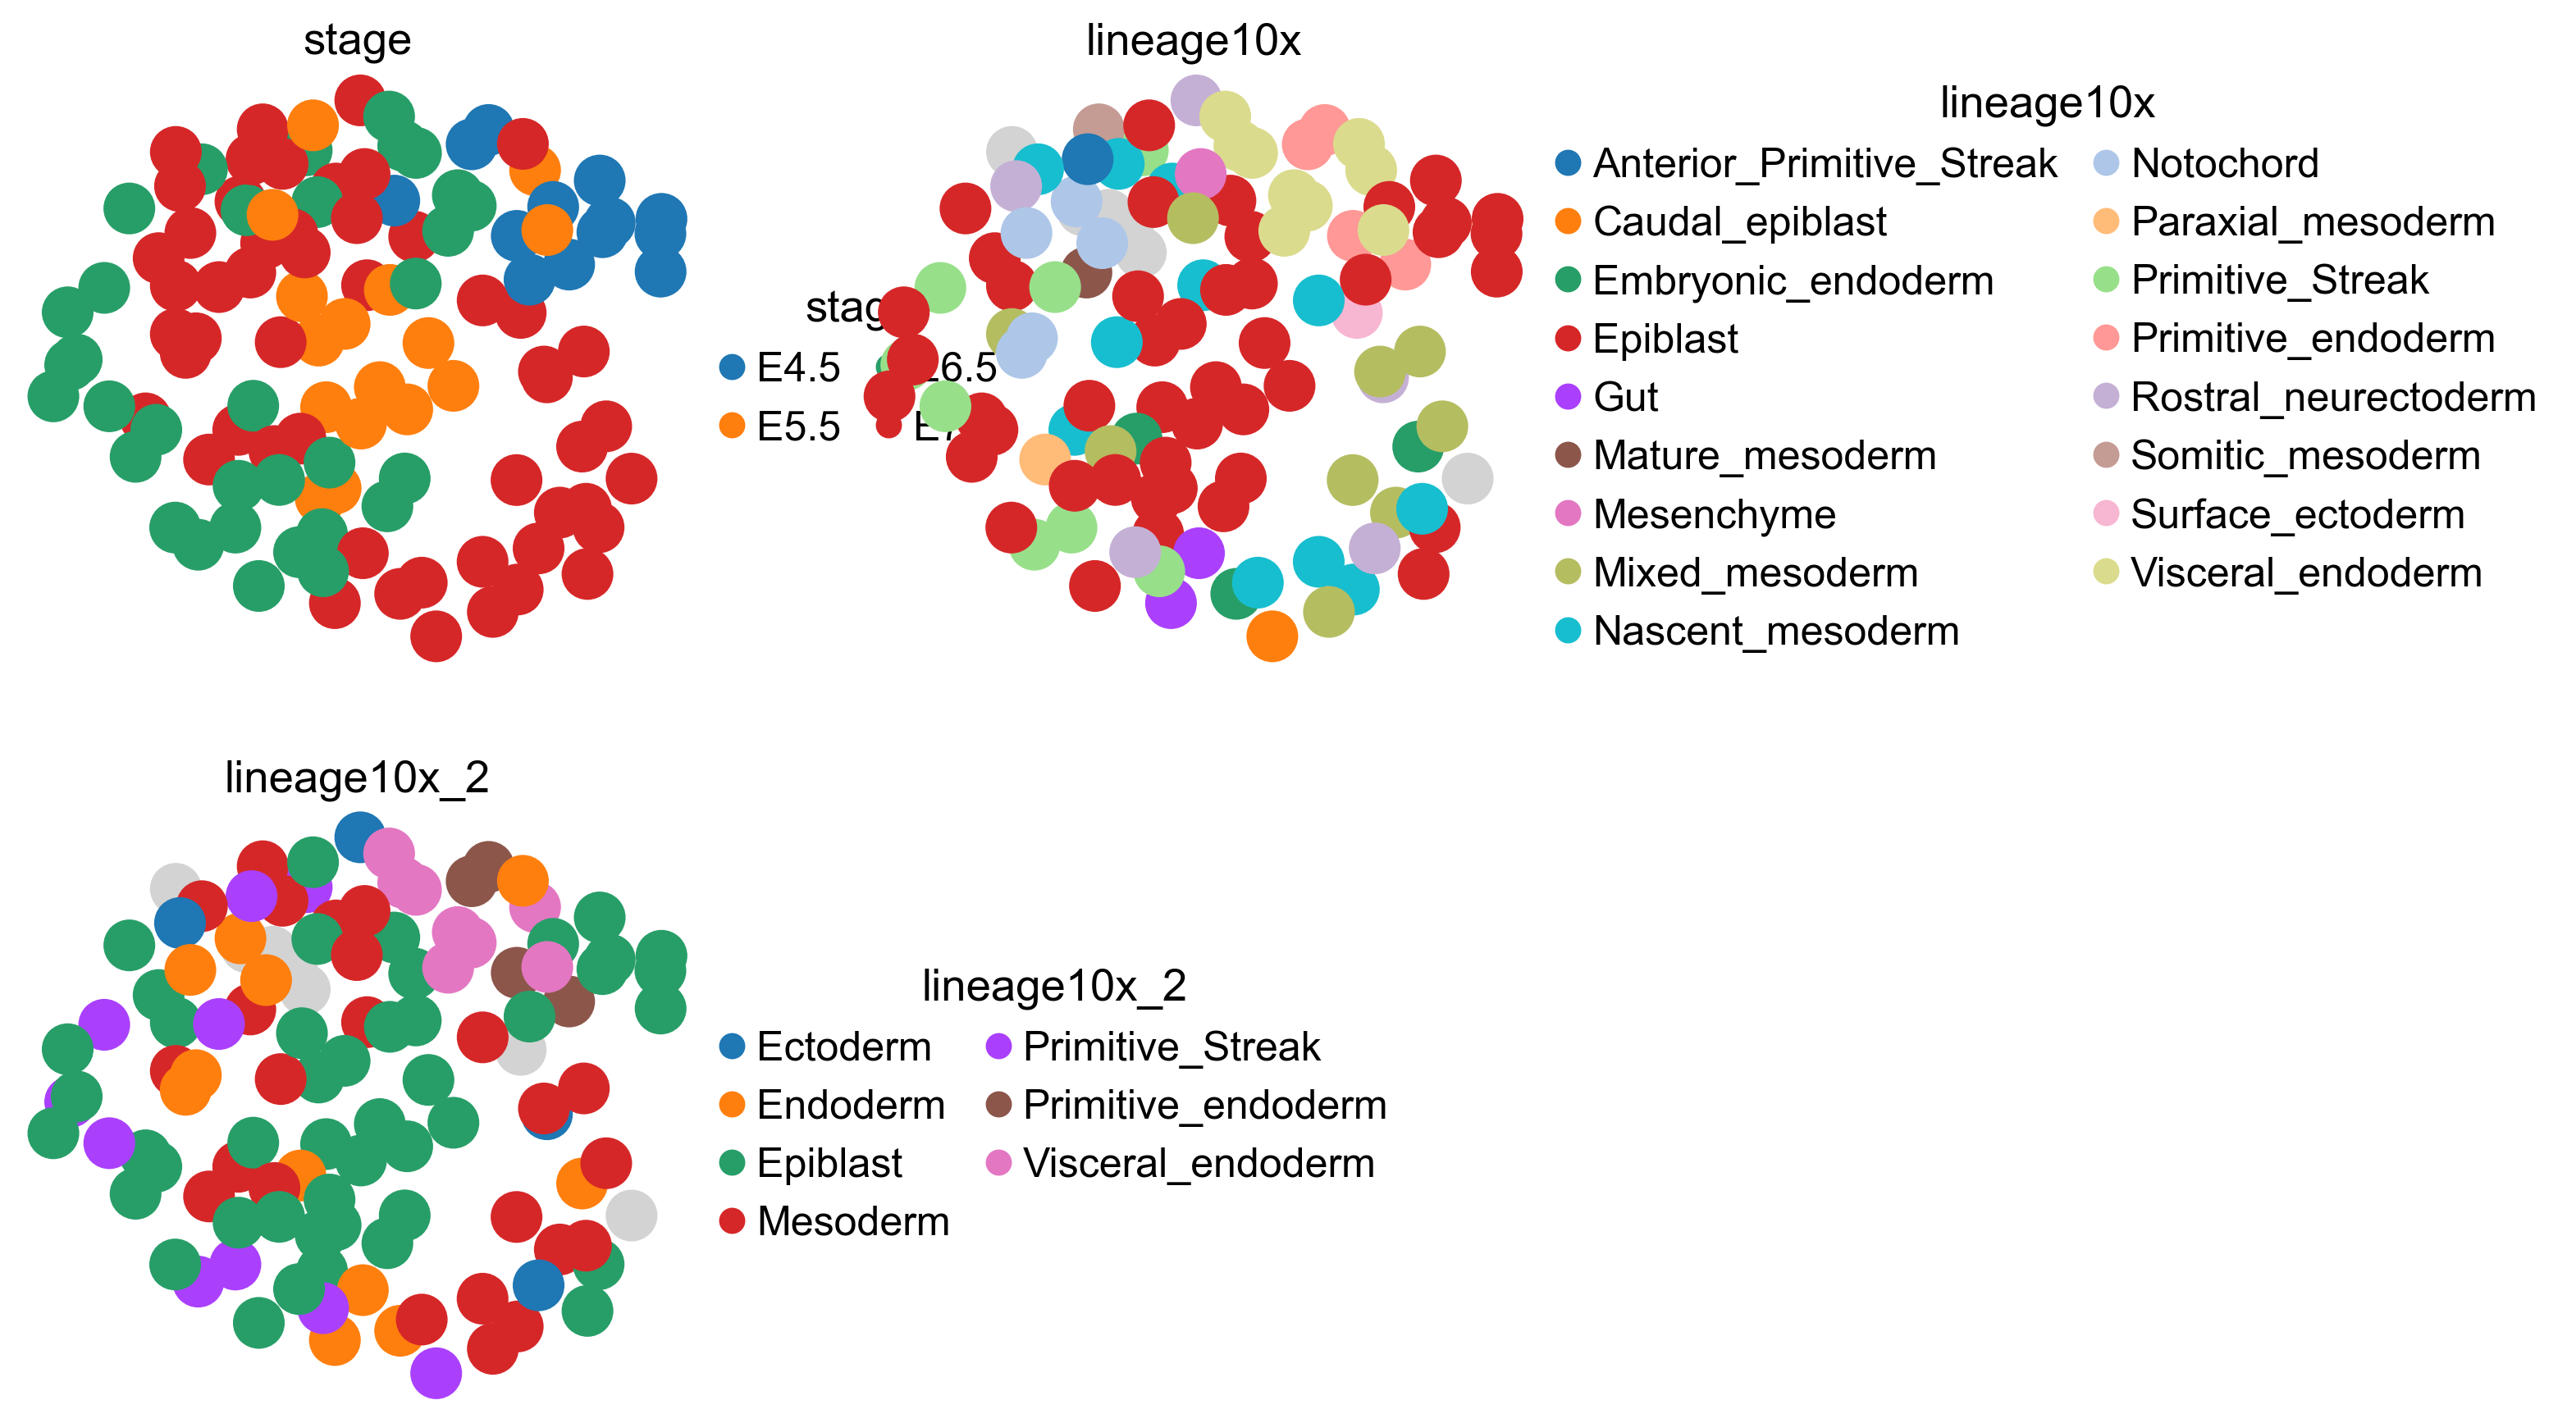

In [141]:
# =========================================================
# 17) Encode fused latent + UMAP (tri-modal)
# =========================================================
from univi.evaluation import encode_fused_adata_pair, encode_adata
from univi.plotting import set_style, umap

set_style(font_scale=1.1, dpi=140)

# Subset to test cells for inductive eval if desired
rna_test = adata_dict["rna"][test_idx].copy()
cpg_test = adata_dict["cpg"][test_idx].copy()
gpc_test = adata_dict["gpc"][test_idx].copy()

#rna_test = adata_dict["rna"].copy()
#cpg_test = adata_dict["cpg"].copy()
#gpc_test = adata_dict["gpc"].copy()

assert np.array_equal(rna_test.obs_names, cpg_test.obs_names)
assert np.array_equal(rna_test.obs_names, gpc_test.obs_names)

# Fused encoding across all 3 modalities
fused = encode_fused_adata_pair(
    model,
    adata_by_mod={"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    device=device,
    batch_size=512,
    use_mean=True,
    return_gates=True,
    return_gate_logits=True,
    write_to_adatas=True,
    fused_obsm_key="X_univi_fused",
    gate_prefix="gate",
)

print("fused keys:", list(fused.keys()))
print("Z_fused shape:", None if "Z_fused" not in fused else fused["Z_fused"].shape)

# Plot on one modality object (same cells/order)
color_cols = [c for c in ["stage", "lineage10x", "lineage10x_2"] if c in rna_test.obs.columns]
if len(color_cols) == 0:
    color_cols = None

umap(
    rna_test,
    obsm_key="X_univi_fused",
    color=color_cols,
    legend="outside",
    show=True,
)


In [142]:
# =========================================================
# 18) Optional cross-modal prediction examples
# =========================================================
from univi.evaluation import cross_modal_predict, evaluate_cross_reconstruction, reconstruction_metrics

# RNA -> CpG
cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    layer=None,
    X_key="X",
    batch_size=256,
    use_moe=True,
)
cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna

# RNA -> GpC
gpc_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="gpc",
    device=device,
    layer=None,
    X_key="X",
    batch_size=256,
    use_moe=True,
)
gpc_test.layers["imputed_from_rna"] = gpc_hat_from_rna

print("Stored imputed layers:")
print("cpg:", cpg_test.layers.keys())
print("gpc:", gpc_test.layers.keys())


Stored imputed layers:
cpg: KeysView(Layers with keys: meth_successes, meth_total_count, imputed_from_rna)
gpc: KeysView(Layers with keys: acc_successes, acc_total_count, imputed_from_rna)


In [143]:
# =========================================================
# 19) Quick evaluation helpers
# =========================================================
def to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)

# Example: compare predicted CpG fractions vs observed CpG fractions on test cells
true_cpg = to_dense(cpg_test.X)
pred_cpg = to_dense(cpg_test.layers["imputed_from_rna"])

# If dimensions match:
if true_cpg.shape == pred_cpg.shape:
    from univi.evaluation import reconstruction_metrics
    rep = reconstruction_metrics(true_cpg, pred_cpg)
    print("CpG (RNA->CpG) MSE mean:", rep.get("mse_mean"))
    print("CpG (RNA->CpG) Pearson mean:", rep.get("pearson_mean"))
else:
    print("Shape mismatch:", true_cpg.shape, pred_cpg.shape)
    

CpG (RNA->CpG) MSE mean: 0.1758035570383072
CpG (RNA->CpG) Pearson mean: 0.2735781669616699


NOTE: Since this is a small dataset, we can either use the test set to evaluate and visualize, or we can just use the whole dataset and treat it as transductive.

In [144]:
from univi.evaluation import encode_adata, cross_modal_predict, evaluate_cross_reconstruction

#rna_test = adata_dict["rna"][test_idx].copy()
#cpg_test = adata_dict["cpg"][test_idx].copy()
#gpc_test = adata_dict["gpc"][test_idx].copy()
#rna_test = adata_dict["rna"].copy()
#cpg_test = adata_dict["cpg"].copy()
#gpc_test = adata_dict["gpc"].copy()

# Encode single-modality latents
rna_test.obsm["X_univi"] = encode_adata(
    model, rna_test, modality="rna", device=device, batch_size=512, latent="moe_mean"
)
cpg_test.obsm["X_univi"] = encode_adata(
    model, cpg_test, modality="cpg", device=device, batch_size=512, latent="moe_mean"
)
gpc_test.obsm["X_univi"] = encode_adata(
    model, gpc_test, modality="gpc", device=device, batch_size=512, latent="moe_mean"
)

print("Latent shapes:")
print("  RNA:", rna_test.obsm["X_univi"].shape)
print("  CpG:", cpg_test.obsm["X_univi"].shape)
print("  GpC:", gpc_test.obsm["X_univi"].shape)

# Cross-modal prediction: RNA -> CpG
cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    batch_size=256,
    use_moe=True,
)
cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna

rep_rna_to_cpg = evaluate_cross_reconstruction(
    model,
    adata_src=rna_test,
    adata_tgt=cpg_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    batch_size=256,
)
print("RNA -> CpG summary:")
print(rep_rna_to_cpg["summary"])


Latent shapes:
  RNA: (114, 30)
  CpG: (114, 30)
  GpC: (114, 30)
RNA -> CpG summary:
{'mse_mean': 0.1758035570383072, 'mse_median': 0.14602336287498474, 'pearson_mean': 0.2735781669616699, 'pearson_median': 0.28059688210487366, 'per_cell_mean': 0.17580357193946838}


In [145]:
print(rna_test)


AnnData object with n_obs × n_vars = 114 × 22084
    obs: 'modality', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2', 'gate_rna', 'gate_cpg', 'gate_gpc', 'gate_logit_rna', 'gate_logit_cpg', 'gate_logit_gpc'
    var: 'feature_type'
    uns: 'log1p', 'neighbors', 'umap', 'stage_colors', 'lineage10x_colors', 'lineage10x_2_colors'
    obsm: 'X_univi_fused', 'X_umap', 'X_univi'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


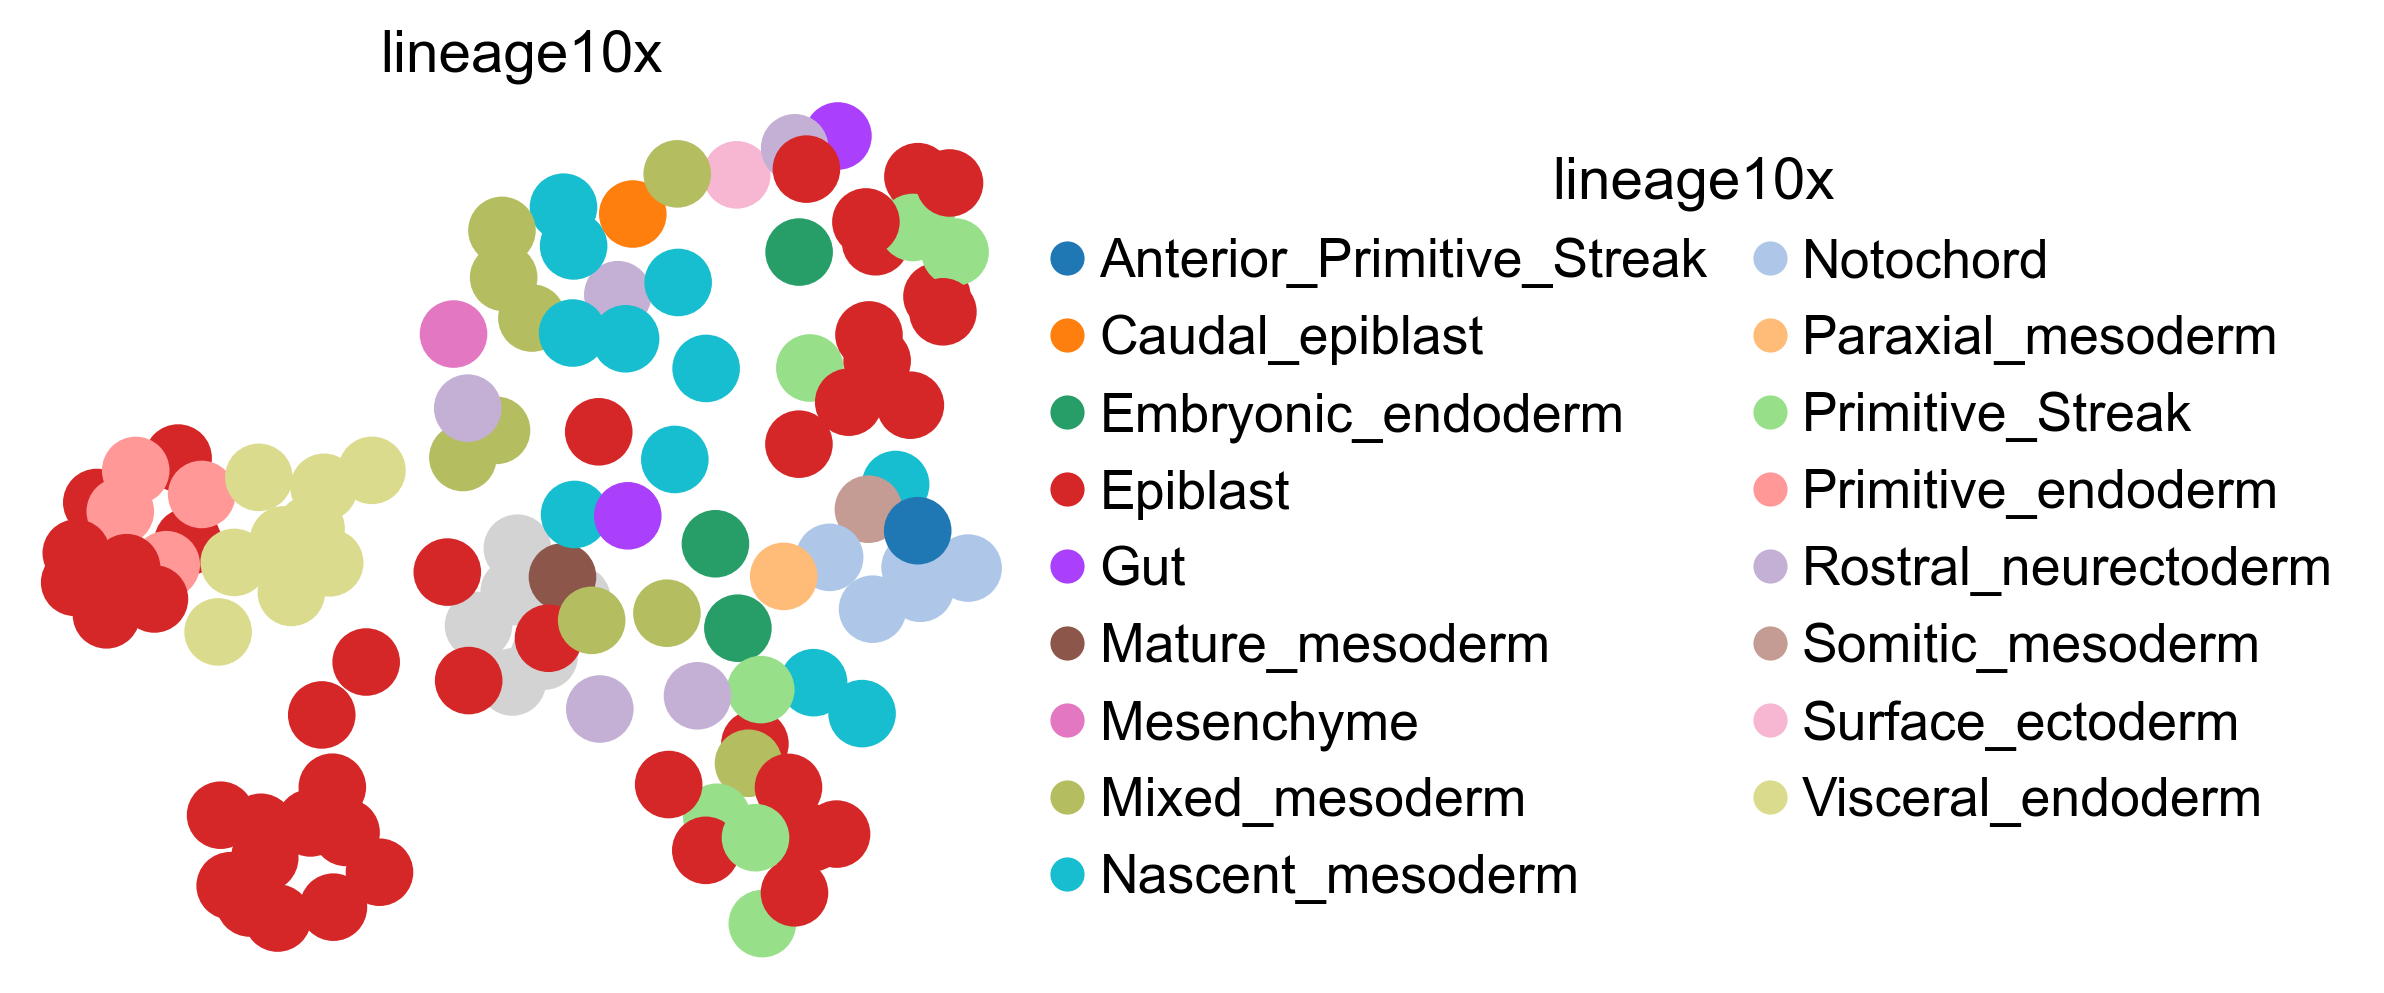

In [146]:
from univi.plotting import set_style, umap

set_style(font_scale=1.1, dpi=150)

# make UMAP on RNA latent
sc.pp.neighbors(rna_test, use_rep="X_univi")
sc.tl.umap(rna_test)

umap(
    rna_test,
    obsm_key="X_univi",
    color="lineage10x",
    legend="outside",
    show=True,
)


In [147]:
print(rna_test)


AnnData object with n_obs × n_vars = 114 × 22084
    obs: 'modality', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2', 'gate_rna', 'gate_cpg', 'gate_gpc', 'gate_logit_rna', 'gate_logit_cpg', 'gate_logit_gpc'
    var: 'feature_type'
    uns: 'log1p', 'neighbors', 'umap', 'stage_colors', 'lineage10x_colors', 'lineage10x_2_colors'
    obsm: 'X_univi_fused', 'X_umap', 'X_univi'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


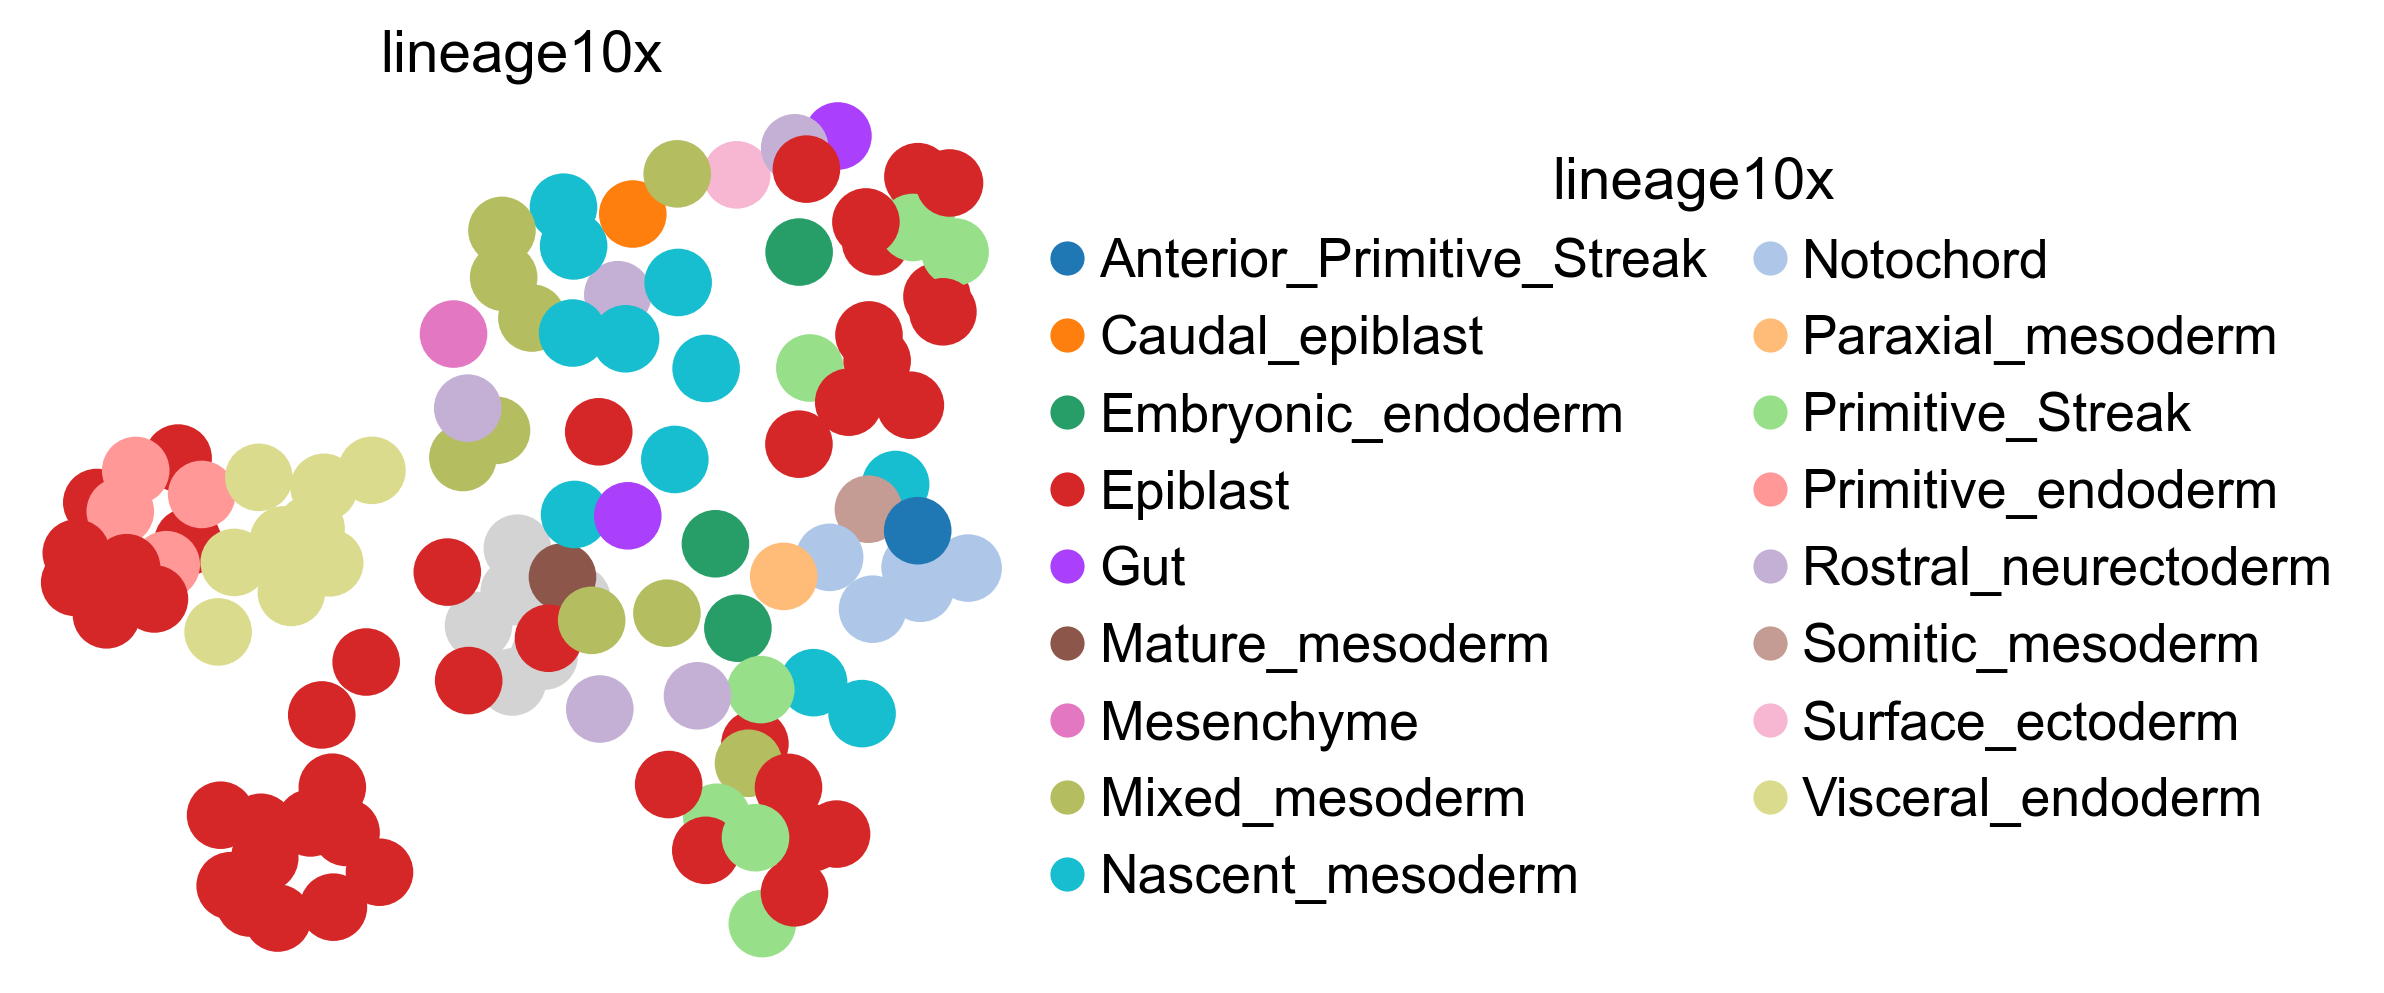

In [148]:
umap(
    rna_test,
    obsm_key="X_univi",
    color=["lineage10x"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    show=True,
)


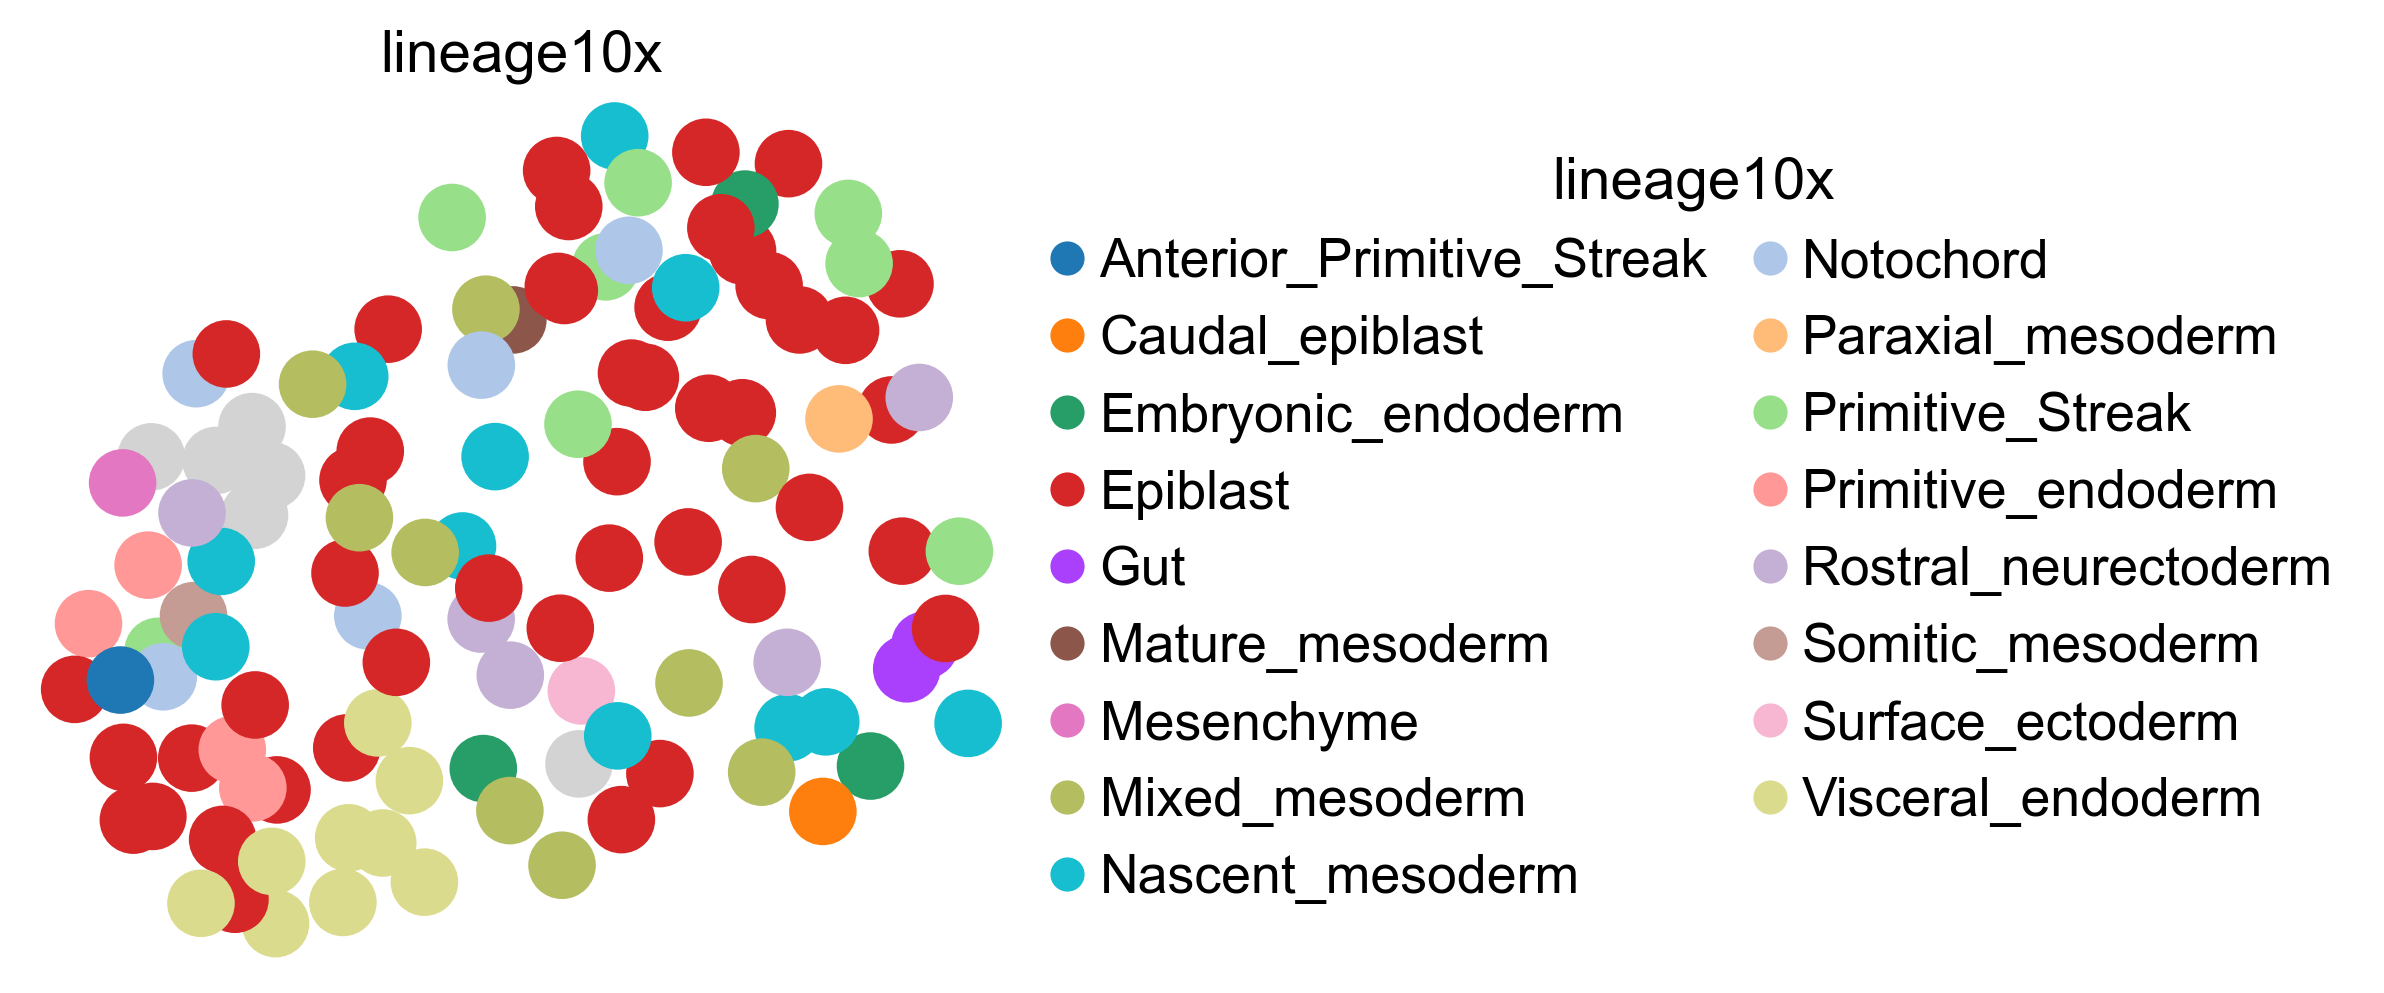

In [149]:
umap(
    cpg_test,
    obsm_key="X_univi",
    color=["lineage10x"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    show=True,
)


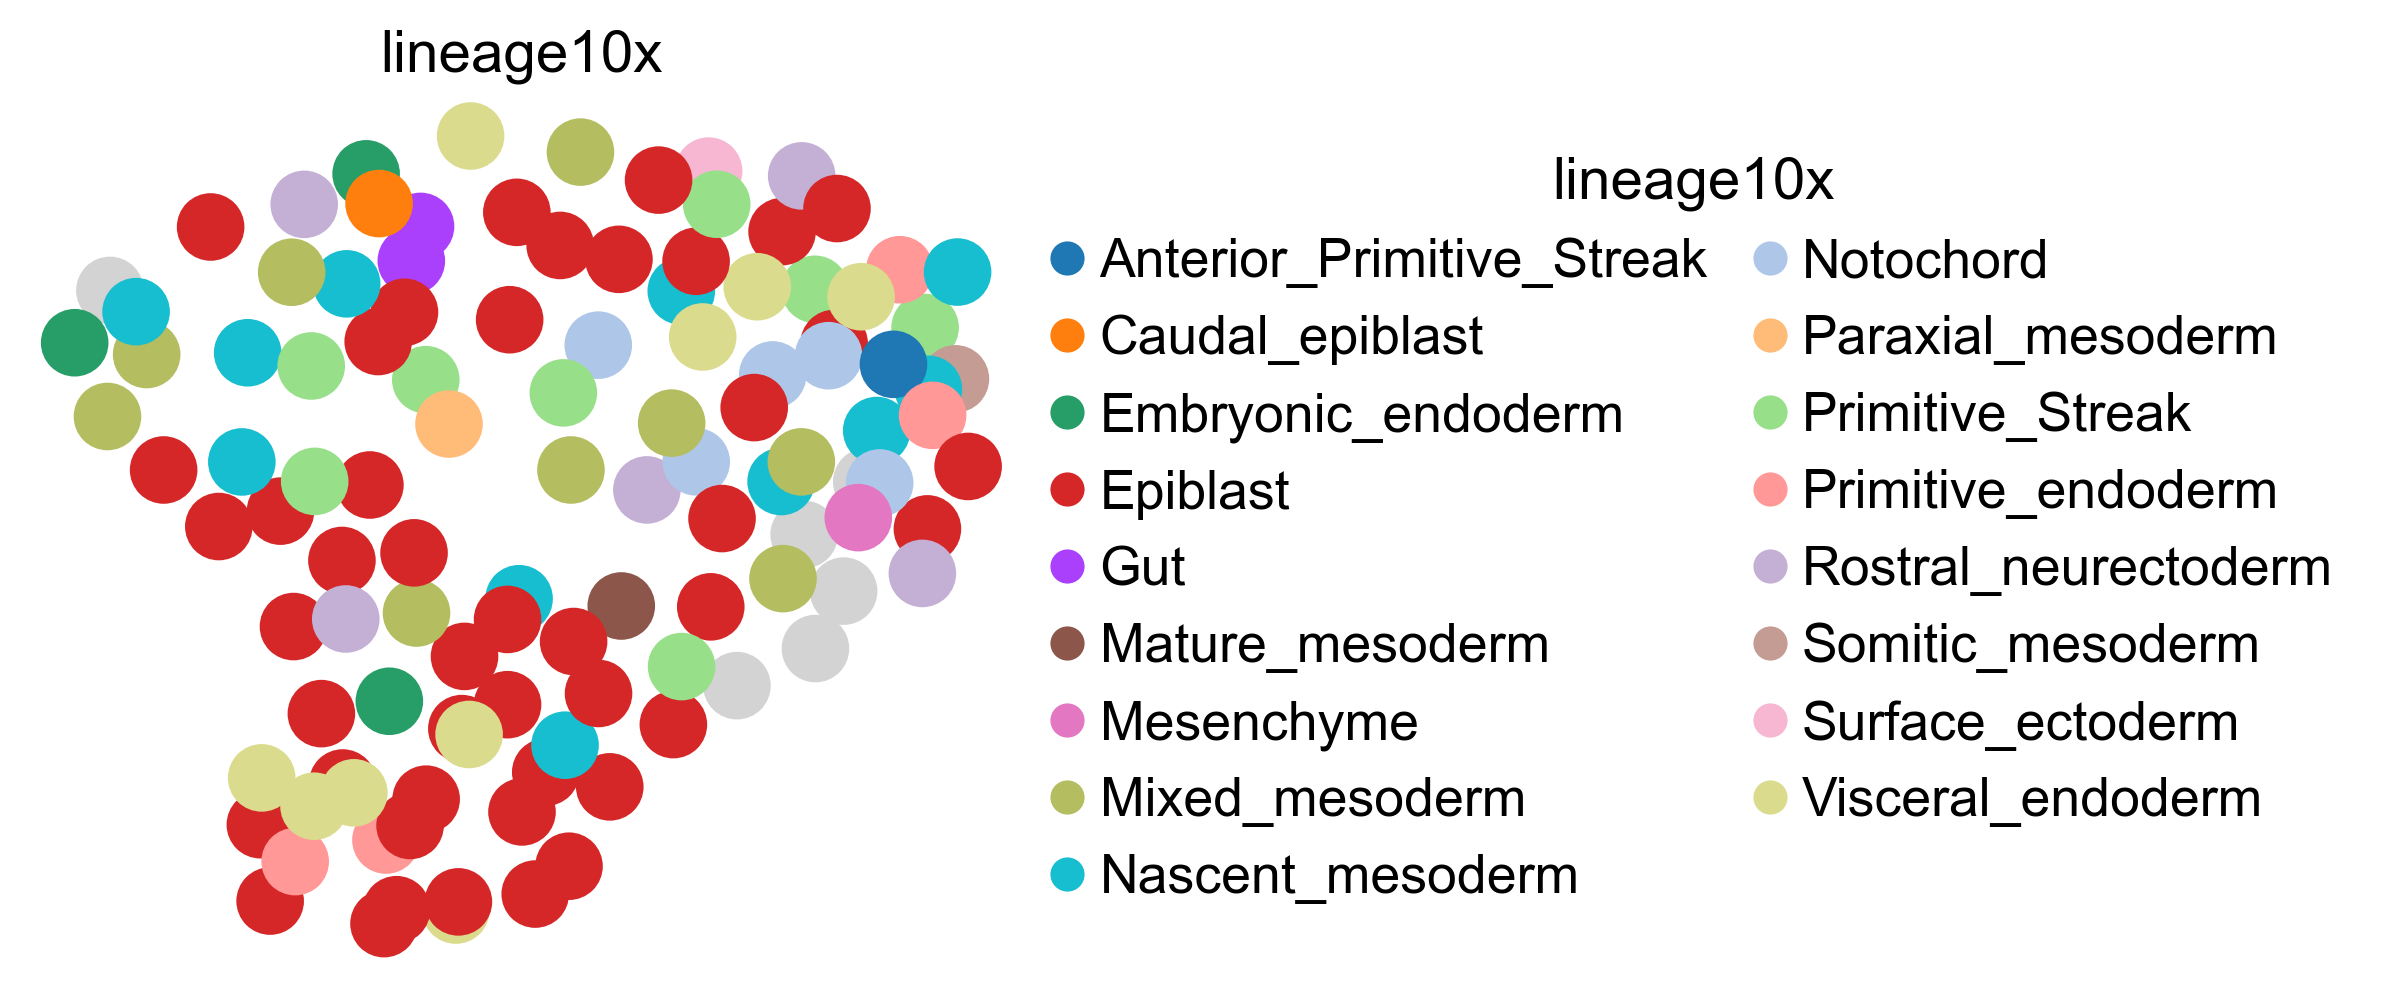

In [150]:
umap(
    gpc_test,
    obsm_key="X_univi",
    color=["lineage10x"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    show=True,
)


In [151]:
from univi.evaluation import encode_fused_adata_pair

# despite the name, it accepts adata_by_mod with multiple modalities in your README examples
fused = encode_fused_adata_pair(
    model,
    adata_by_mod={"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    device=device,
    batch_size=256,
    use_mean=True,
    return_gates=True,
    return_gate_logits=True,
    write_to_adatas=True,
    fused_obsm_key="X_univi_fused",
    gate_prefix="gate",
)

print(fused.keys())
print("Z_fused shape:", fused["Z_fused"].shape)


dict_keys(['mu', 'logvar', 'Z_fused', 'gates', 'gate_logits', 'modality_order'])
Z_fused shape: (114, 30)


In [152]:
from univi.evaluation import evaluate_alignment

# RNA vs CpG alignment in latent
metrics_rna_cpg = evaluate_alignment(
    Z1=rna_test.obsm["X_univi"],
    Z2=cpg_test.obsm["X_univi"],
    metric="euclidean",
    recall_ks=(1, 5, 10),
    k_mixing=8,
    k_entropy=8,
    json_safe=True,
)
print(metrics_rna_cpg)


{'metric': 'euclidean', 'n_cells': 114, 'foscttm_mean': 0.20749883471350922, 'foscttm_sem': 0.02494251673323437, 'recall_at_k': {'1': {'mean': 0.07017543859649122, 'sem': 0.02403000455077889}, '5': {'mean': 0.3157894736842105, 'sem': 0.04372748290278002}, '10': {'mean': 0.5, 'sem': 0.047036043419179864}}, 'modality_mixing_mean': 0.3305921052631579, 'modality_mixing_sem': 0.015327872627955095, 'modality_entropy_mean': 0.7116639316082001, 'modality_entropy_sem': 0.02191359253779723, 'k_mixing': 8, 'k_entropy': 8}


In [153]:
from univi.evaluation import cross_modal_predict

cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    X_key="X",
    batch_size=128,
    use_moe=True,
)

# Store as an imputed layer (mean-like output from decoder utility)
cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna
print("cpg_hat_from_rna shape:", np.asarray(cpg_hat_from_rna).shape)


cpg_hat_from_rna shape: (114, 18285)


In [154]:
import numpy as np
import scipy.sparse as sp
import torch

from univi.evaluation import (
    encode_adata,
    encode_fused_adata_pair,
    cross_modal_predict,
    denoise_adata,
    denoise_from_multimodal,
    evaluate_alignment,
    reconstruction_metrics,
    # NEW (generation + recon error workflows)
    generate_from_latent,
    fit_label_latent_gaussians,
    sample_latent_by_label,
    evaluate_cross_reconstruction,
)
from univi.plotting import (
    set_style,
    umap,
    umap_by_modality,
    compare_raw_vs_denoised_umap_features,
    plot_confusion_matrix,
    write_gates_to_obs,
    plot_moe_gate_summary,
    # NEW (reconstruction error plots)
    plot_reconstruction_error_summary,
    plot_featurewise_reconstruction_scatter,
)

set_style(font_scale=1.2, dpi=150)
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")


In [155]:
def to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)


In [156]:
fused = encode_fused_adata_pair(
    model,
    adata_by_mod={"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    device=device,
    batch_size=8,
    use_mean=True,
    return_gates=True,
    return_gate_logits=True,
    write_to_adatas=True,
    fused_obsm_key="X_univi_fused",
    gate_prefix="gate",
)

# fused["Z_fused"] -> (n_cells, latent_dim)
# fused["gates"]  -> (n_cells, n_modalities) or None (if fused transformer posterior is used)


In [157]:
print(rna_test)


AnnData object with n_obs × n_vars = 114 × 22084
    obs: 'modality', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2', 'gate_rna', 'gate_cpg', 'gate_gpc', 'gate_logit_rna', 'gate_logit_cpg', 'gate_logit_gpc'
    var: 'feature_type'
    uns: 'log1p', 'neighbors', 'umap', 'stage_colors', 'lineage10x_colors', 'lineage10x_2_colors'
    obsm: 'X_univi_fused', 'X_umap', 'X_univi'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


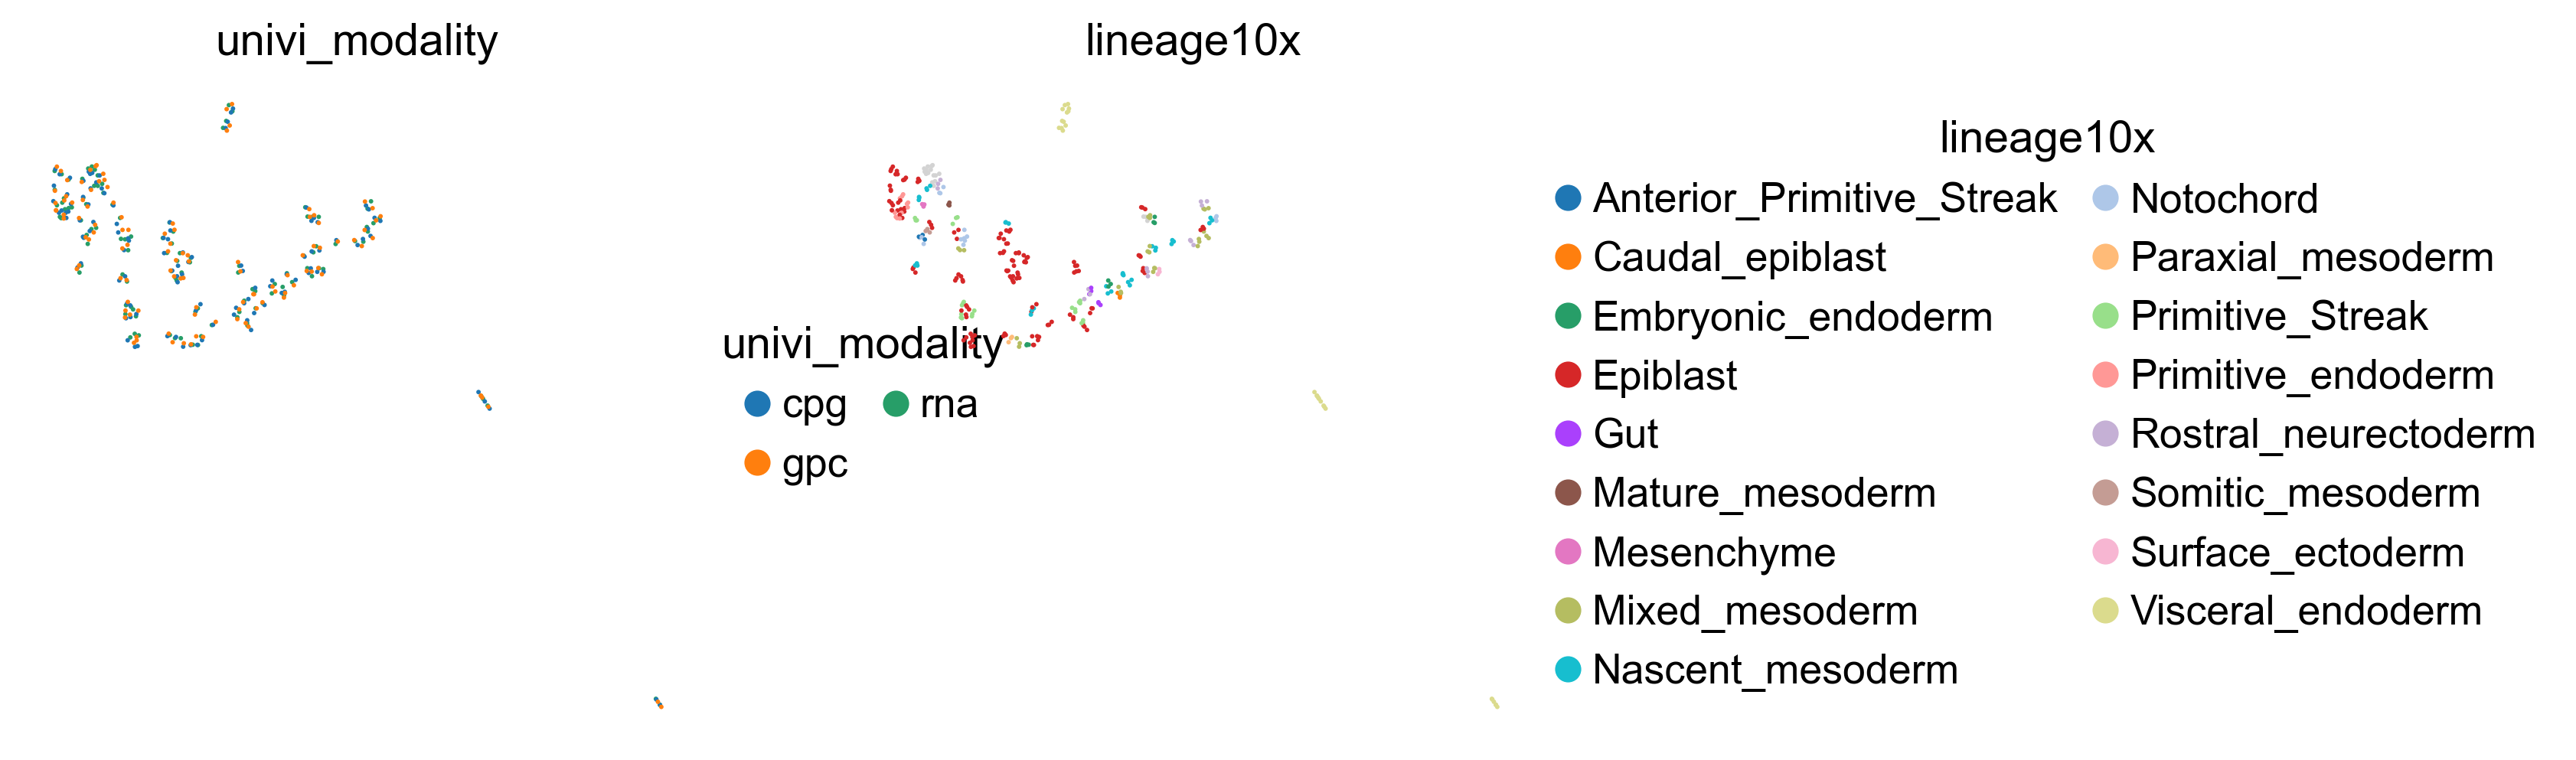

In [158]:
umap_by_modality(
    {"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    obsm_key="X_univi_fused",
    color=["univi_modality", "lineage10x"],
    legend="outside",
    size=8,
    #savepath="umap_fused_both_modalities.png",
    show=True,
)


/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


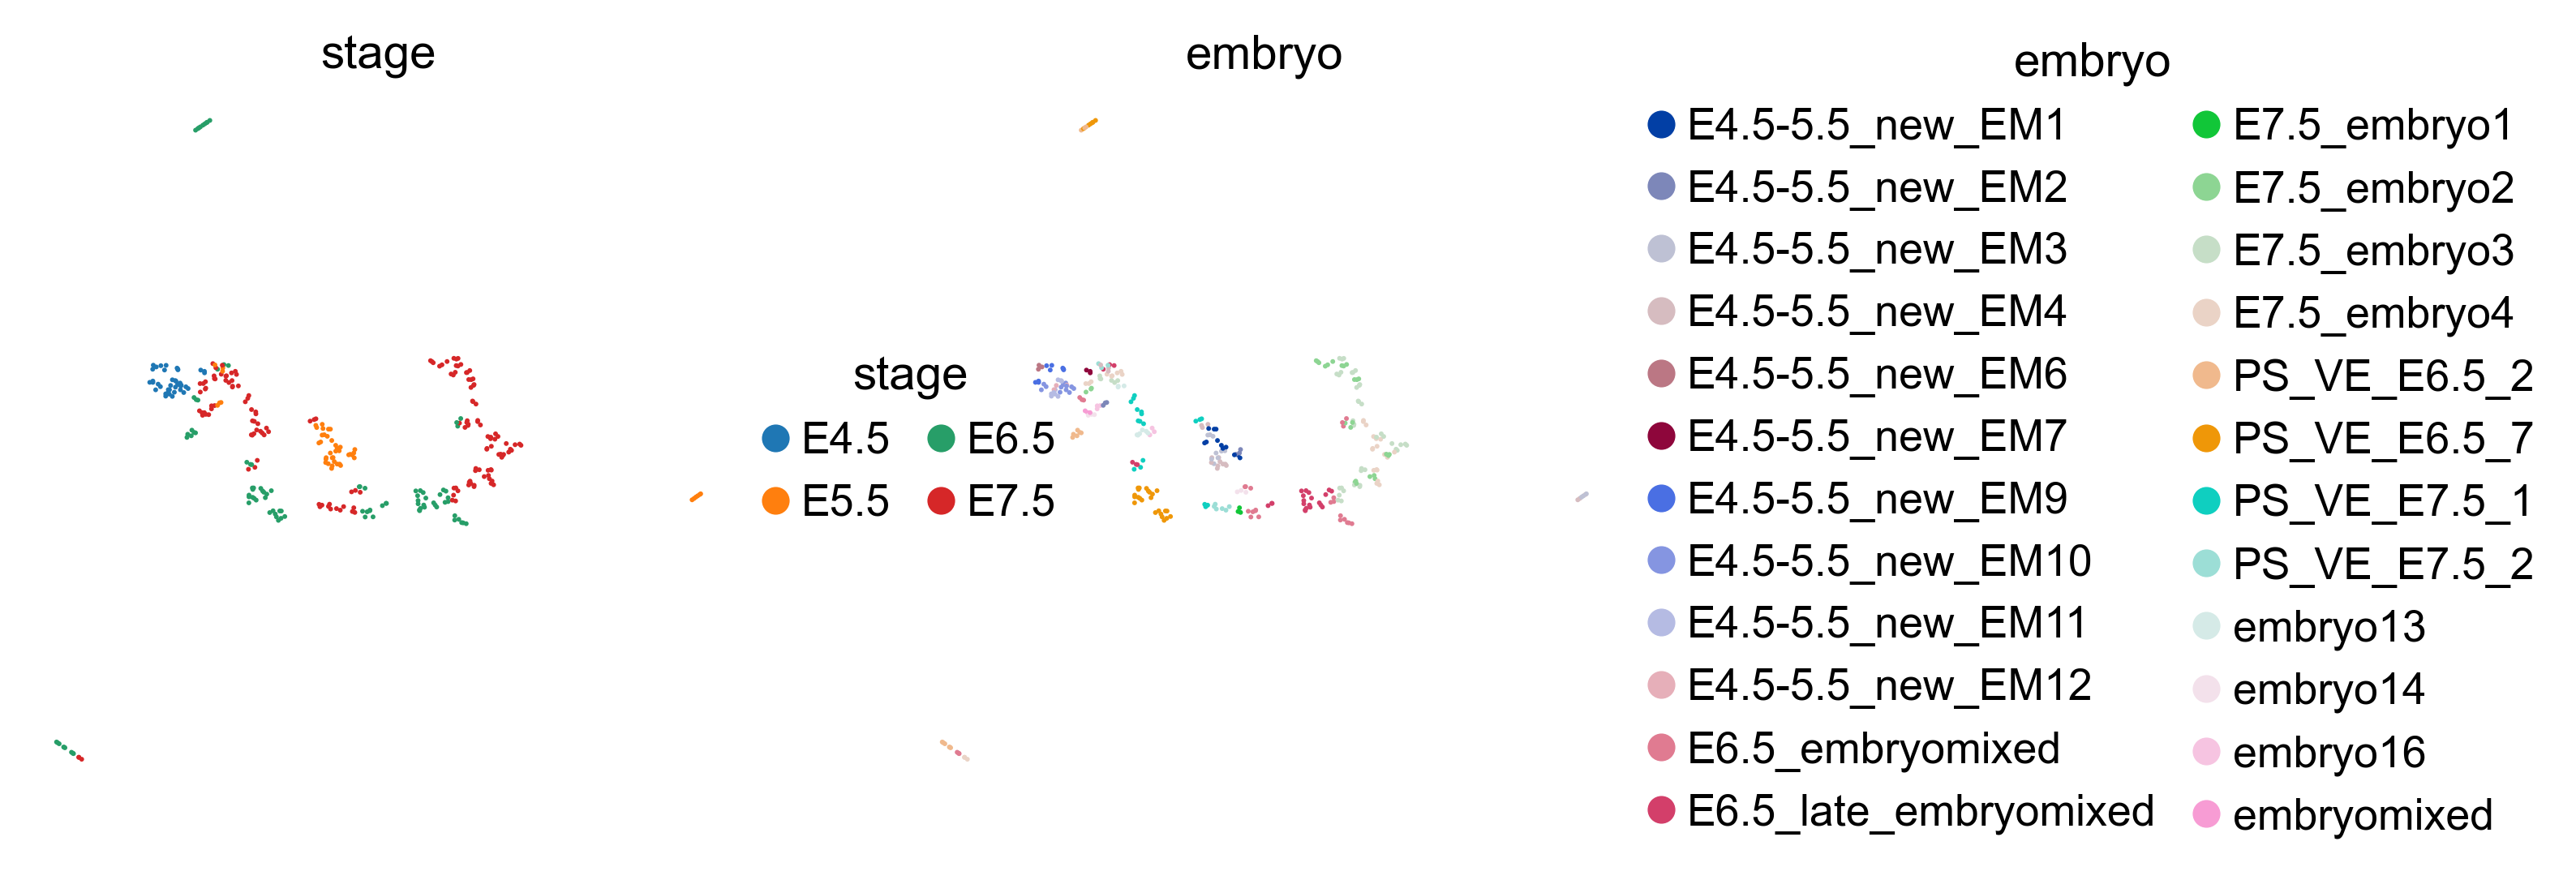

In [159]:
umap_by_modality(
    {"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    obsm_key="X_univi_fused",
    color=["stage", "embryo"],
    legend="outside",
    size=8,
    #savepath="umap_fused_both_modalities.png",
    show=True,
)


In [160]:
cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    layer=None,
    X_key="X",
    batch_size=8,
    use_moe=True,
)

cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna


In [161]:
gpc_hat_from_cpg = cross_modal_predict(
    model,
    adata_src=cpg_test,
    src_mod="cpg",
    tgt_mod="gpc",
    device=device,
    layer=None,
    X_key="X",
    batch_size=8,
    use_moe=True,
)

gpc_test.layers["imputed_from_cpg"] = gpc_hat_from_cpg


In [162]:
rna_hat_from_cpg = cross_modal_predict(
    model,
    adata_src=cpg_test,
    src_mod="cpg",
    tgt_mod="rna",
    device=device,
    layer=None,
    X_key="X",
    batch_size=8,
    use_moe=True,
)

rna_test.layers["imputed_from_cpg"] = rna_hat_from_cpg


In [163]:
true = to_dense(cpg_test.X)
pred = cpg_test.layers["imputed_from_rna"]

m = reconstruction_metrics(true, pred)
print("MSE mean:", m["mse_mean"])
print("Pearson mean:", m["pearson_mean"])


MSE mean: 0.1758035570383072
Pearson mean: 0.2735781669616699


In [164]:
rep = evaluate_cross_reconstruction(
    model,
    adata_src=rna_test,
    adata_tgt=cpg_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    src_layer=None,
    tgt_layer=None,
    batch_size=8,
    # optionally restrict to a feature subset (e.g., top markers)
    feature_names=None,
)
print(rep["summary"])   # mse_mean/median, pearson_mean/median, etc.


{'mse_mean': 0.1758035570383072, 'mse_median': 0.14602336287498474, 'pearson_mean': 0.2735781669616699, 'pearson_median': 0.28059685230255127, 'per_cell_mean': 0.17580357193946838}


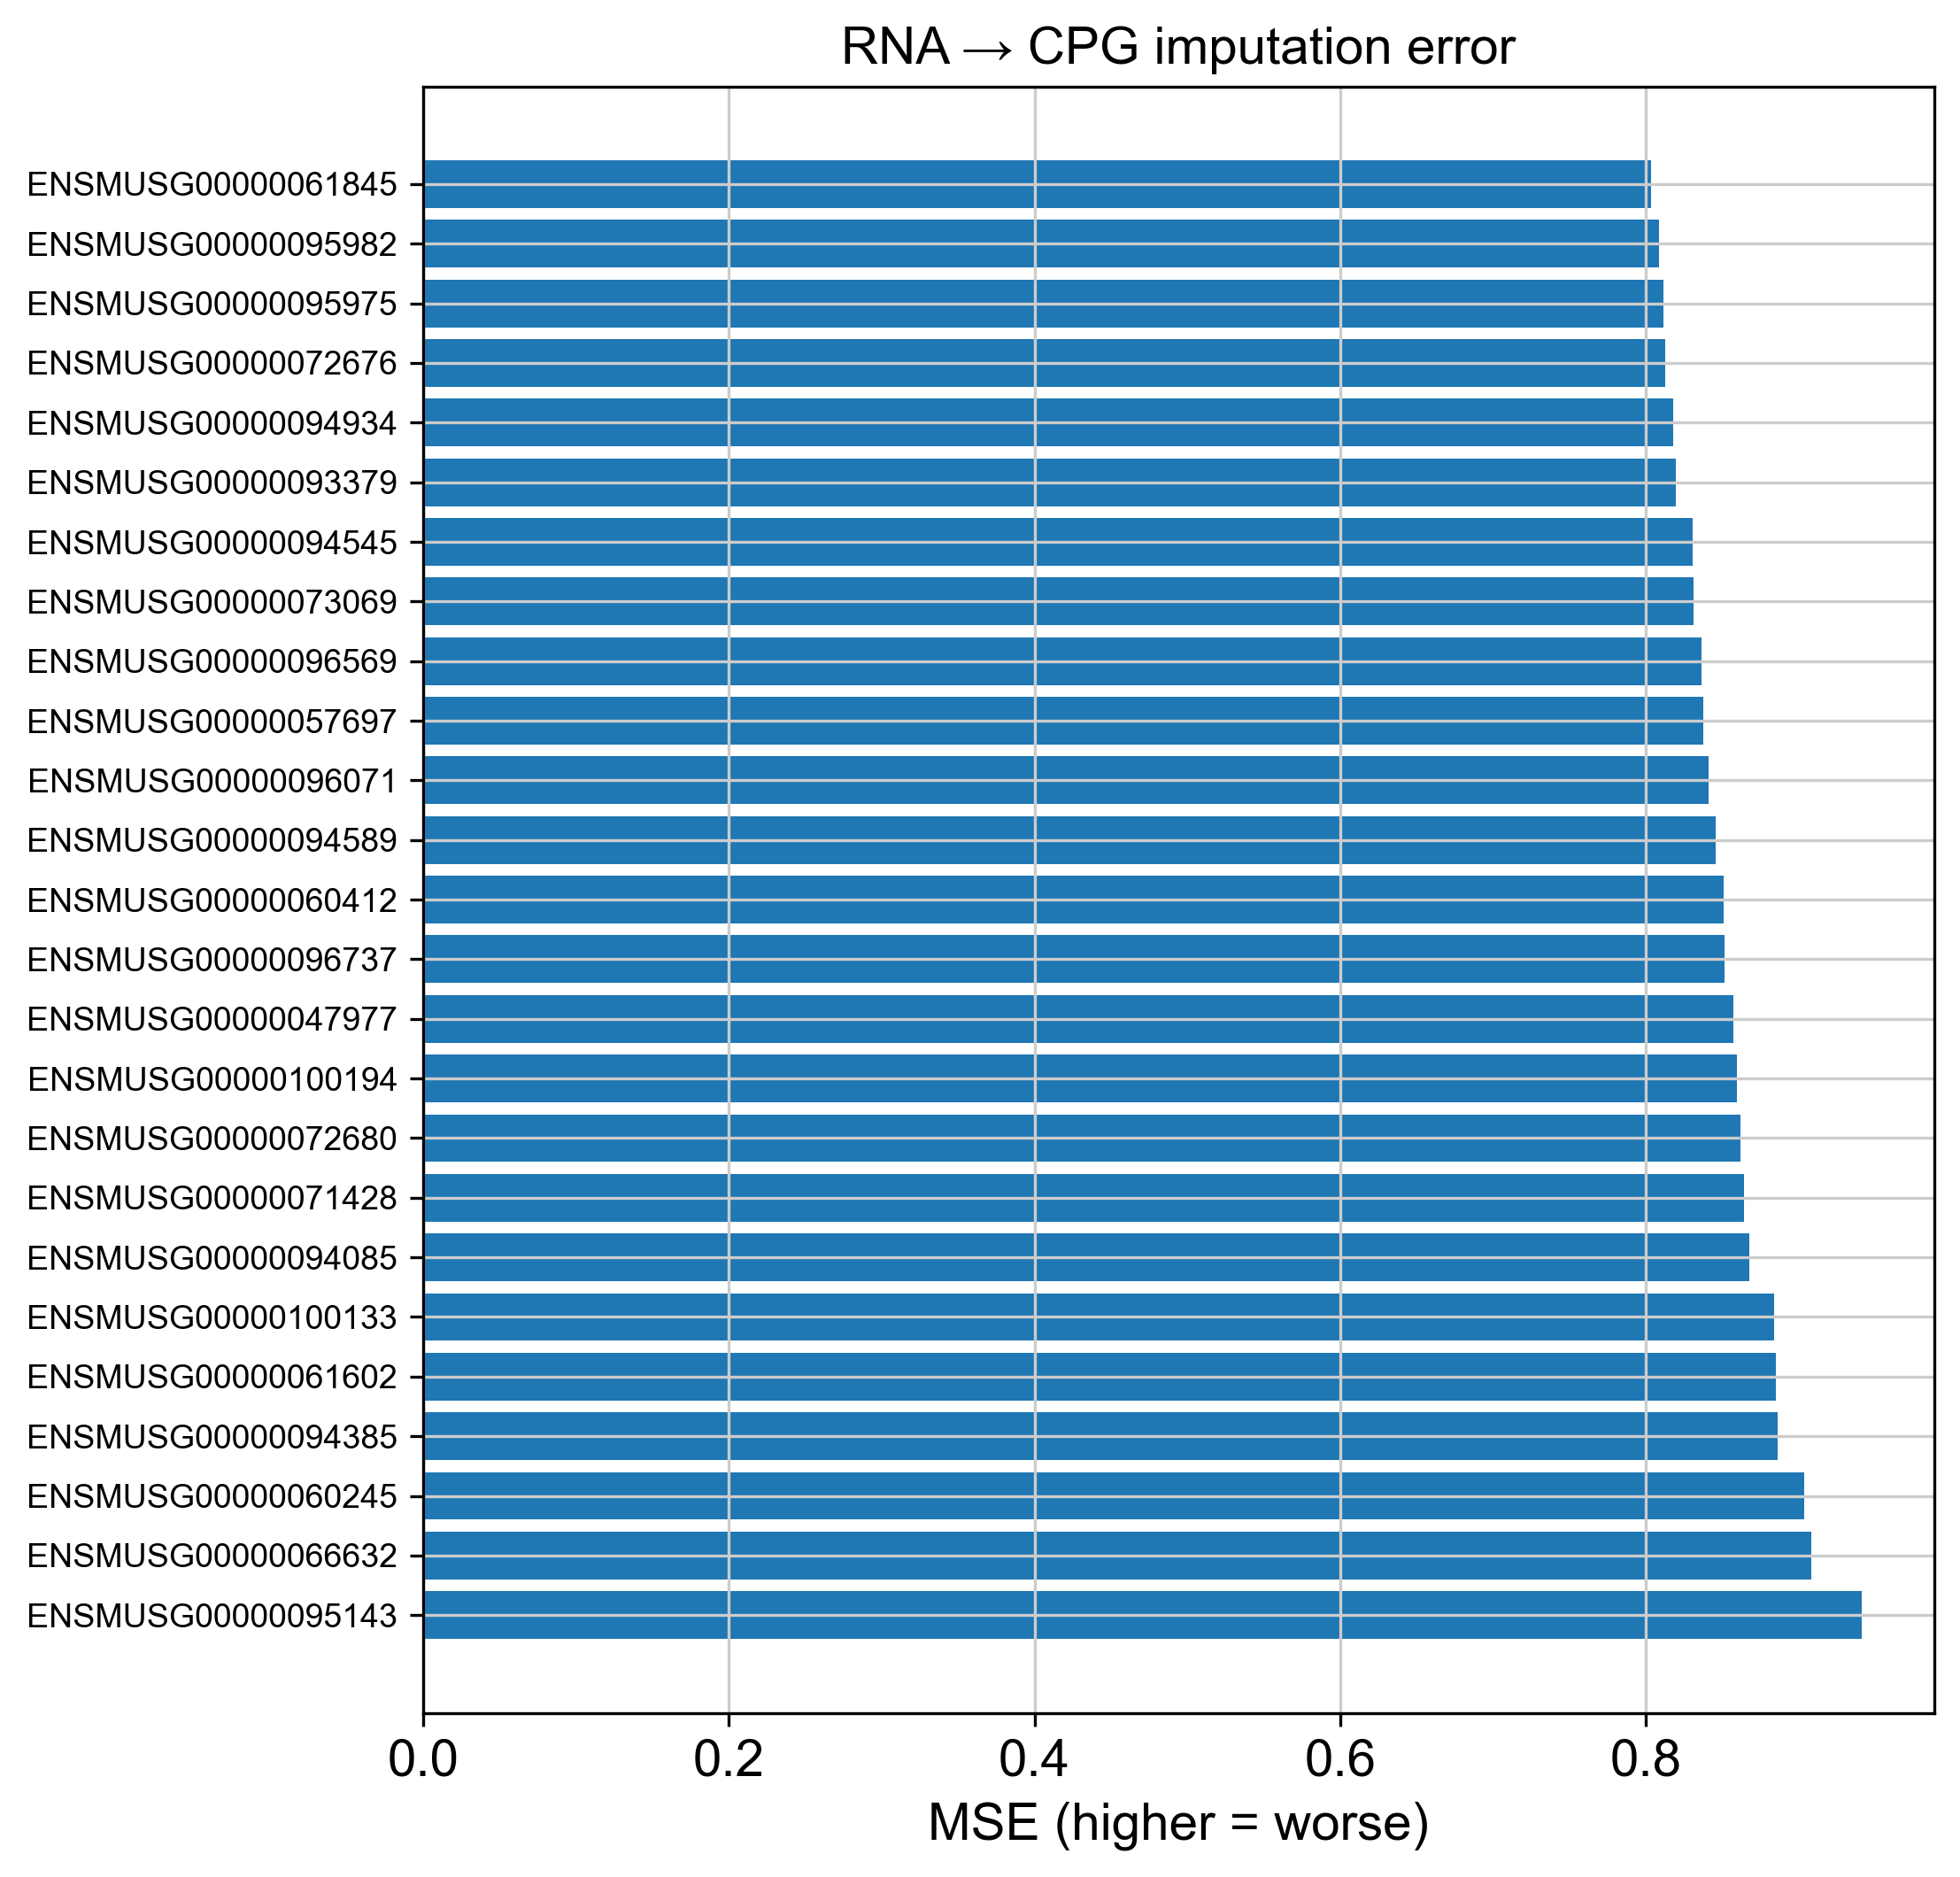

In [165]:
plot_reconstruction_error_summary(
    rep,
    title="RNA → CPG imputation error",
    #savepath="recon_error_summary.png",
    show=True,
)


In [166]:
from univi.evaluation import to_dense, encode_moe_gates_from_tensors
from univi.plotting import write_gates_to_obs, plot_moe_gate_summary

gate = encode_moe_gates_from_tensors(
    model,
    x_dict={"rna": to_dense(rna_test.X), "cpg": to_dense(cpg_test.X), "gpc": to_dense(gpc_test.X)},
    device=device,
    batch_size=8,
    modality_order=["rna", "cpg", "gpc"],
    kind="router_x_precision",  # falls back to "effective_precision" if router logits are unavailable
    return_logits=True,
)

W    = gate["weights"]         # (n_cells, n_modalities), rows sum to 1
mods = gate["modality_order"]  # e.g. ["rna", "adt"]

print("Requested kind:", gate.get("requested_kind"))
print("Effective kind:", gate.get("kind"))
print("Per-modality mean:", gate.get("per_modality_mean"))
print("Has logits:", gate.get("logits") is not None)


Requested kind: router_x_precision
Effective kind: router_x_precision
Per-modality mean: {'rna': 0.3092495799064636, 'cpg': 0.33442601561546326, 'gpc': 0.3563244044780731}
Has logits: True


In [167]:
write_gates_to_obs(
    rna_test,
    gates=W,
    modality_names=mods,
    gate_prefix="moe_gate",          # creates obs cols: moe_gate_{mod}
    gate_logits=gate.get("logits"),  # optional; may be None
)


In [168]:
print(rna_test)


AnnData object with n_obs × n_vars = 114 × 22084
    obs: 'modality', 'sample', 'id_rna', 'id_met', 'id_acc', 'embryo', 'plate', 'pass_rnaQC', 'pass_metQC', 'pass_accQC', 'stage', 'lineage10x', 'lineage10x_2', 'gate_rna', 'gate_cpg', 'gate_gpc', 'gate_logit_rna', 'gate_logit_cpg', 'gate_logit_gpc', 'moe_gate_rna', 'moe_gate_cpg', 'moe_gate_gpc', 'moe_gate_logit_rna', 'moe_gate_logit_cpg', 'moe_gate_logit_gpc'
    var: 'feature_type'
    uns: 'log1p', 'neighbors', 'umap', 'stage_colors', 'lineage10x_colors', 'lineage10x_2_colors'
    obsm: 'X_univi_fused', 'X_umap', 'X_univi'
    layers: 'counts', 'imputed_from_cpg'
    obsp: 'distances', 'connectivities'


/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/univi/plotting.py:619: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = df.groupby(groupby)[cols].mean()


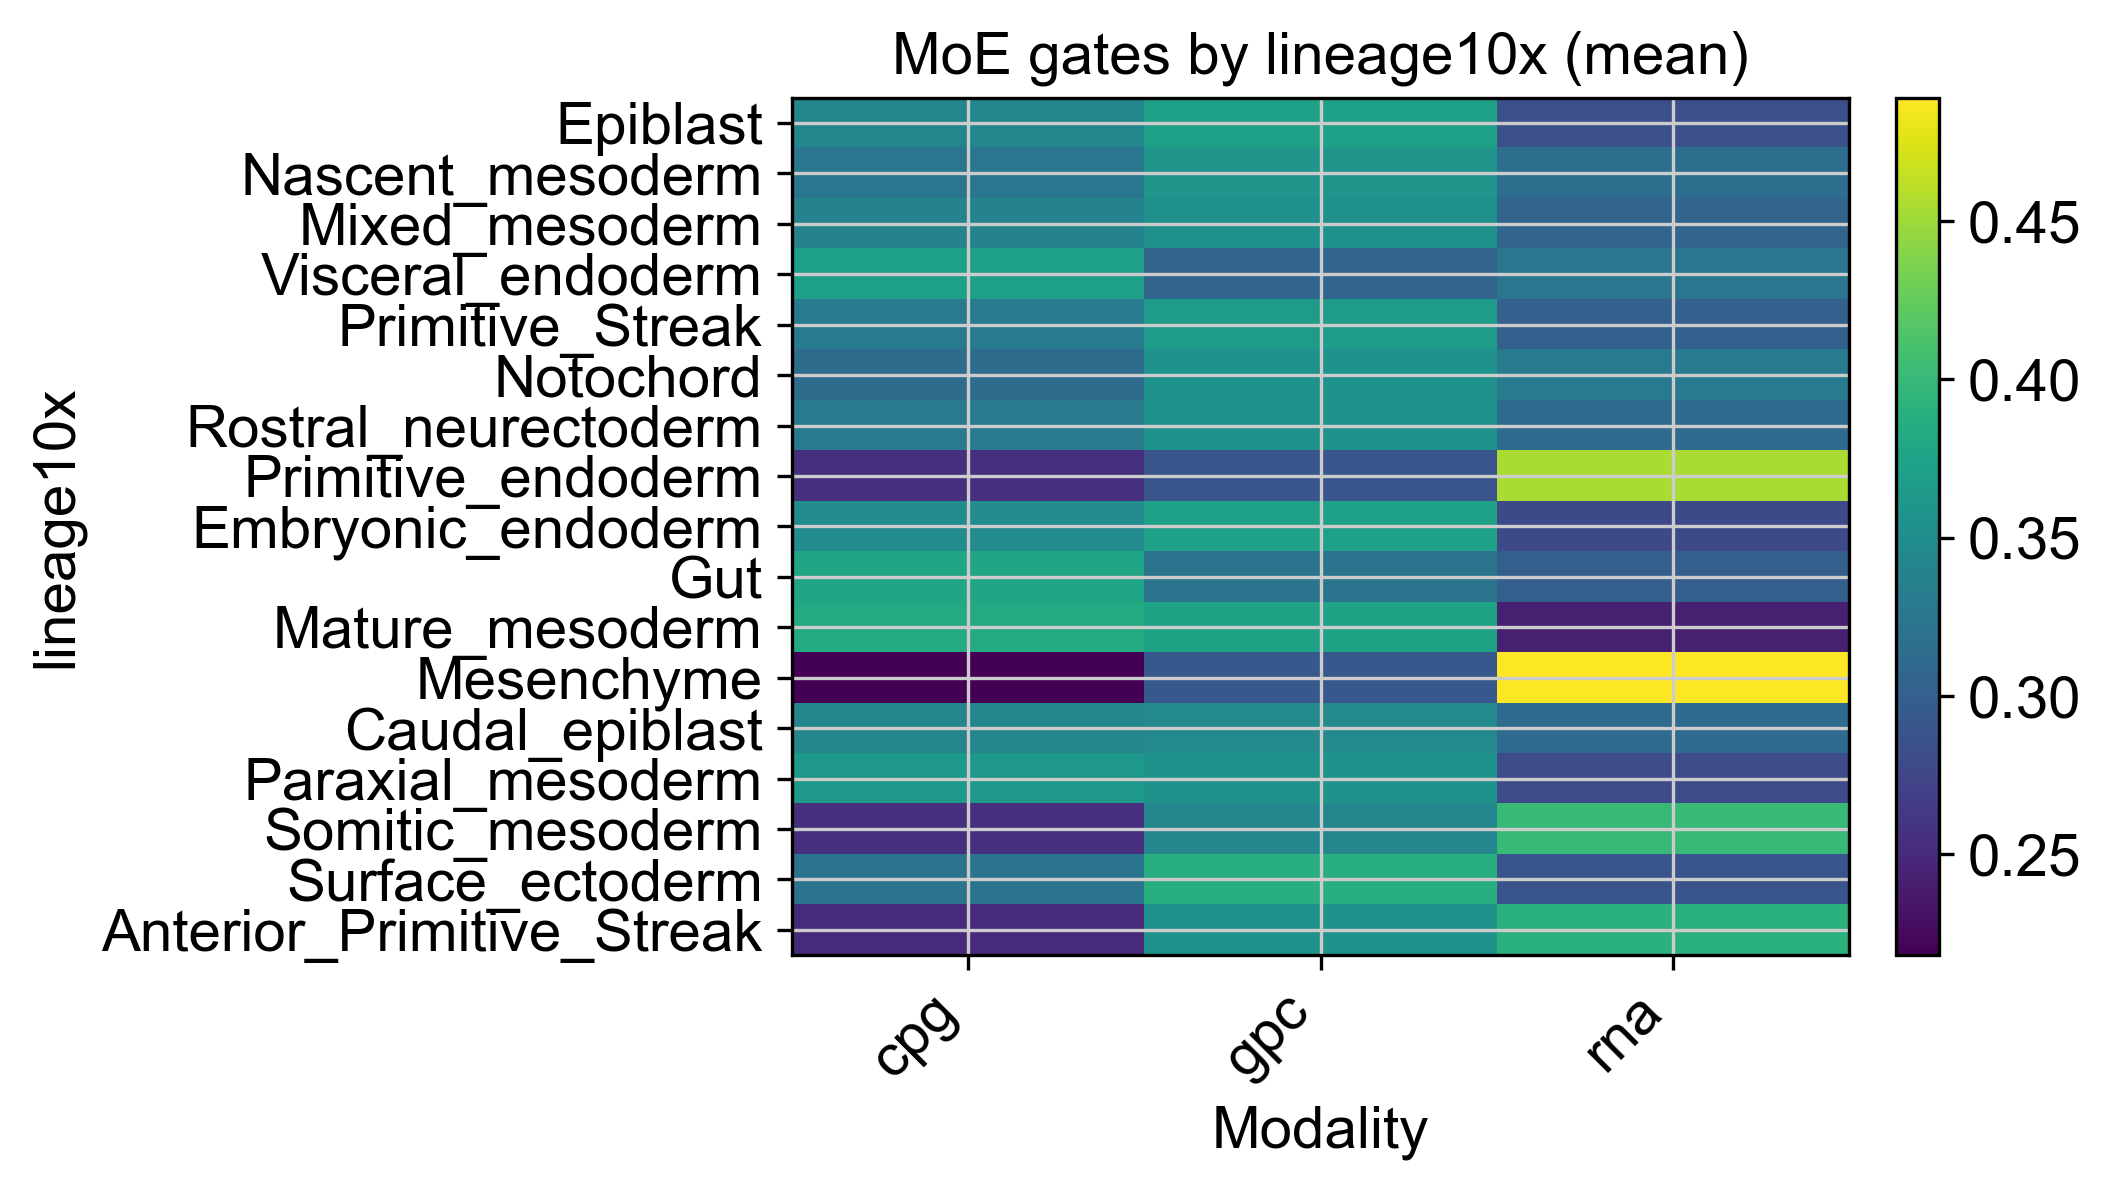

In [169]:
plot_moe_gate_summary(
    rna_test,
    gate_prefix="moe_gate",
    groupby="lineage10x",
    agg="mean",
    #savepath="moe_gates_by_celltype.png",
    show=True,
)


Evaluate using all data rather than just the test set:

fused keys: ['mu', 'logvar', 'Z_fused', 'gates', 'gate_logits', 'modality_order']
Z_fused shape: (1140, 30)


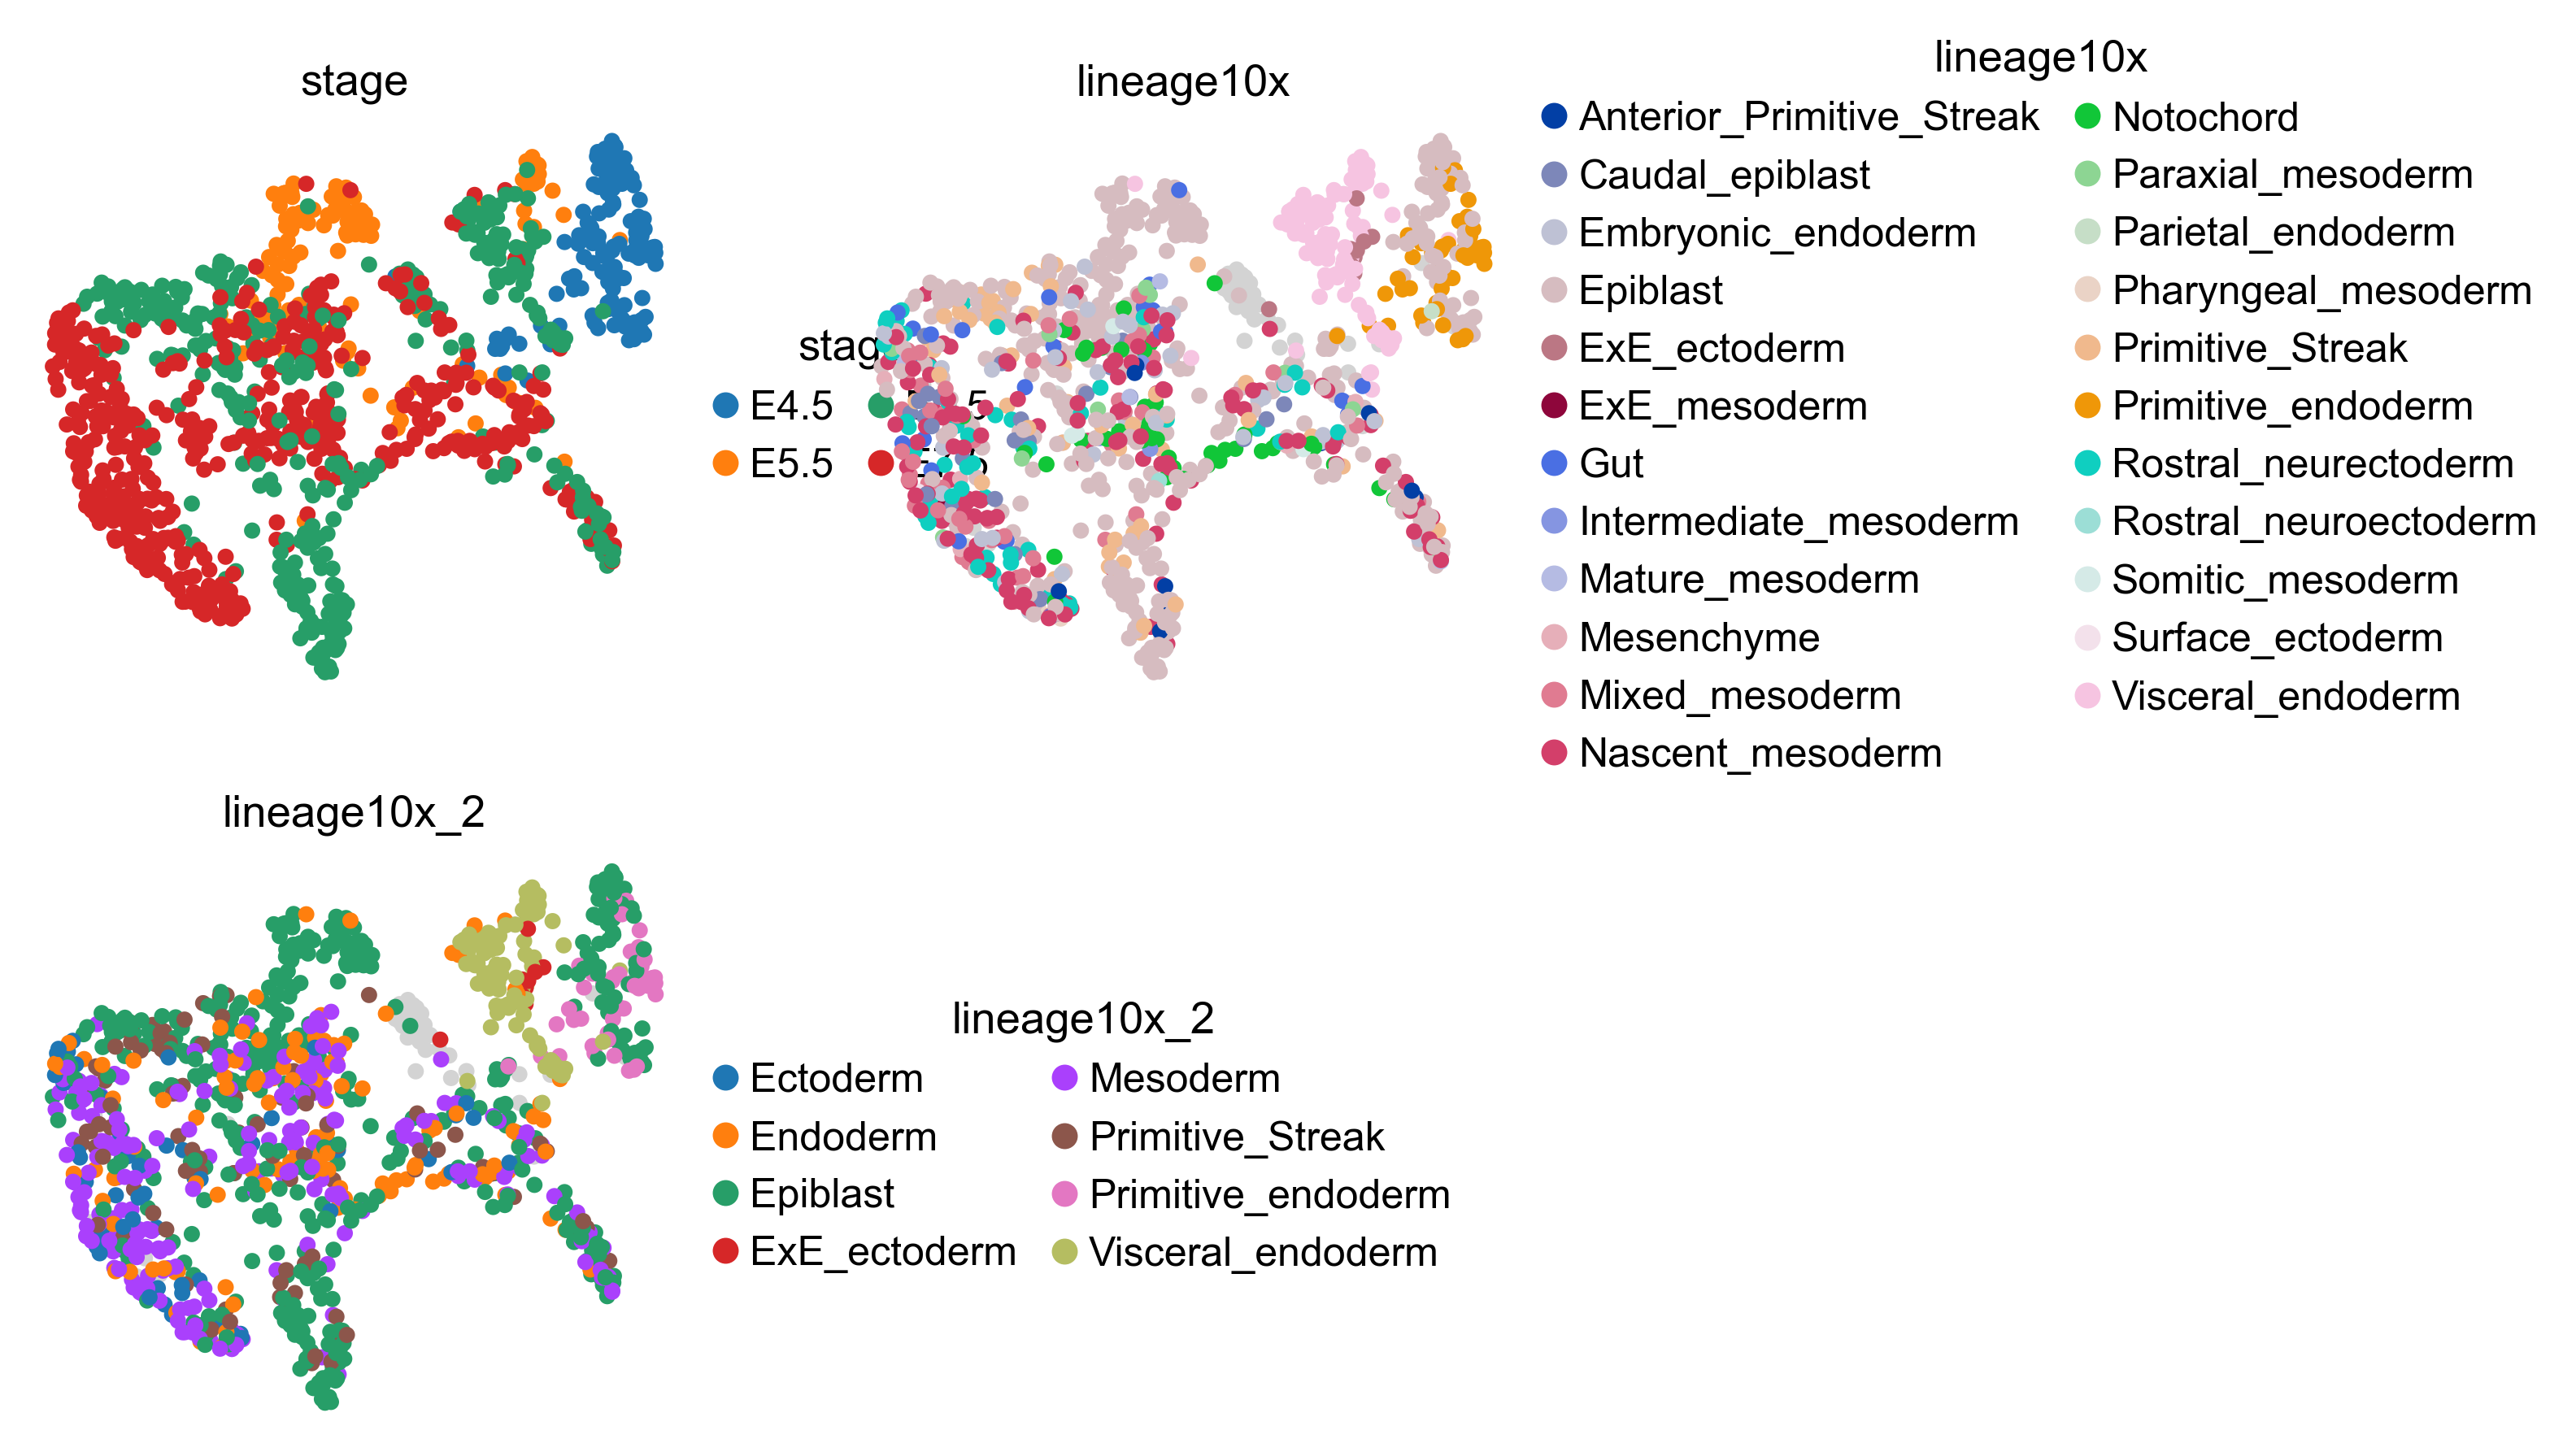

In [170]:
# =========================================================
# 17) Encode fused latent + UMAP (tri-modal)
# =========================================================
from univi.evaluation import encode_fused_adata_pair, encode_adata
from univi.plotting import set_style, umap

set_style(font_scale=1.1, dpi=140)

# Subset to test cells for inductive eval if desired
#rna_test = adata_dict["rna"][test_idx].copy()
#cpg_test = adata_dict["cpg"][test_idx].copy()
#gpc_test = adata_dict["gpc"][test_idx].copy()

rna_test = adata_dict["rna"].copy()
cpg_test = adata_dict["cpg"].copy()
gpc_test = adata_dict["gpc"].copy()

assert np.array_equal(rna_test.obs_names, cpg_test.obs_names)
assert np.array_equal(rna_test.obs_names, gpc_test.obs_names)

# Fused encoding across all 3 modalities
fused = encode_fused_adata_pair(
    model,
    adata_by_mod={"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    device=device,
    batch_size=512,
    use_mean=True,
    return_gates=True,
    return_gate_logits=True,
    write_to_adatas=True,
    fused_obsm_key="X_univi_fused",
    gate_prefix="gate",
)

print("fused keys:", list(fused.keys()))
print("Z_fused shape:", None if "Z_fused" not in fused else fused["Z_fused"].shape)

# Plot on one modality object (same cells/order)
color_cols = [c for c in ["stage", "lineage10x", "lineage10x_2"] if c in rna_test.obs.columns]
if len(color_cols) == 0:
    color_cols = None

umap(
    rna_test,
    obsm_key="X_univi_fused",
    color=color_cols,
    legend="outside",
    show=True,
)


Stored imputed layers:
cpg: KeysView(Layers with keys: meth_successes, meth_total_count, imputed_from_rna)
gpc: KeysView(Layers with keys: acc_successes, acc_total_count, imputed_from_rna)
CpG (RNA->CpG) MSE mean: 0.16223567724227905
CpG (RNA->CpG) Pearson mean: 0.32414141297340393
Latent shapes:
  RNA: (1140, 30)
  CpG: (1140, 30)
  GpC: (1140, 30)
RNA -> CpG summary:
{'mse_mean': 0.16223567724227905, 'mse_median': 0.13432300090789795, 'pearson_mean': 0.32414141297340393, 'pearson_median': 0.32823389768600464, 'per_cell_mean': 0.16223569214344025}


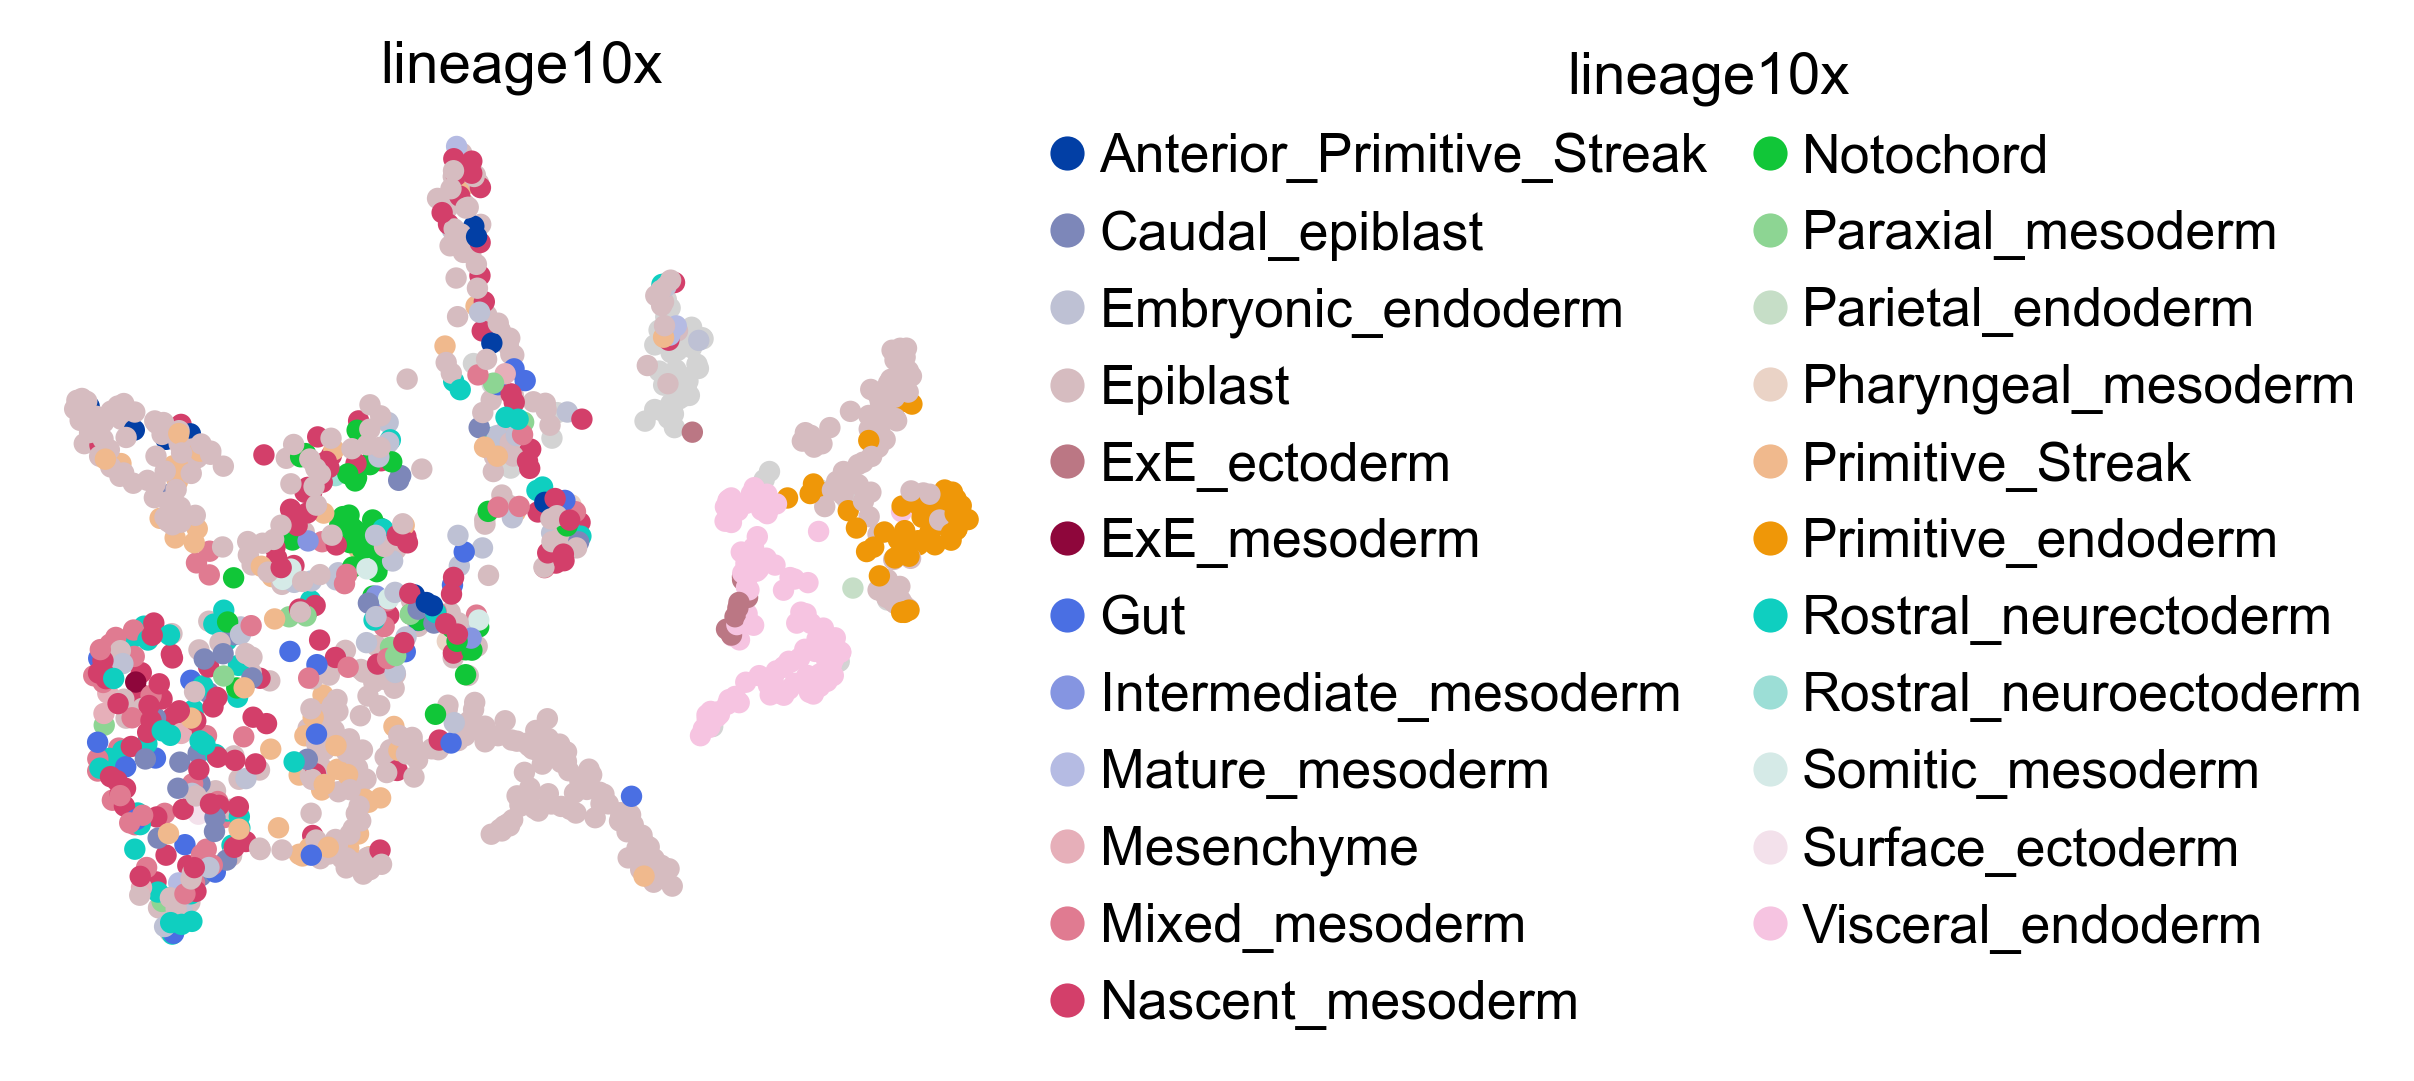

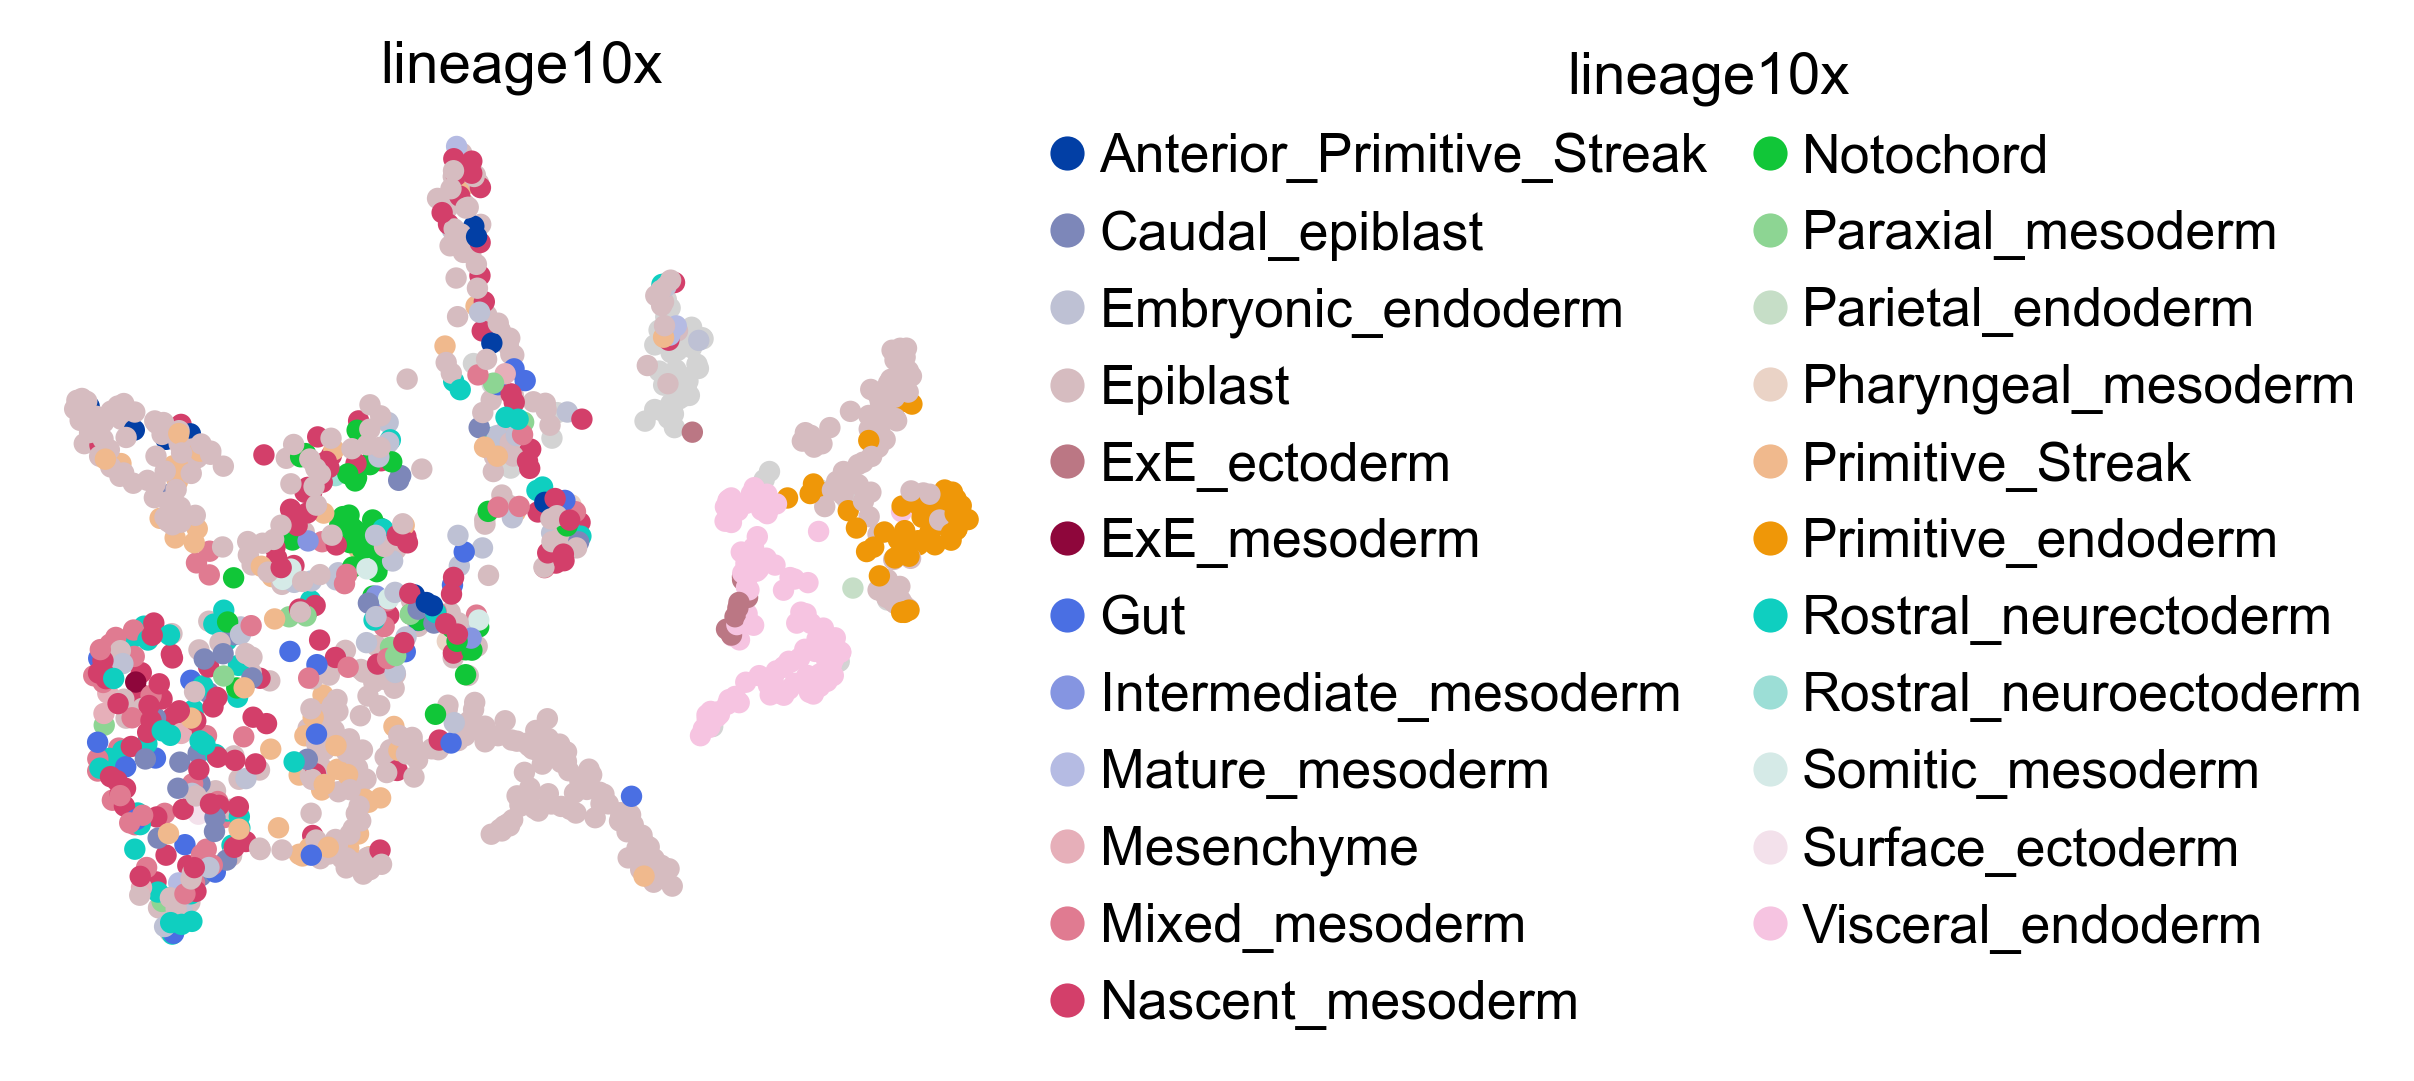

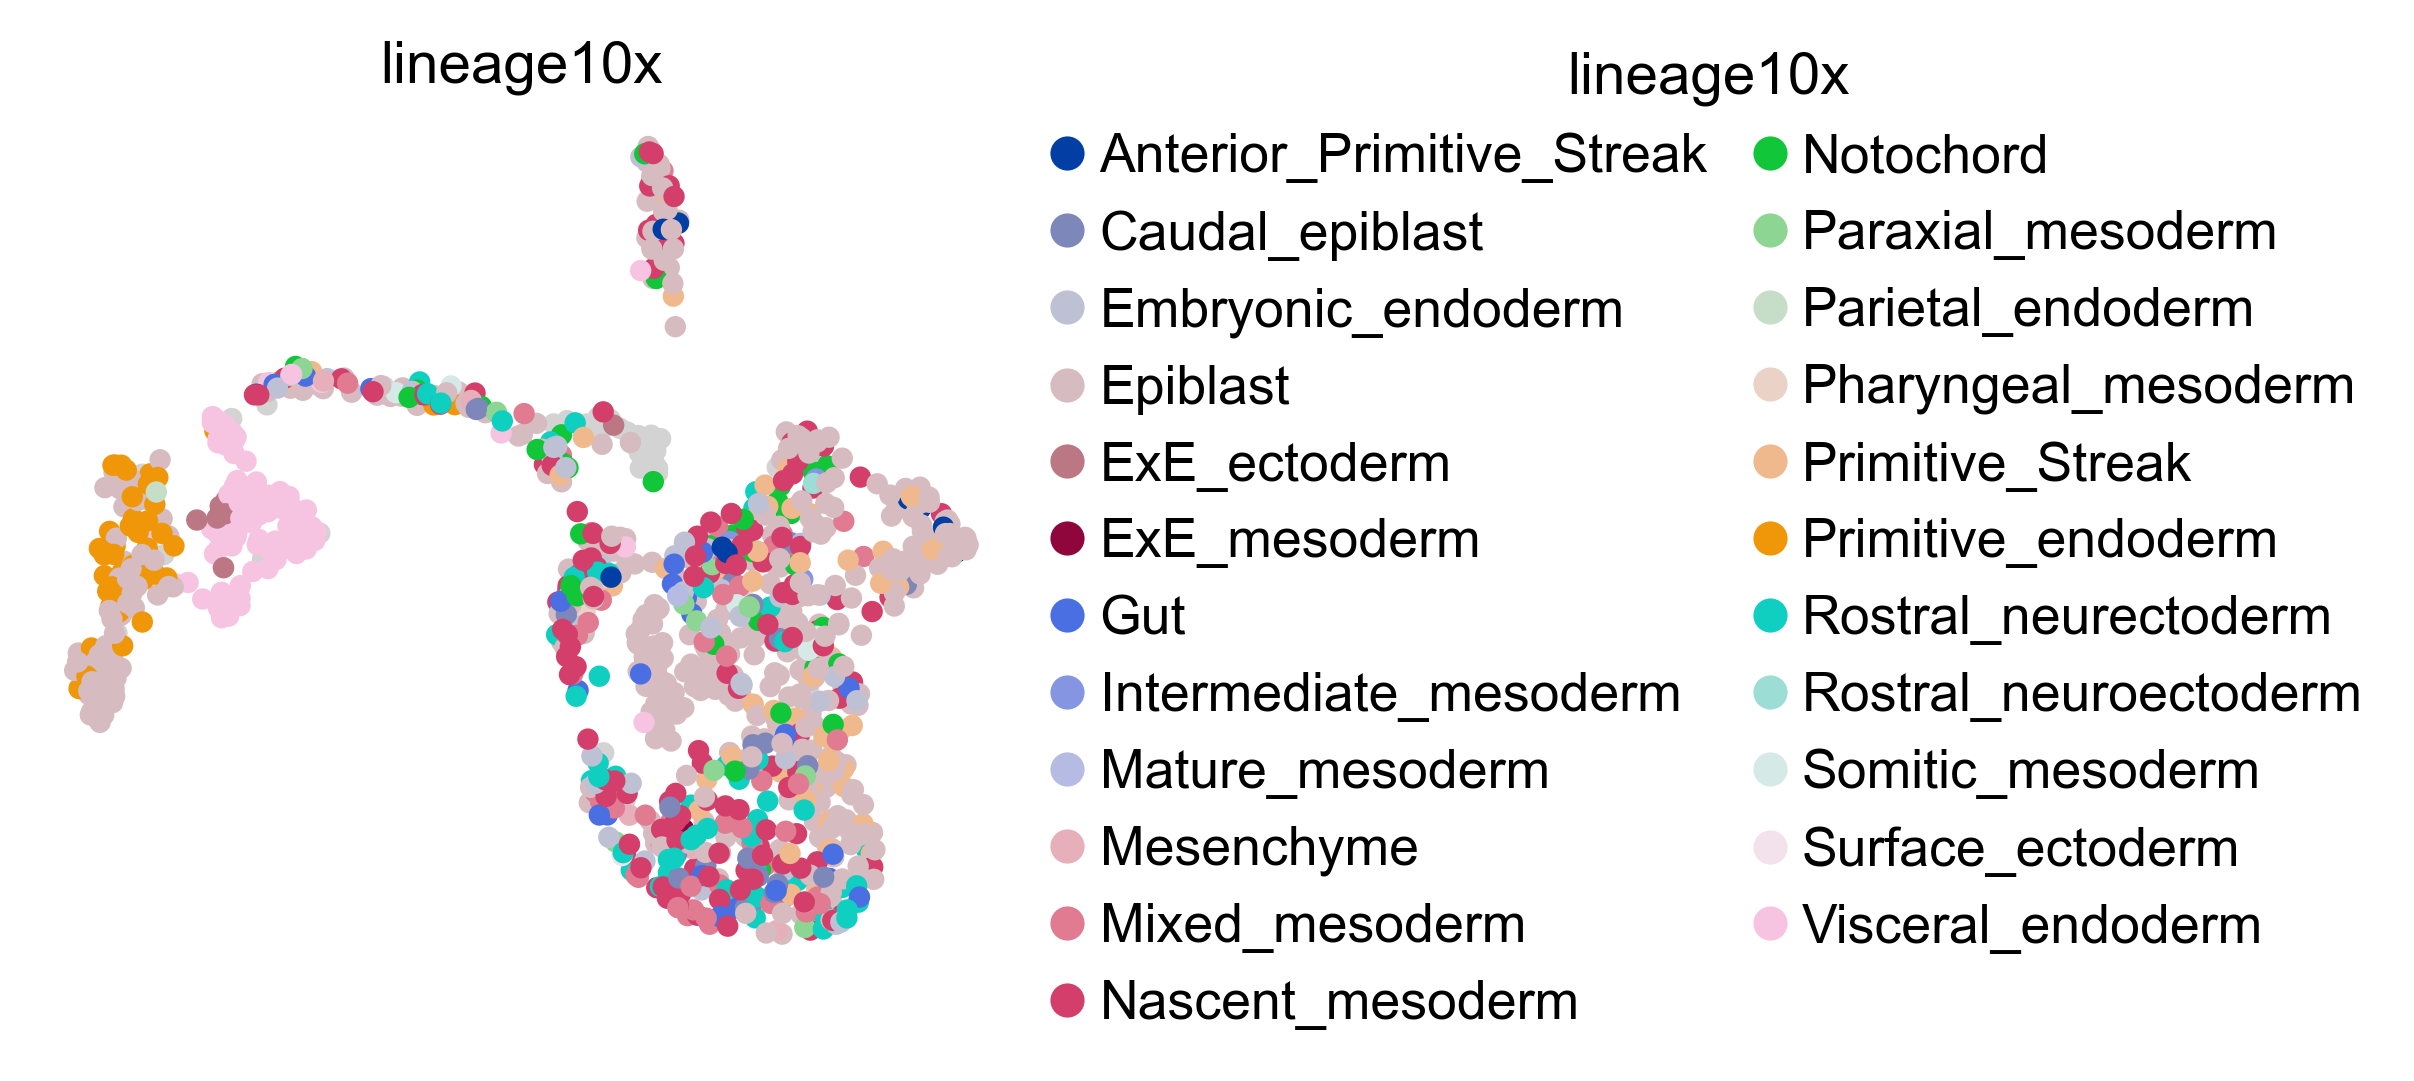

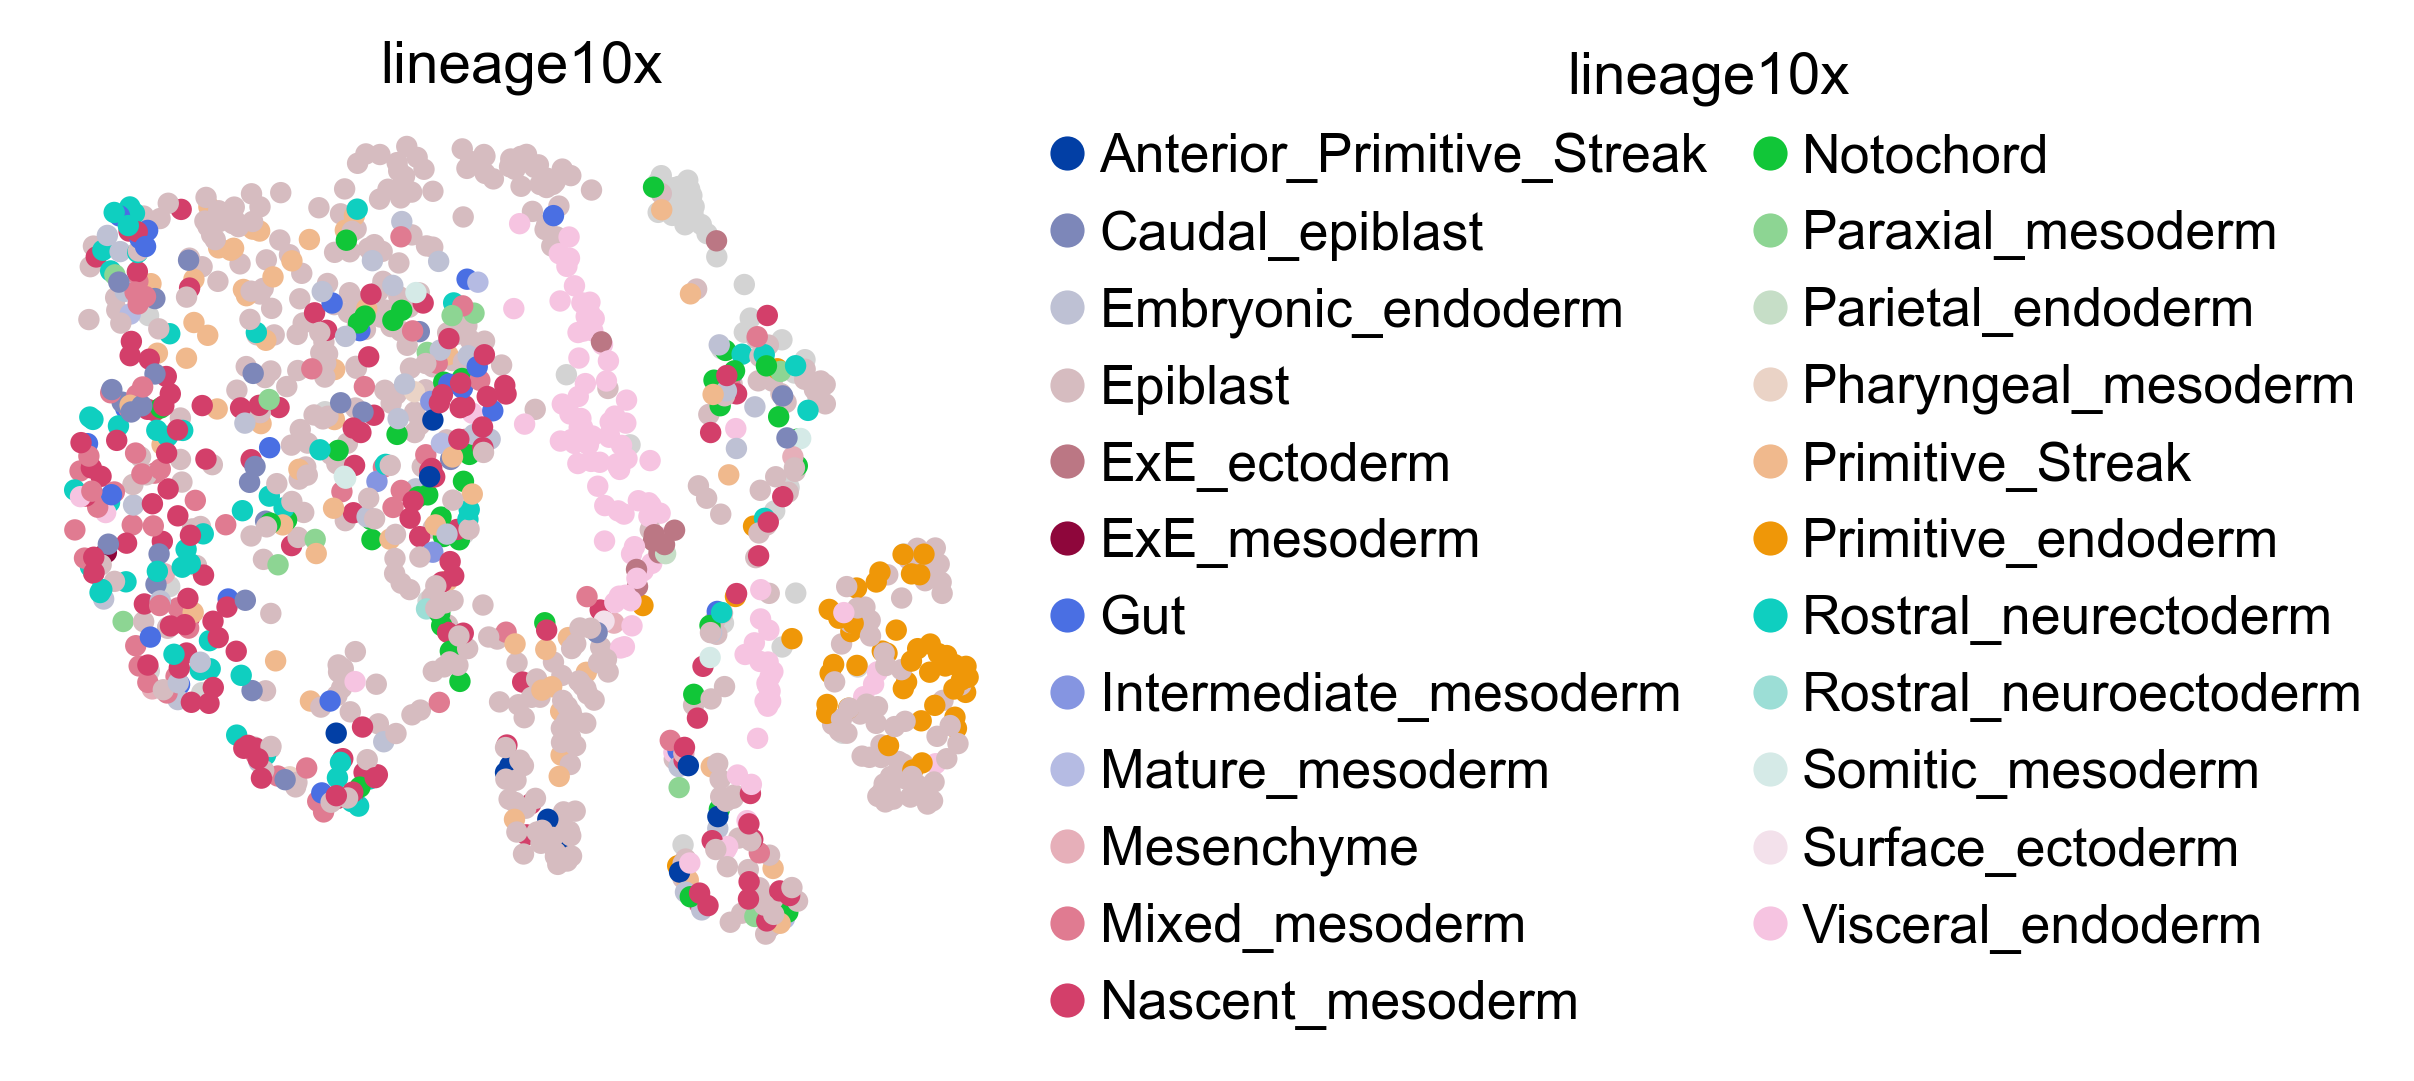

dict_keys(['mu', 'logvar', 'Z_fused', 'gates', 'gate_logits', 'modality_order'])
Z_fused shape: (1140, 30)
{'metric': 'euclidean', 'n_cells': 1140, 'foscttm_mean': 0.042927005887235796, 'foscttm_sem': 0.0034980581867293243, 'recall_at_k': {'1': {'mean': 0.16140350877192983, 'sem': 0.010901120599018497}, '5': {'mean': 0.45, 'sem': 0.014740959045235485}, '10': {'mean': 0.5885964912280702, 'sem': 0.014580787078781592}}, 'modality_mixing_mean': 0.26995614035087717, 'modality_mixing_sem': 0.004760336314984282, 'modality_entropy_mean': 0.6156454174142135, 'modality_entropy_sem': 0.00823024413264165, 'k_mixing': 8, 'k_entropy': 8}
cpg_hat_from_rna shape: (1140, 18285)


/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


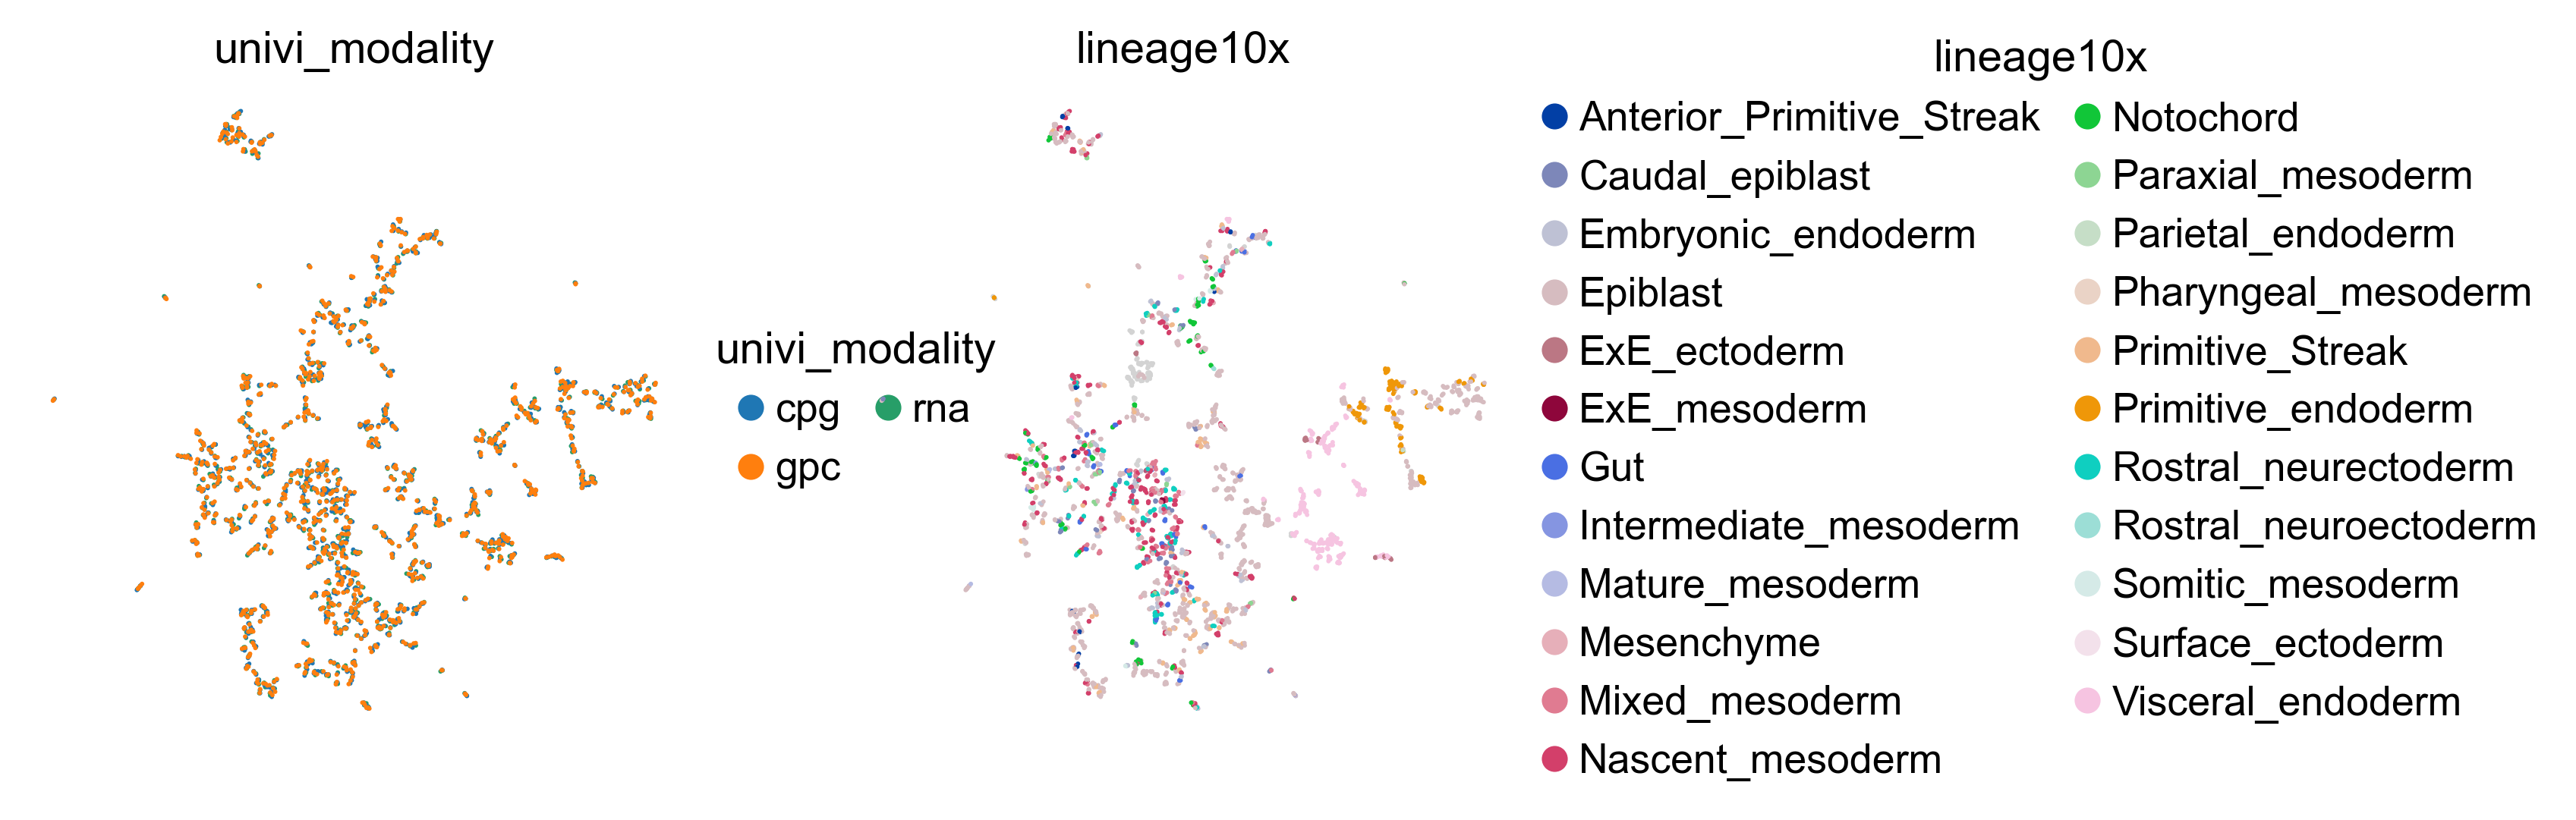

/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


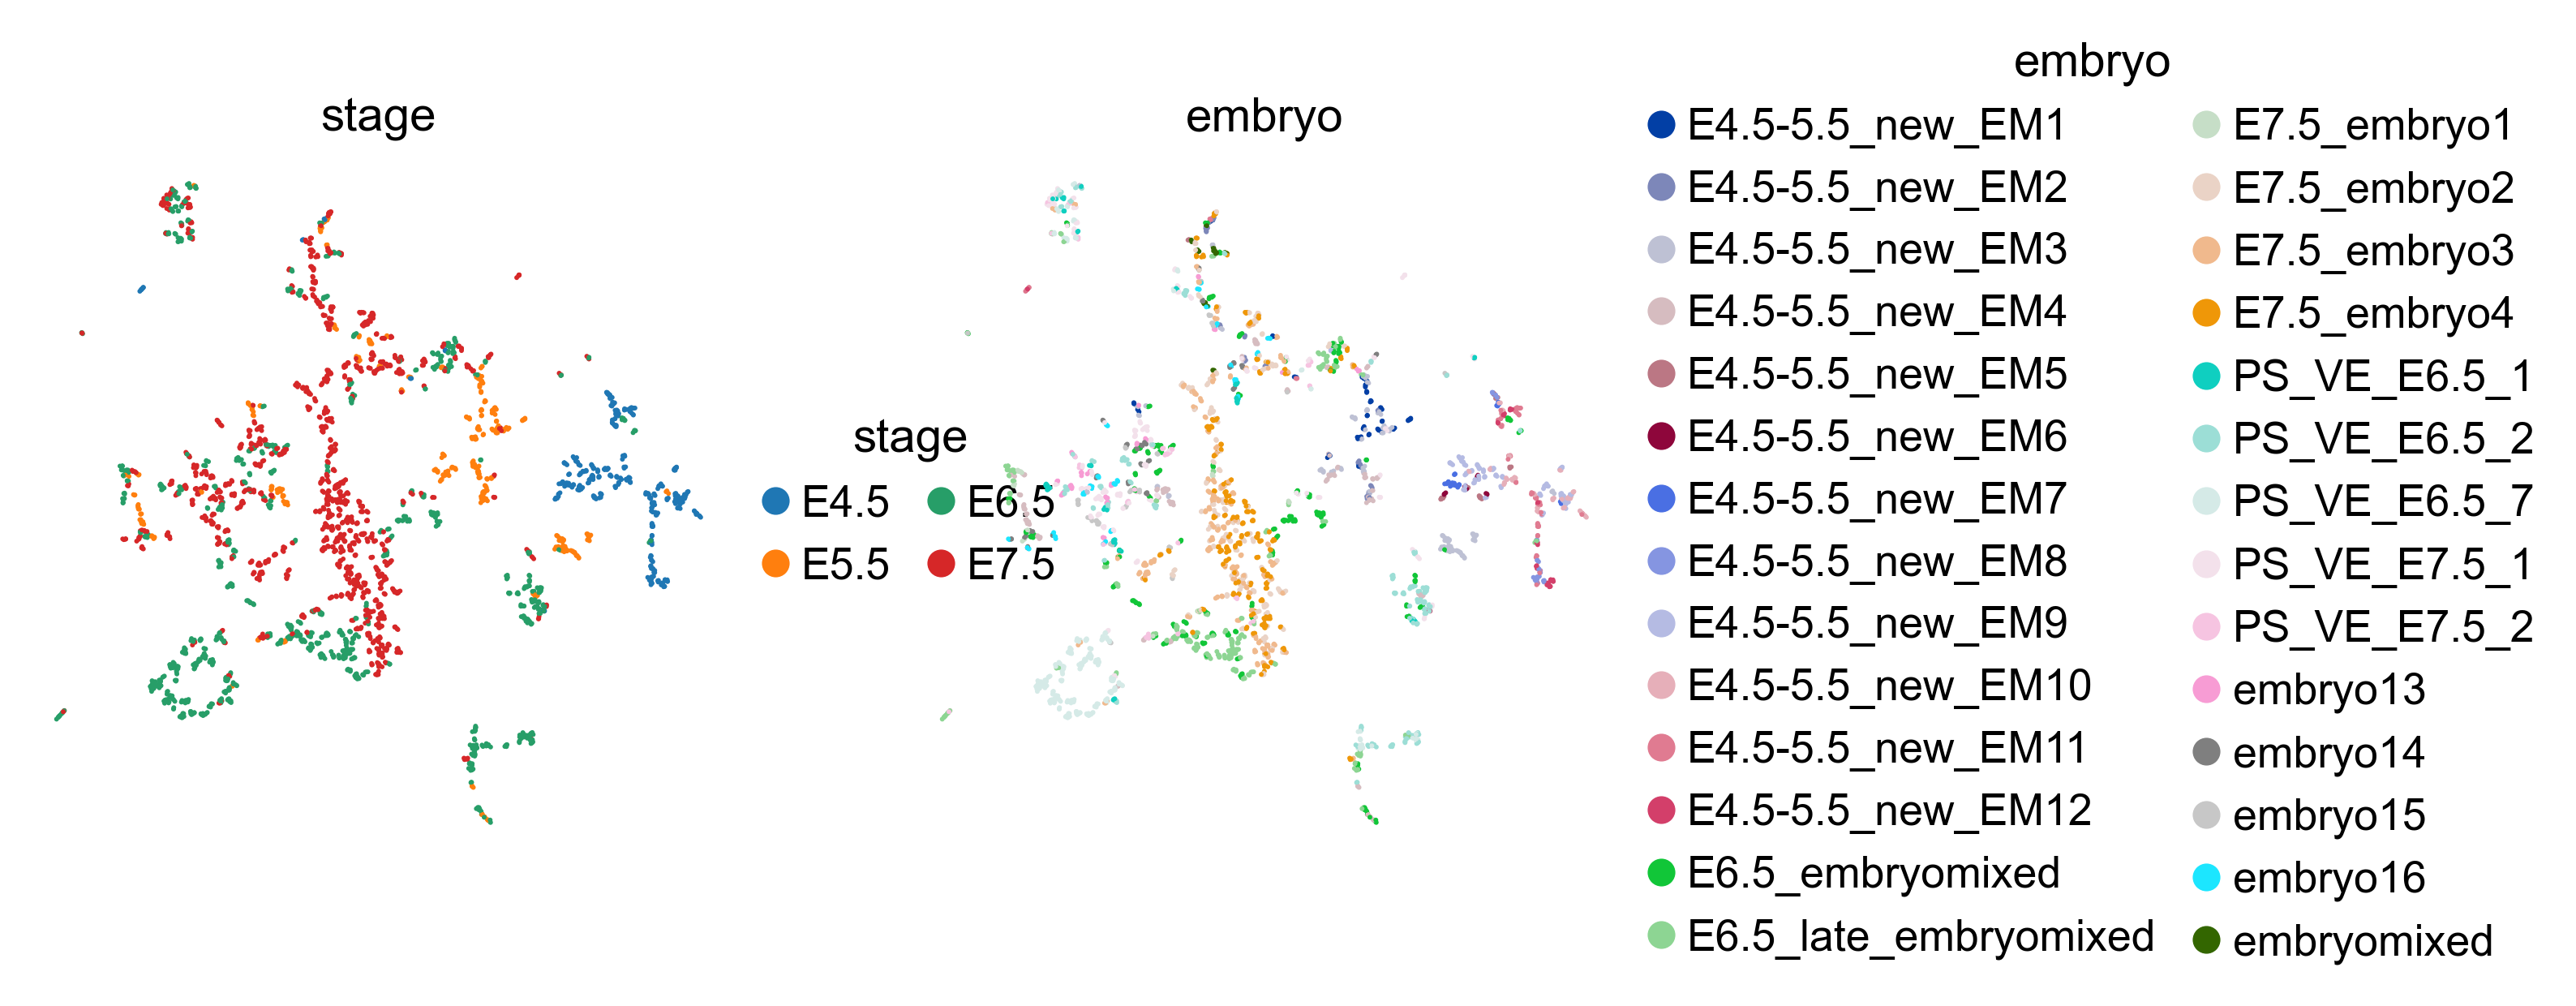

MSE mean: 0.16223567724227905
Pearson mean: 0.32414141297340393
{'mse_mean': 0.16223567724227905, 'mse_median': 0.13432300090789795, 'pearson_mean': 0.32414141297340393, 'pearson_median': 0.32823386788368225, 'per_cell_mean': 0.16223567724227905}


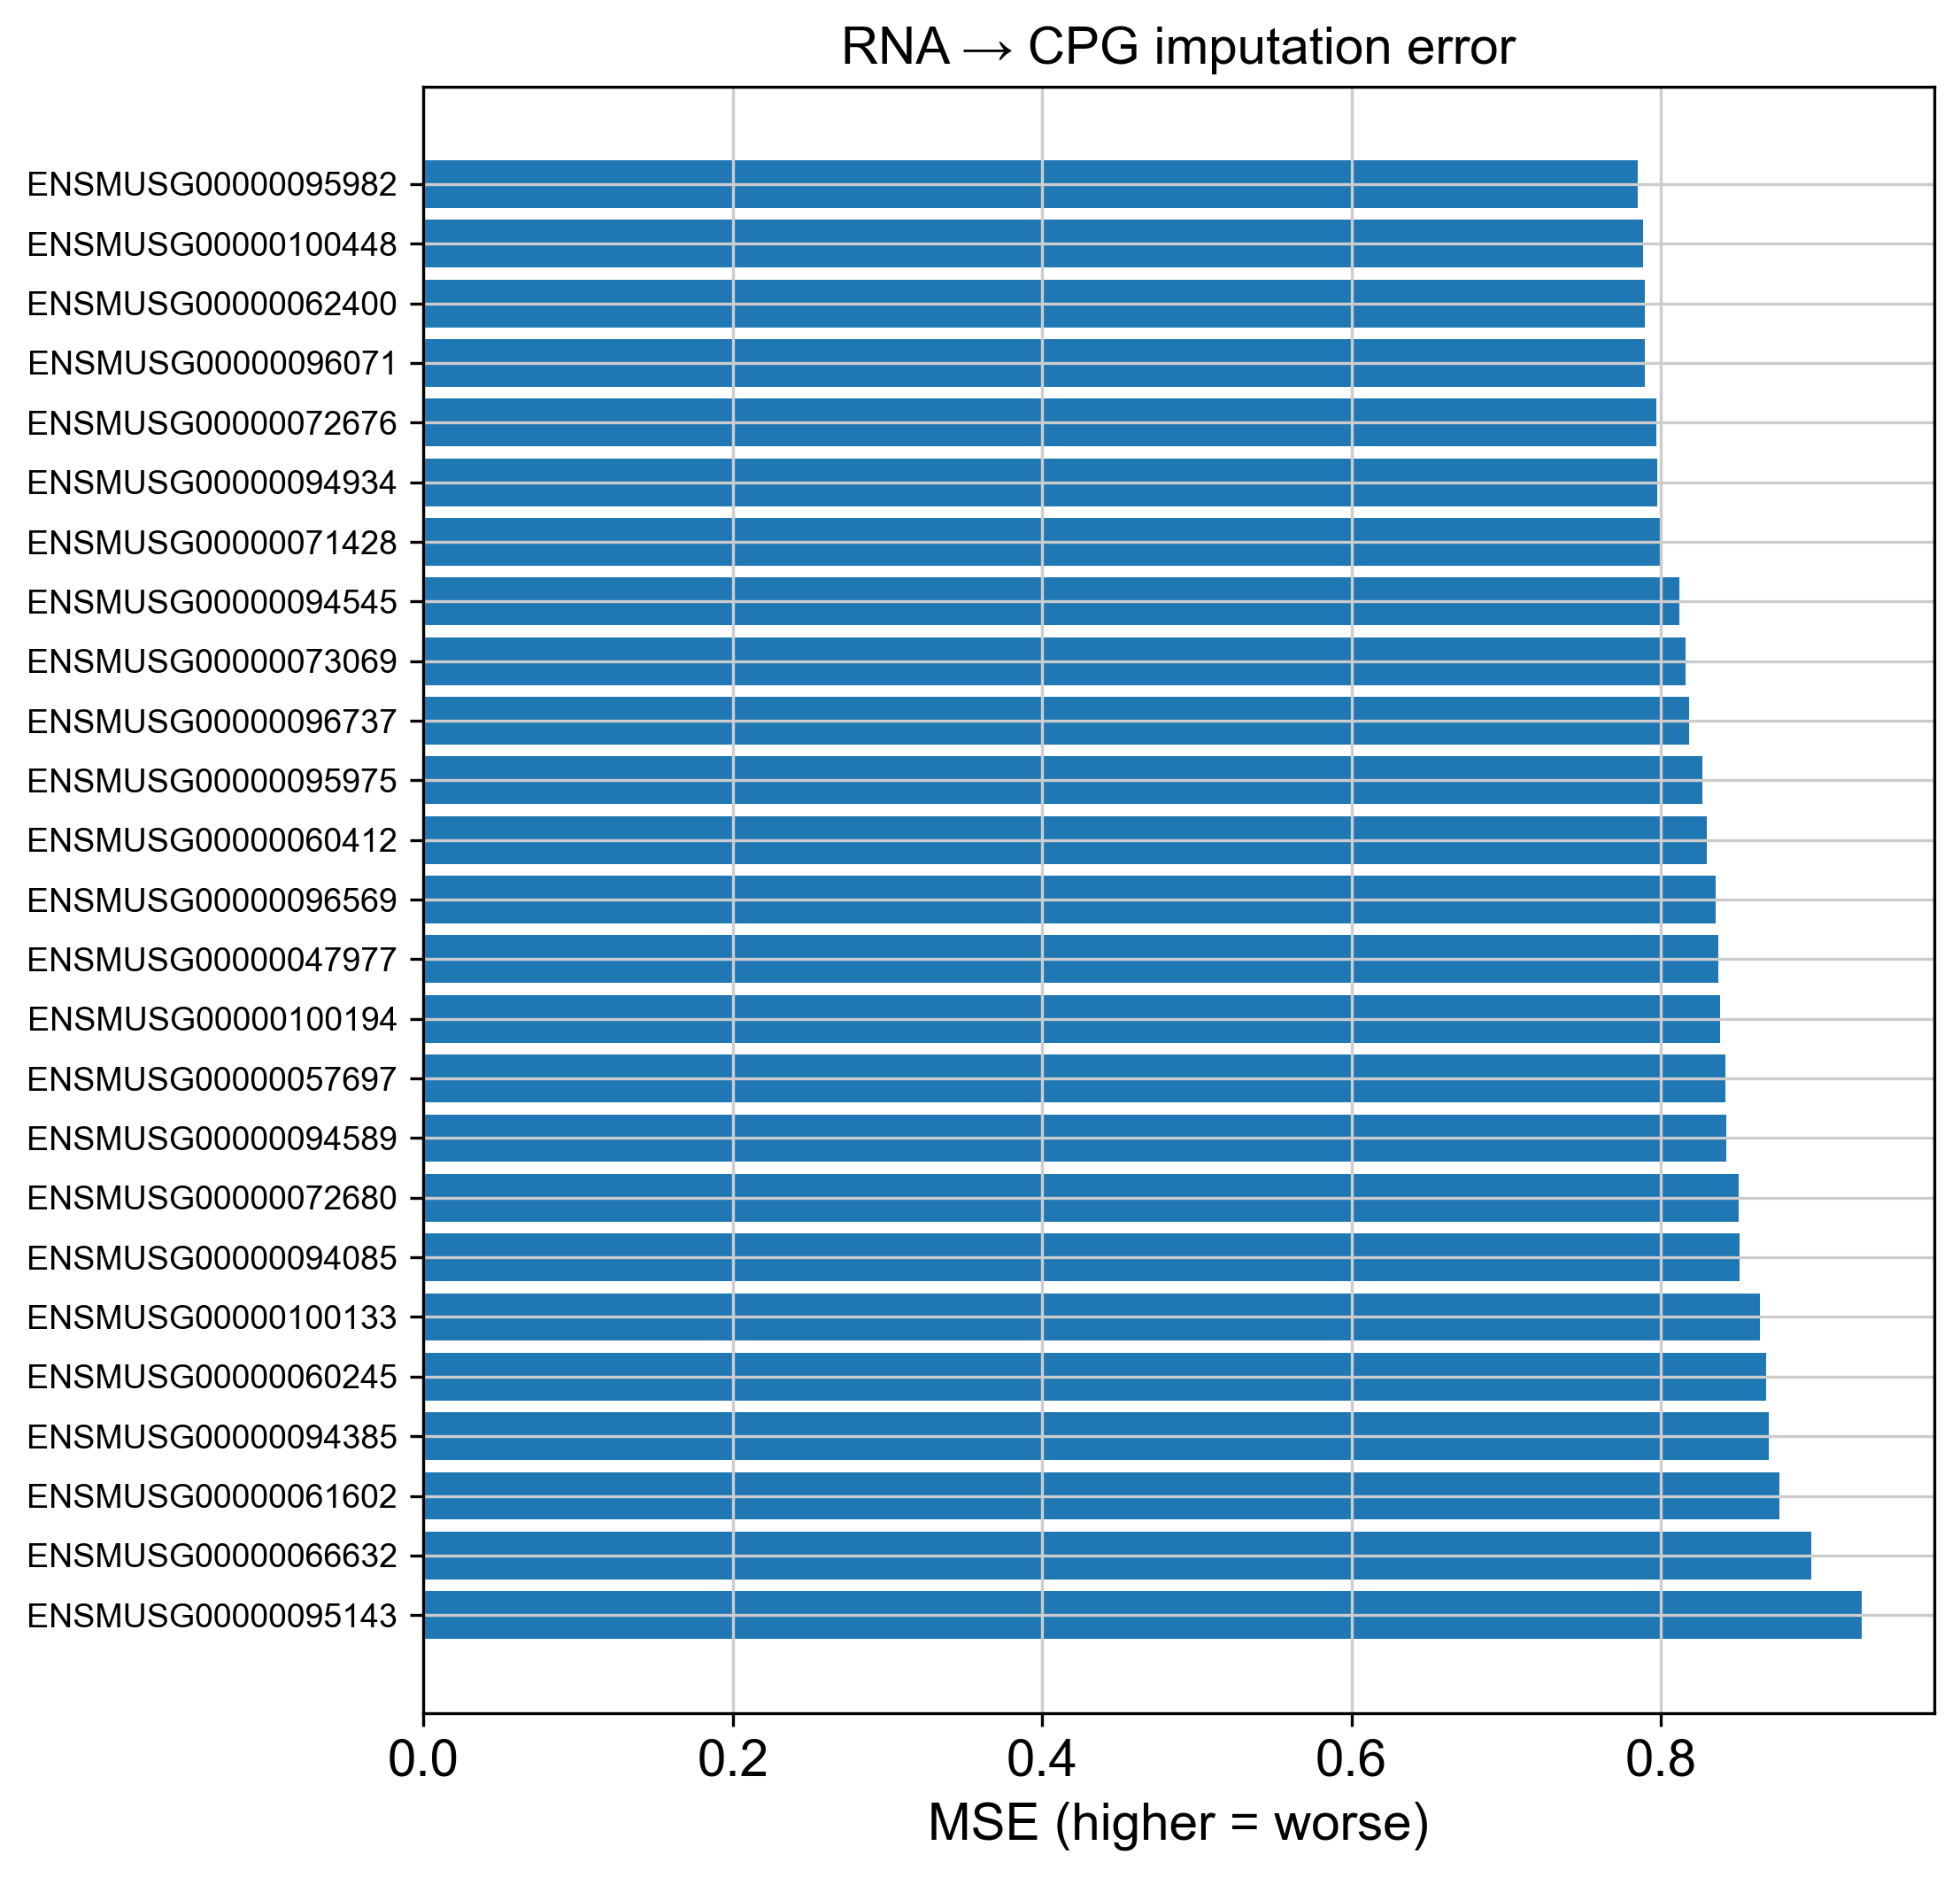

Requested kind: router_x_precision
Effective kind: router_x_precision
Per-modality mean: {'rna': 0.3217892348766327, 'cpg': 0.33197882771492004, 'gpc': 0.3462319076061249}
Has logits: True


/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/univi/plotting.py:619: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = df.groupby(groupby)[cols].mean()


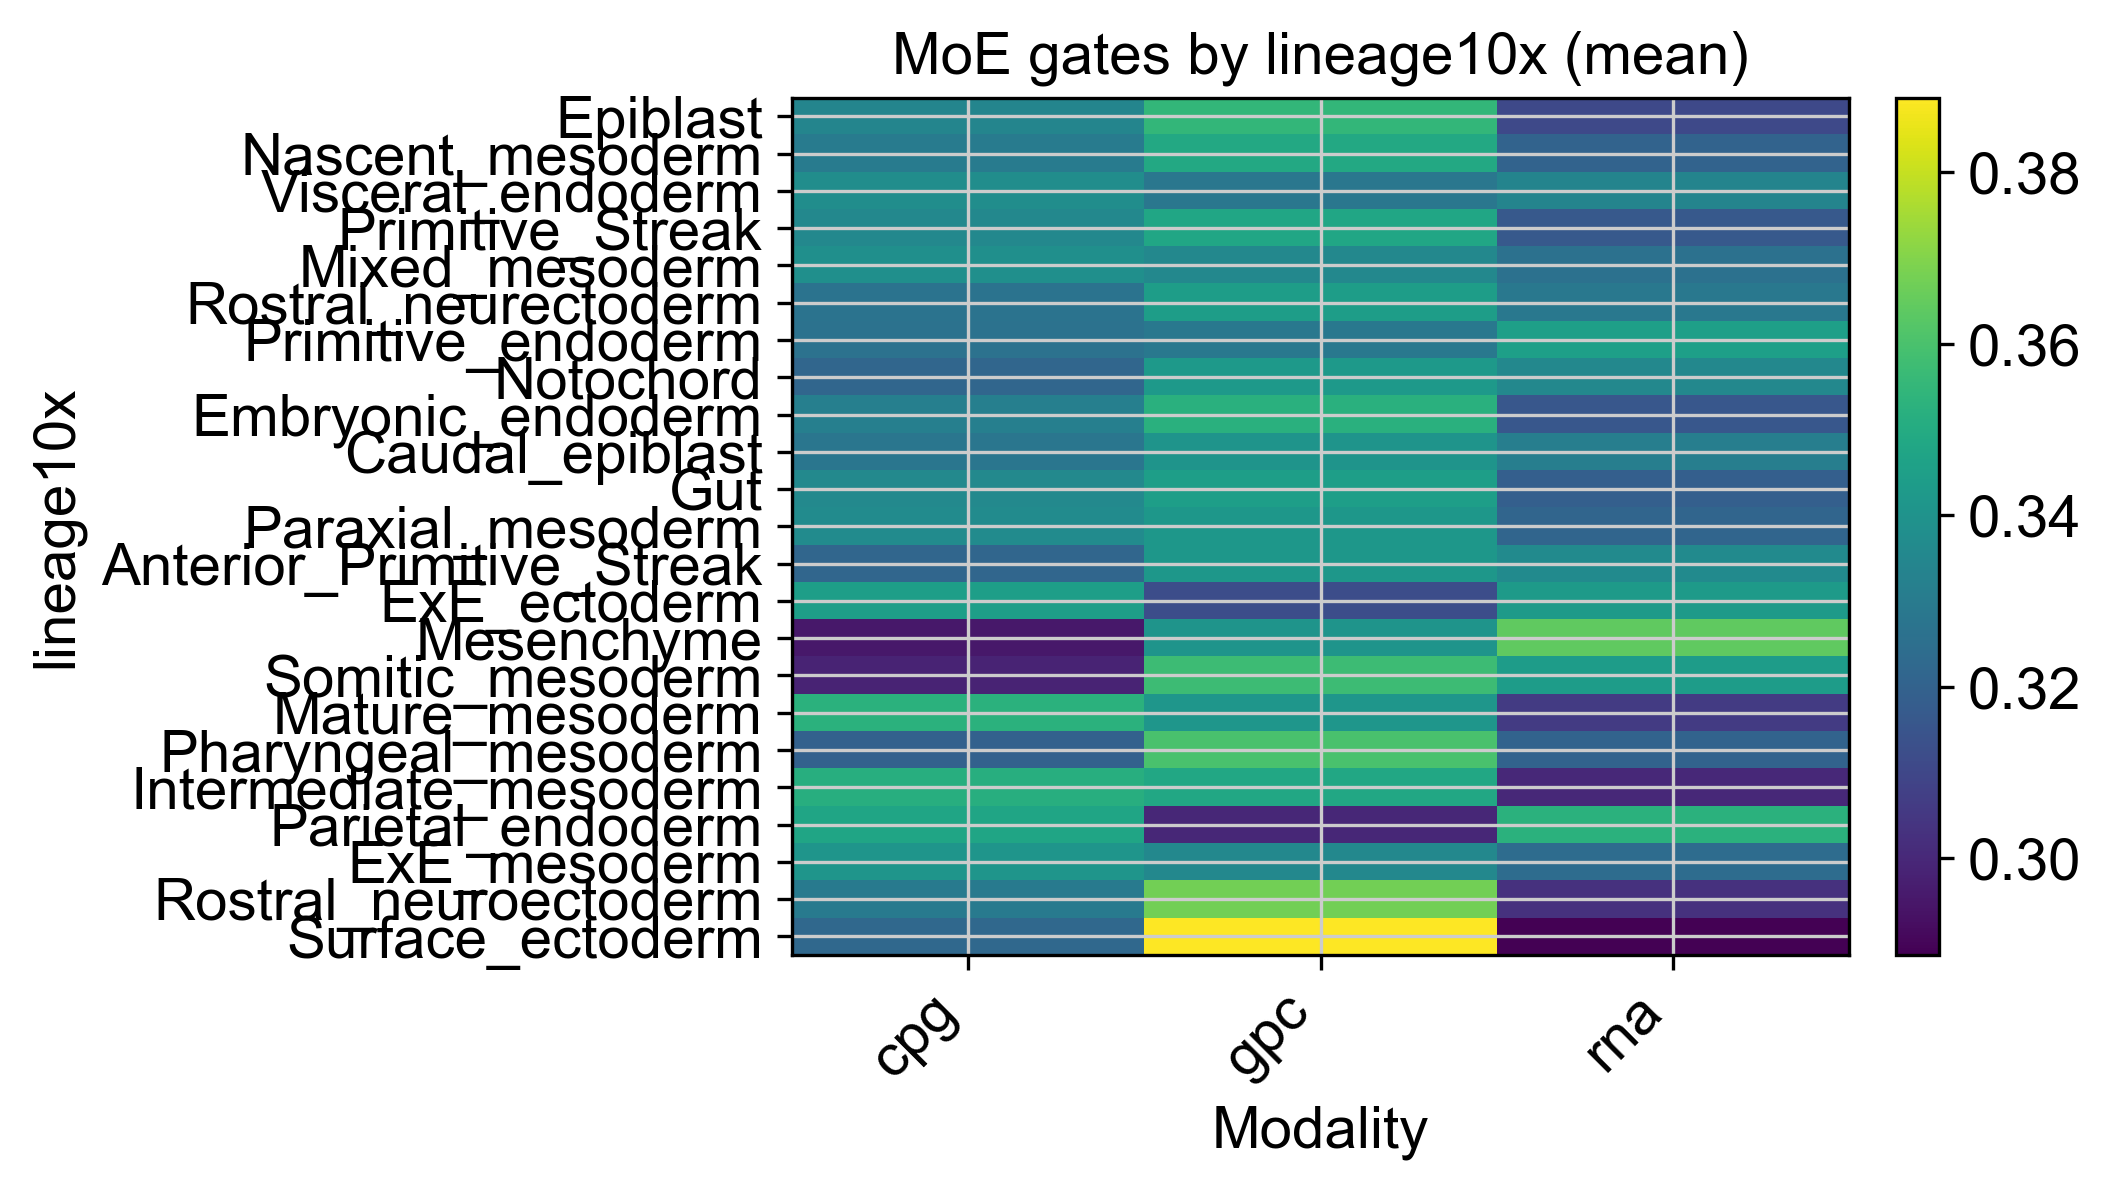

In [171]:
# =========================================================
# 18) Optional cross-modal prediction examples
# =========================================================
from univi.evaluation import cross_modal_predict, evaluate_cross_reconstruction, reconstruction_metrics

# RNA -> CpG
cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    layer=None,
    X_key="X",
    batch_size=256,
    use_moe=True,
)
cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna

# RNA -> GpC
gpc_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="gpc",
    device=device,
    layer=None,
    X_key="X",
    batch_size=256,
    use_moe=True,
)
gpc_test.layers["imputed_from_rna"] = gpc_hat_from_rna

print("Stored imputed layers:")
print("cpg:", cpg_test.layers.keys())
print("gpc:", gpc_test.layers.keys())


# =========================================================
# 19) Quick evaluation helpers
# =========================================================
def to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)

# Example: compare predicted CpG fractions vs observed CpG fractions on test cells
true_cpg = to_dense(cpg_test.X)
pred_cpg = to_dense(cpg_test.layers["imputed_from_rna"])

# If dimensions match:
if true_cpg.shape == pred_cpg.shape:
    from univi.evaluation import reconstruction_metrics
    rep = reconstruction_metrics(true_cpg, pred_cpg)
    print("CpG (RNA->CpG) MSE mean:", rep.get("mse_mean"))
    print("CpG (RNA->CpG) Pearson mean:", rep.get("pearson_mean"))
else:
    print("Shape mismatch:", true_cpg.shape, pred_cpg.shape)
    

from univi.evaluation import encode_adata, cross_modal_predict, evaluate_cross_reconstruction

#rna_test = adata_dict["rna"][test_idx].copy()
#cpg_test = adata_dict["cpg"][test_idx].copy()
#gpc_test = adata_dict["gpc"][test_idx].copy()
#rna_test = adata_dict["rna"].copy()
#cpg_test = adata_dict["cpg"].copy()
#gpc_test = adata_dict["gpc"].copy()

# Encode single-modality latents
rna_test.obsm["X_univi"] = encode_adata(
    model, rna_test, modality="rna", device=device, batch_size=512, latent="moe_mean"
)
cpg_test.obsm["X_univi"] = encode_adata(
    model, cpg_test, modality="cpg", device=device, batch_size=512, latent="moe_mean"
)
gpc_test.obsm["X_univi"] = encode_adata(
    model, gpc_test, modality="gpc", device=device, batch_size=512, latent="moe_mean"
)

print("Latent shapes:")
print("  RNA:", rna_test.obsm["X_univi"].shape)
print("  CpG:", cpg_test.obsm["X_univi"].shape)
print("  GpC:", gpc_test.obsm["X_univi"].shape)

# Cross-modal prediction: RNA -> CpG
cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    batch_size=256,
    use_moe=True,
)
cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna

rep_rna_to_cpg = evaluate_cross_reconstruction(
    model,
    adata_src=rna_test,
    adata_tgt=cpg_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    batch_size=256,
)
print("RNA -> CpG summary:")
print(rep_rna_to_cpg["summary"])


from univi.plotting import set_style, umap

set_style(font_scale=1.1, dpi=150)

# make UMAP on RNA latent
sc.pp.neighbors(rna_test, use_rep="X_univi")
sc.tl.umap(rna_test)

umap(
    rna_test,
    obsm_key="X_univi",
    color="lineage10x",
    legend="outside",
    show=True,
)


umap(
    rna_test,
    obsm_key="X_univi",
    color=["lineage10x"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    show=True,
)


umap(
    cpg_test,
    obsm_key="X_univi",
    color=["lineage10x"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    show=True,
)


umap(
    gpc_test,
    obsm_key="X_univi",
    color=["lineage10x"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    show=True,
)


from univi.evaluation import encode_fused_adata_pair

# despite the name, it accepts adata_by_mod with multiple modalities in your README examples
fused = encode_fused_adata_pair(
    model,
    adata_by_mod={"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    device=device,
    batch_size=256,
    use_mean=True,
    return_gates=True,
    return_gate_logits=True,
    write_to_adatas=True,
    fused_obsm_key="X_univi_fused",
    gate_prefix="gate",
)

print(fused.keys())
print("Z_fused shape:", fused["Z_fused"].shape)


from univi.evaluation import evaluate_alignment

# RNA vs CpG alignment in latent
metrics_rna_cpg = evaluate_alignment(
    Z1=rna_test.obsm["X_univi"],
    Z2=cpg_test.obsm["X_univi"],
    metric="euclidean",
    recall_ks=(1, 5, 10),
    k_mixing=8,
    k_entropy=8,
    json_safe=True,
)
print(metrics_rna_cpg)


from univi.evaluation import cross_modal_predict

cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    X_key="X",
    batch_size=128,
    use_moe=True,
)

# Store as an imputed layer (mean-like output from decoder utility)
cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna
print("cpg_hat_from_rna shape:", np.asarray(cpg_hat_from_rna).shape)


import numpy as np
import scipy.sparse as sp
import torch

from univi.evaluation import (
    encode_adata,
    encode_fused_adata_pair,
    cross_modal_predict,
    denoise_adata,
    denoise_from_multimodal,
    evaluate_alignment,
    reconstruction_metrics,
    # NEW (generation + recon error workflows)
    generate_from_latent,
    fit_label_latent_gaussians,
    sample_latent_by_label,
    evaluate_cross_reconstruction,
)
from univi.plotting import (
    set_style,
    umap,
    umap_by_modality,
    compare_raw_vs_denoised_umap_features,
    plot_confusion_matrix,
    write_gates_to_obs,
    plot_moe_gate_summary,
    # NEW (reconstruction error plots)
    plot_reconstruction_error_summary,
    plot_featurewise_reconstruction_scatter,
)

set_style(font_scale=1.2, dpi=150)
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")


fused = encode_fused_adata_pair(
    model,
    adata_by_mod={"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    device=device,
    batch_size=8,
    use_mean=True,
    return_gates=True,
    return_gate_logits=True,
    write_to_adatas=True,
    fused_obsm_key="X_univi_fused",
    gate_prefix="gate",
)

# fused["Z_fused"] -> (n_cells, latent_dim)
# fused["gates"]  -> (n_cells, n_modalities) or None (if fused transformer posterior is used)


umap_by_modality(
    {"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    obsm_key="X_univi_fused",
    color=["univi_modality", "lineage10x"],
    legend="outside",
    size=8,
    #savepath="umap_fused_both_modalities.png",
    show=True,
)


umap_by_modality(
    {"rna": rna_test, "cpg": cpg_test, "gpc": gpc_test},
    obsm_key="X_univi_fused",
    color=["stage", "embryo"],
    legend="outside",
    size=8,
    #savepath="umap_fused_both_modalities.png",
    show=True,
)


cpg_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    layer=None,
    X_key="X",
    batch_size=8,
    use_moe=True,
)

cpg_test.layers["imputed_from_rna"] = cpg_hat_from_rna


gpc_hat_from_cpg = cross_modal_predict(
    model,
    adata_src=cpg_test,
    src_mod="cpg",
    tgt_mod="gpc",
    device=device,
    layer=None,
    X_key="X",
    batch_size=8,
    use_moe=True,
)

gpc_test.layers["imputed_from_cpg"] = gpc_hat_from_cpg


rna_hat_from_cpg = cross_modal_predict(
    model,
    adata_src=cpg_test,
    src_mod="cpg",
    tgt_mod="rna",
    device=device,
    layer=None,
    X_key="X",
    batch_size=8,
    use_moe=True,
)

rna_test.layers["imputed_from_cpg"] = rna_hat_from_cpg


true = to_dense(cpg_test.X)
pred = cpg_test.layers["imputed_from_rna"]

m = reconstruction_metrics(true, pred)
print("MSE mean:", m["mse_mean"])
print("Pearson mean:", m["pearson_mean"])


rep = evaluate_cross_reconstruction(
    model,
    adata_src=rna_test,
    adata_tgt=cpg_test,
    src_mod="rna",
    tgt_mod="cpg",
    device=device,
    src_layer=None,
    tgt_layer=None,
    batch_size=8,
    # optionally restrict to a feature subset (e.g., top markers)
    feature_names=None,
)
print(rep["summary"])   # mse_mean/median, pearson_mean/median, etc.


plot_reconstruction_error_summary(
    rep,
    title="RNA → CPG imputation error",
    #savepath="recon_error_summary.png",
    show=True,
)


from univi.evaluation import to_dense, encode_moe_gates_from_tensors
from univi.plotting import write_gates_to_obs, plot_moe_gate_summary

gate = encode_moe_gates_from_tensors(
    model,
    x_dict={"rna": to_dense(rna_test.X), "cpg": to_dense(cpg_test.X), "gpc": to_dense(gpc_test.X)},
    device=device,
    batch_size=8,
    modality_order=["rna", "cpg", "gpc"],
    kind="router_x_precision",  # falls back to "effective_precision" if router logits are unavailable
    return_logits=True,
)

W    = gate["weights"]         # (n_cells, n_modalities), rows sum to 1
mods = gate["modality_order"]  # e.g. ["rna", "adt"]

print("Requested kind:", gate.get("requested_kind"))
print("Effective kind:", gate.get("kind"))
print("Per-modality mean:", gate.get("per_modality_mean"))
print("Has logits:", gate.get("logits") is not None)


write_gates_to_obs(
    rna_test,
    gates=W,
    modality_names=mods,
    gate_prefix="moe_gate",          # creates obs cols: moe_gate_{mod}
    gate_logits=gate.get("logits"),  # optional; may be None
)


plot_moe_gate_summary(
    rna_test,
    gate_prefix="moe_gate",
    groupby="lineage10x",
    agg="mean",
    #savepath="moe_gates_by_celltype.png",
    show=True,
)
